# Carico librerie e dati per mostrare alcuni esempi del lavoro svolto finora

In [1]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import os
import scipy
from scipy.stats import shapiro, ttest_1samp, ttest_ind, ttest_rel, f, bartlett, levene
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
import datetime
from pathlib import Path
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import copy
from tabulate import tabulate

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')



import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (50,10)
mpl.rcParams['axes.grid'] = True
mpl.rcParams['legend.fontsize'] = 'large'

In [2]:
# Carico i dati
data = pd.read_excel('Bricoman 2016-2019 lm.xlsx', sheet_name=None, index_col=0)

In [3]:
# Ne faccio una copia dal momento che caricare i dati richiede parecchio tempo
data_edit = copy.deepcopy(data)

In [4]:
print(data_edit.keys())

dict_keys(['Altavilla', 'Bologna', 'Carate', 'Carate Differita', 'Caronno Pertusella', 'Cavallino', 'Dalmine', 'Elmas', 'Ferrara', 'Genova', 'Misterbianco', 'Misterbianco Corpo L', 'Modena', 'Orbassano', 'Orbassano Differita', 'Parma', 'Parma Differita', 'Pero', 'Ragusa', 'Rezzato', 'Roma', 'Rozzano', 'San Fior', 'Sassari', 'Segrate', 'Segrate Edilizia', 'Sesto Fiorentino', 'Verona'])


In [5]:
# Definisco le differite
differita = ['Carate Differita', 'Misterbianco Corpo L', 'Orbassano Differita', 'Parma Differita', 'Segrate Edilizia'] #tutte le sedi effettivamente differite

not_diff = data_edit.keys() - differita

differita1 = ['Misterbianco Corpo L', 'Segrate Edilizia'] #differite di cui non ho l'orario dipendenti

differita2 = ['Misterbianco Corpo L', 'Segrate Edilizia',#'Carate Differita', 'Orbassano Differita', 'Parma Differita',
            'Altavilla', 'Pero']   #differite e sedi senza dati prima del 2019

# Seleziono una città
e mostro tutto quello che segue solo sulla città prescelta. Per vedere i risultati sulle altre città sarà sufficiente modificare la cella seguente.

In [6]:
città = 'Bologna'

if città in differita:
    print('Attenzione: la città scelta è una differita, quindi senza pubblico.\n')
    
if città in differita1:
    print("Attenzione: non conosciamo l'oraio dipendenti per la città scelta.\n")
    
if città in differita2:
    print('Attenzione: la città scelta ha dati solo per il 2019.\n')

datacittà = data_edit[città]

# Ecco come si presenta il dataset

In [7]:
datacittà

data  anno  mese  settimana  giorno dell'anno  \
2016-01-01 00:00:00 2016-01-01  2016     1          0                 1   
2016-01-01 01:00:00 2016-01-01  2016     1          0                 1   
2016-01-01 02:00:00 2016-01-01  2016     1          0                 1   
2016-01-01 03:00:00 2016-01-01  2016     1          0                 1   
2016-01-01 04:00:00 2016-01-01  2016     1          0                 1   
...                        ...   ...   ...        ...               ...   
2019-12-31 19:00:00 2019-12-31  2019    12         52               365   
2019-12-31 20:00:00 2019-12-31  2019    12         52               365   
2019-12-31 21:00:00 2019-12-31  2019    12         52               365   
2019-12-31 22:00:00 2019-12-31  2019    12         52               365   
2019-12-31 23:00:00 2019-12-31  2019    12         52               365   

                     giorno del mese  giorno della settimana  ora     Kw  \
2016-01-01 00:00:00                1                       5    0  23.40   
2016-01-01 01:00:00                1                       5    1  25.20   
2016-01-01 02:00:00                1                       5    2  24.15   
2016-01-01 03:00:00                1                       5    3  23.70   
2016-01-01 04:00:00                1                       5    4  32.70   
...                              ...                     ...  ...    ...   
2019-12-31 19:00:00               31                       2   19  57.90   
2019-12-31 20:00:00               31                       2   20  53.85   
2019-12-31 21:00:00               31                       2   21  52.95   
2019-12-31 22:00:00               31                       2   22  48.75   
2019-12-31 23:00:00               31                       2   23  47.70   

                       mq  pubb  dip  temp  Mtemp  mtemp stagione  error  led  \
2016-01-01 00:00:00  7000   0.0  0.0   0.9    4.0   -2.0      inv      1    0   
2016-01-01 01:00:00  7000   0.0  0.0   0.9    4.0   -2.0      inv      1    0   
2016-01-01 02:00:00  7000   0.0  0.0   0.9    4.0   -2.0      inv      1    0   
2016-01-01 03:00:00  7000   0.0  0.0   0.9    4.0   -2.0      inv      1    0   
2016-01-01 04:00:00  7000   0.0  0.0   0.9    4.0   -2.0      inv      1    0   
...                   ...   ...  ...   ...    ...    ...      ...    ...  ...   
2019-12-31 19:00:00  7000   1.0  1.0   2.8    7.4   -0.4      inv      1    0   
2019-12-31 20:00:00  7000   0.5  1.0   2.8    7.4   -0.4      inv      1    0   
2019-12-31 21:00:00  7000   0.0  1.0   2.8    7.4   -0.4      inv      1    0   
2019-12-31 22:00:00  7000   0.0  1.0   2.8    7.4   -0.4      inv      1    0   
2019-12-31 23:00:00  7000   0.0  1.0   2.8    7.4   -0.4      inv      1    0   

                     fvt  bms  
2016-01-01 00:00:00    0    0  
2016-01-01 01:00:00    0    0  
2016-01-01 02:00:00    0    0  
2016-01-01 03:00:00    0    0  
2016-01-01 04:00:00    0    0  
...                  ...  ...  
2019-12-31 19:00:00    1    1  
2019-12-31 20:00:00    1    1  
2019-12-31 21:00:00    1    1  
2019-12-31 22:00:00    1    1  
2019-12-31 23:00:00    1    1  

[35064 rows x 20 columns]

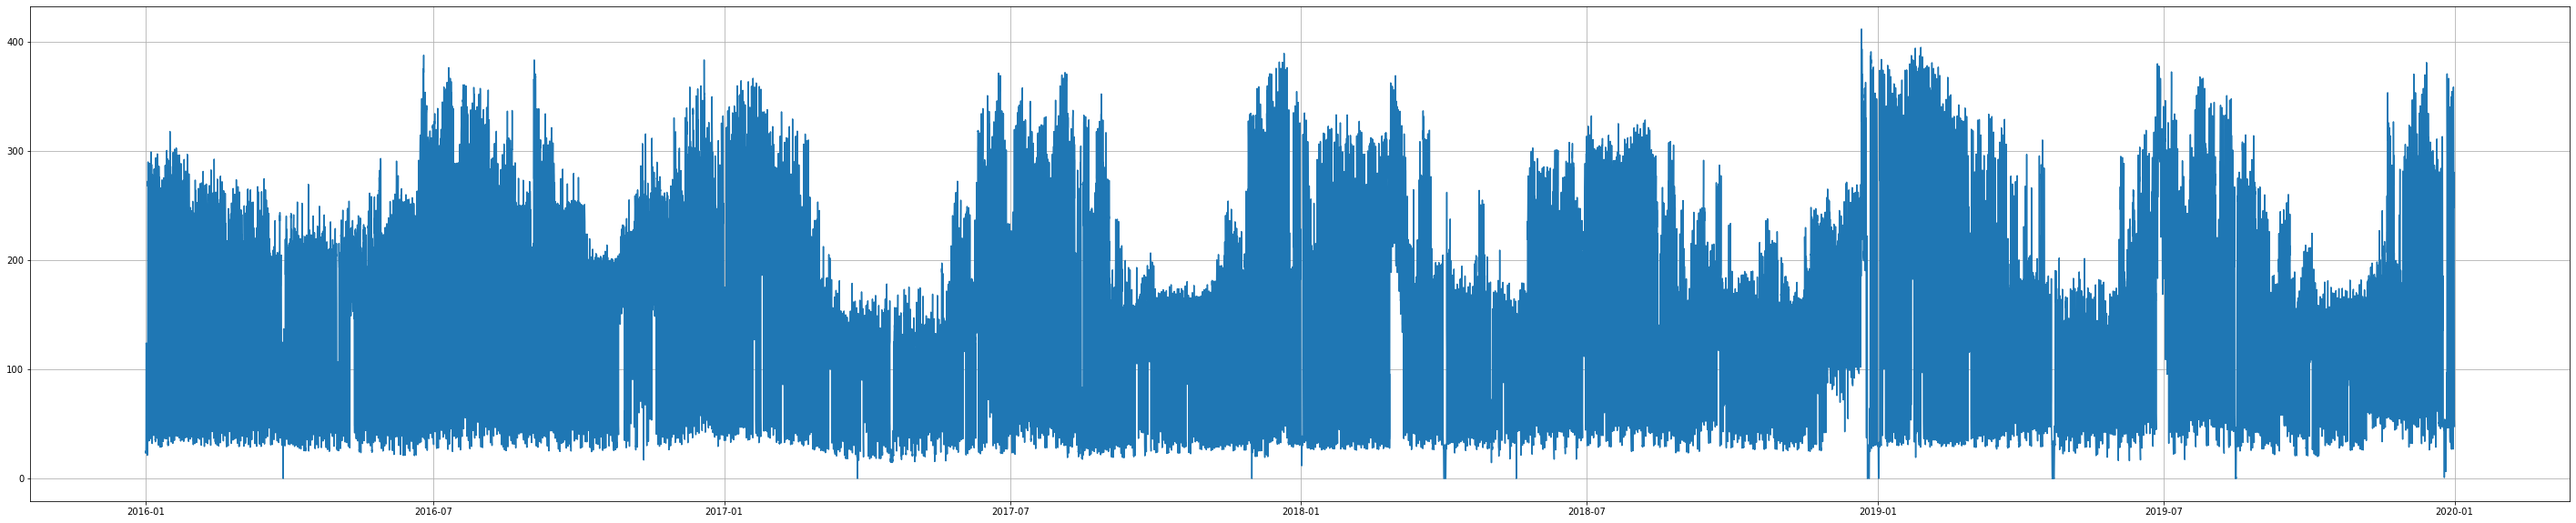

In [8]:
plt.plot(datacittà['Kw'])
plt.show()

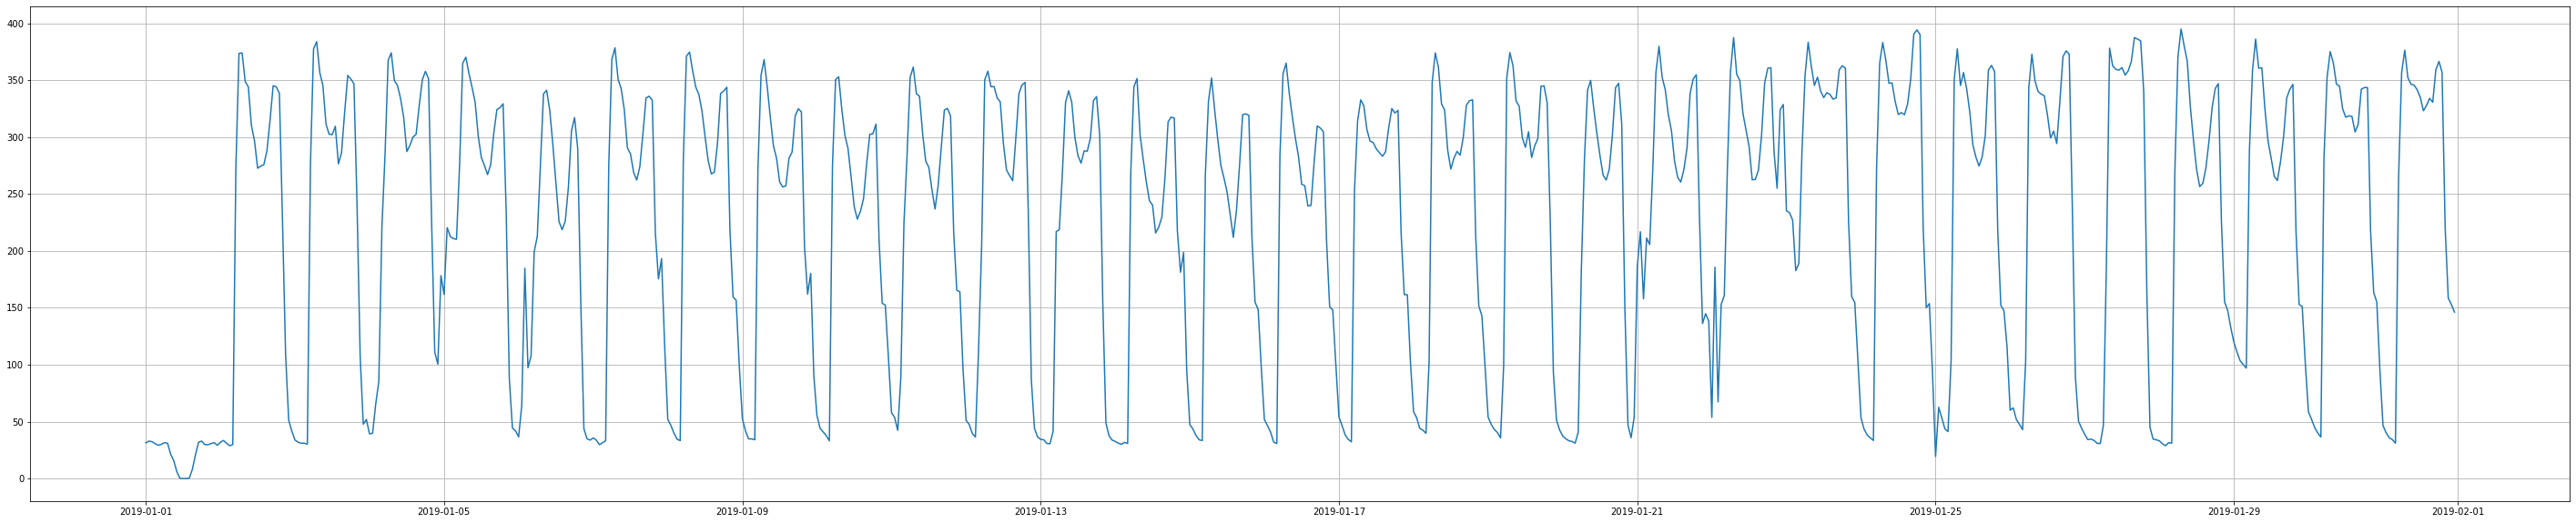

In [9]:
# Esempio Gennaio 2019
mask1 = datacittà['anno']==2019
mask2 = datacittà['mese']==1
plt.plot(datacittà[(mask1) & (mask2)]['Kw'])
plt.show()

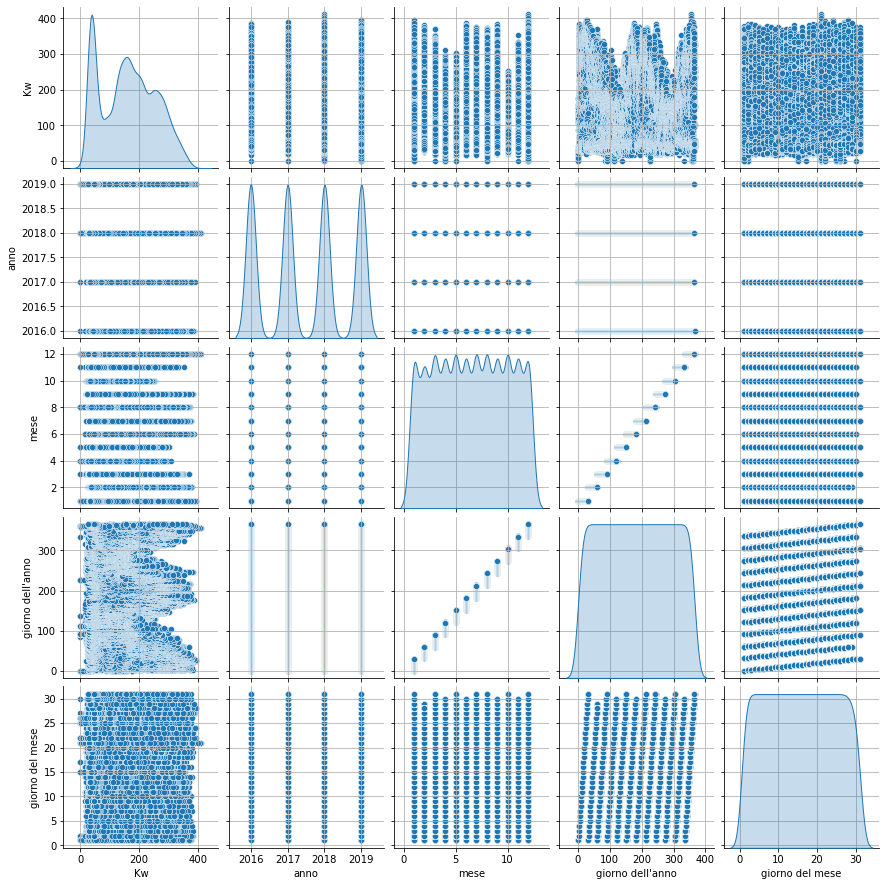

In [10]:
sns.pairplot(datacittà[['Kw', 'anno', 'mese', "giorno dell'anno", 'giorno del mese']], diag_kind="kde")

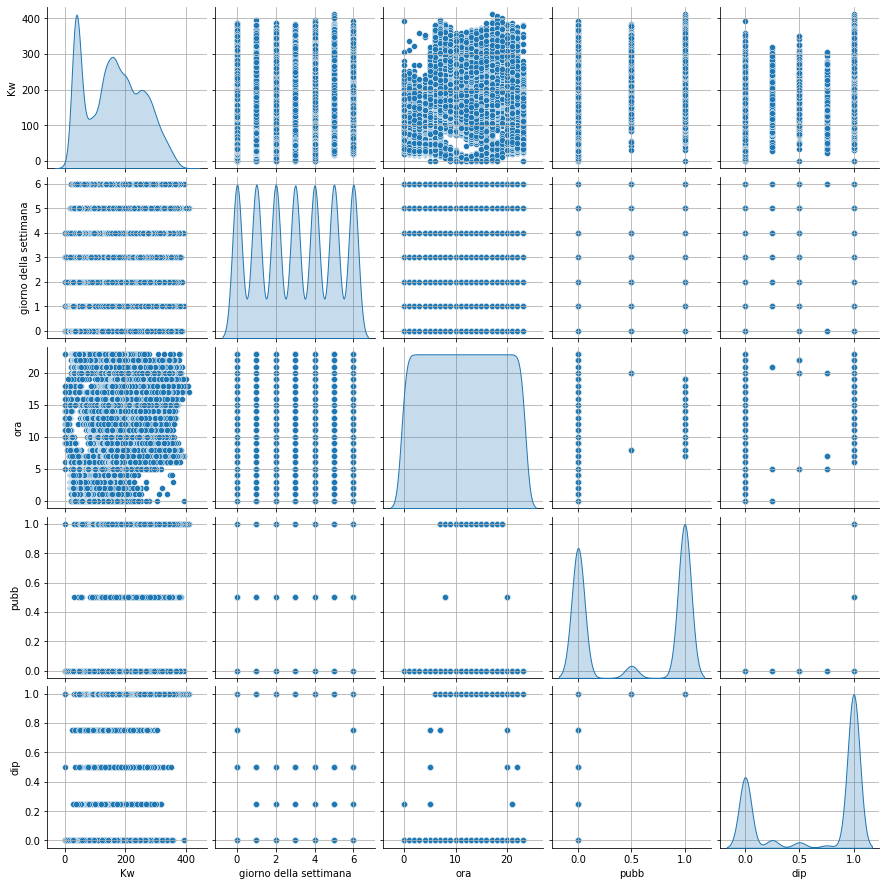

In [11]:
sns.pairplot(datacittà[['Kw', 'giorno della settimana', 'ora', 'pubb', 'dip']], diag_kind="kde")

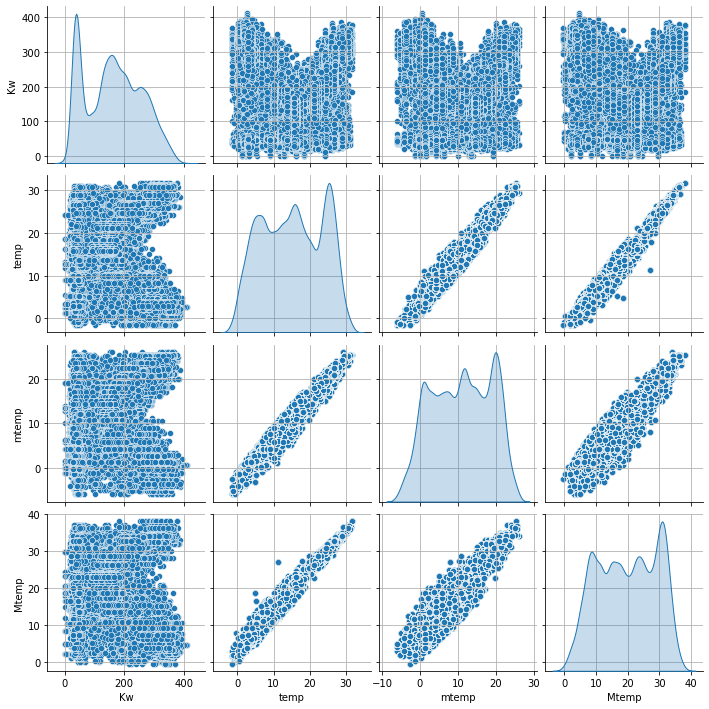

In [12]:
sns.pairplot(datacittà[['Kw', 'temp', 'mtemp', 'Mtemp']], diag_kind="kde")

In [13]:
#Aggiungo un random noise ai valori di pubblico e dipendenti per poter meglio vedere la distribuzione dei consumi

#plt.plot(datacittà['pubb']+0.05*np.random.randn(len(datacittà['pubb'])), np.sqrt(datacittà['Kw']), 'bo')
#plt.plot(datacittà['dip']+0.05*np.random.randn(len(datacittà['dip'])), np.sqrt(datacittà['Kw']), 'ro')
#plt.title(città)
#plt.show()

In [14]:
#come sopra, ma per tutte le città

#for città in data_edit:
#    plt.plot(data[città]['pubb']+0.05*np.random.randn(len(data[città]['pubb'])), np.sqrt(data[città]['Kw']), 'bo')
#    plt.plot(data[città]['dip']+0.05*np.random.randn(len(data[città]['dip'])), np.sqrt(data[città]['Kw']), 'ro')
#    plt.title(città)
#    plt.show()

In [15]:
#Aggiungo un random noise ai valori di pubblico e dipendenti per poter meglio vedere la distribuzione dei consumi
"""
plt.plot(datacittà['led']+0.1*np.random.randn(len(datacittà['led'])), np.sqrt(datacittà['Kw']), 'o')
plt.title(città)
plt.show()

plt.plot(datacittà['fvt']+0.1*np.random.randn(len(datacittà['fvt'])), np.sqrt(datacittà['Kw']), 'o')
plt.title(città)
plt.show()

plt.plot(datacittà['bms']+0.1*np.random.randn(len(datacittà['bms'])), np.sqrt(datacittà['Kw']), 'o')
plt.title(città)
plt.show()
"""

"\nplt.plot(datacittà['led']+0.1*np.random.randn(len(datacittà['led'])), np.sqrt(datacittà['Kw']), 'o')\nplt.title(città)\nplt.show()\n\nplt.plot(datacittà['fvt']+0.1*np.random.randn(len(datacittà['fvt'])), np.sqrt(datacittà['Kw']), 'o')\nplt.title(città)\nplt.show()\n\nplt.plot(datacittà['bms']+0.1*np.random.randn(len(datacittà['bms'])), np.sqrt(datacittà['Kw']), 'o')\nplt.title(città)\nplt.show()\n"

# Autocorrelazioni

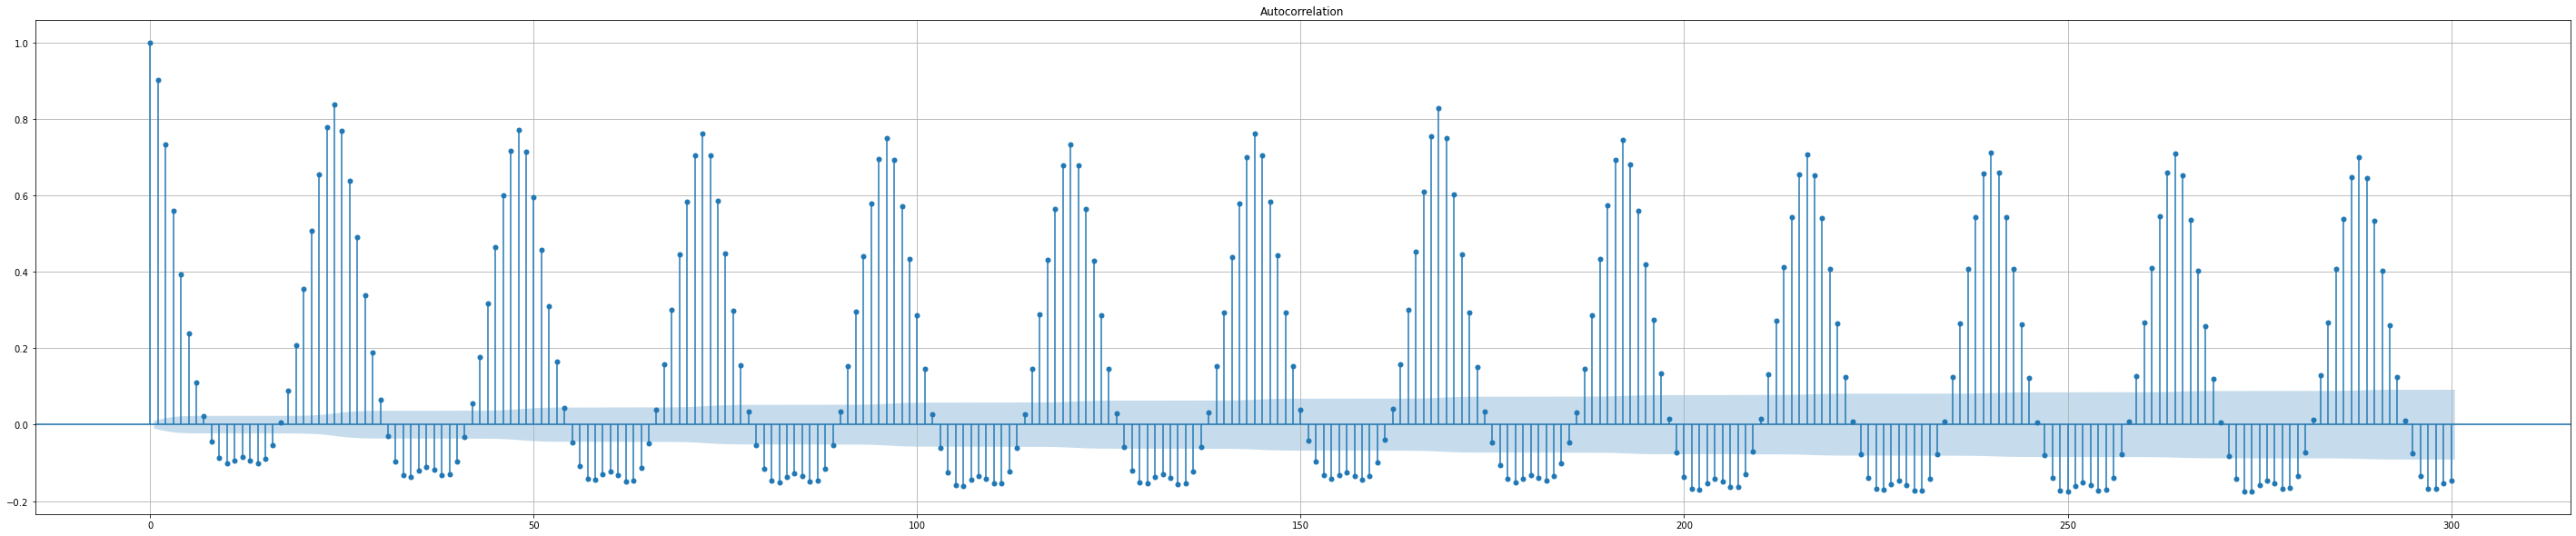

In [16]:
sm.graphics.tsa.plot_acf(datacittà['Kw'].dropna(), lags=300)
plt.show()

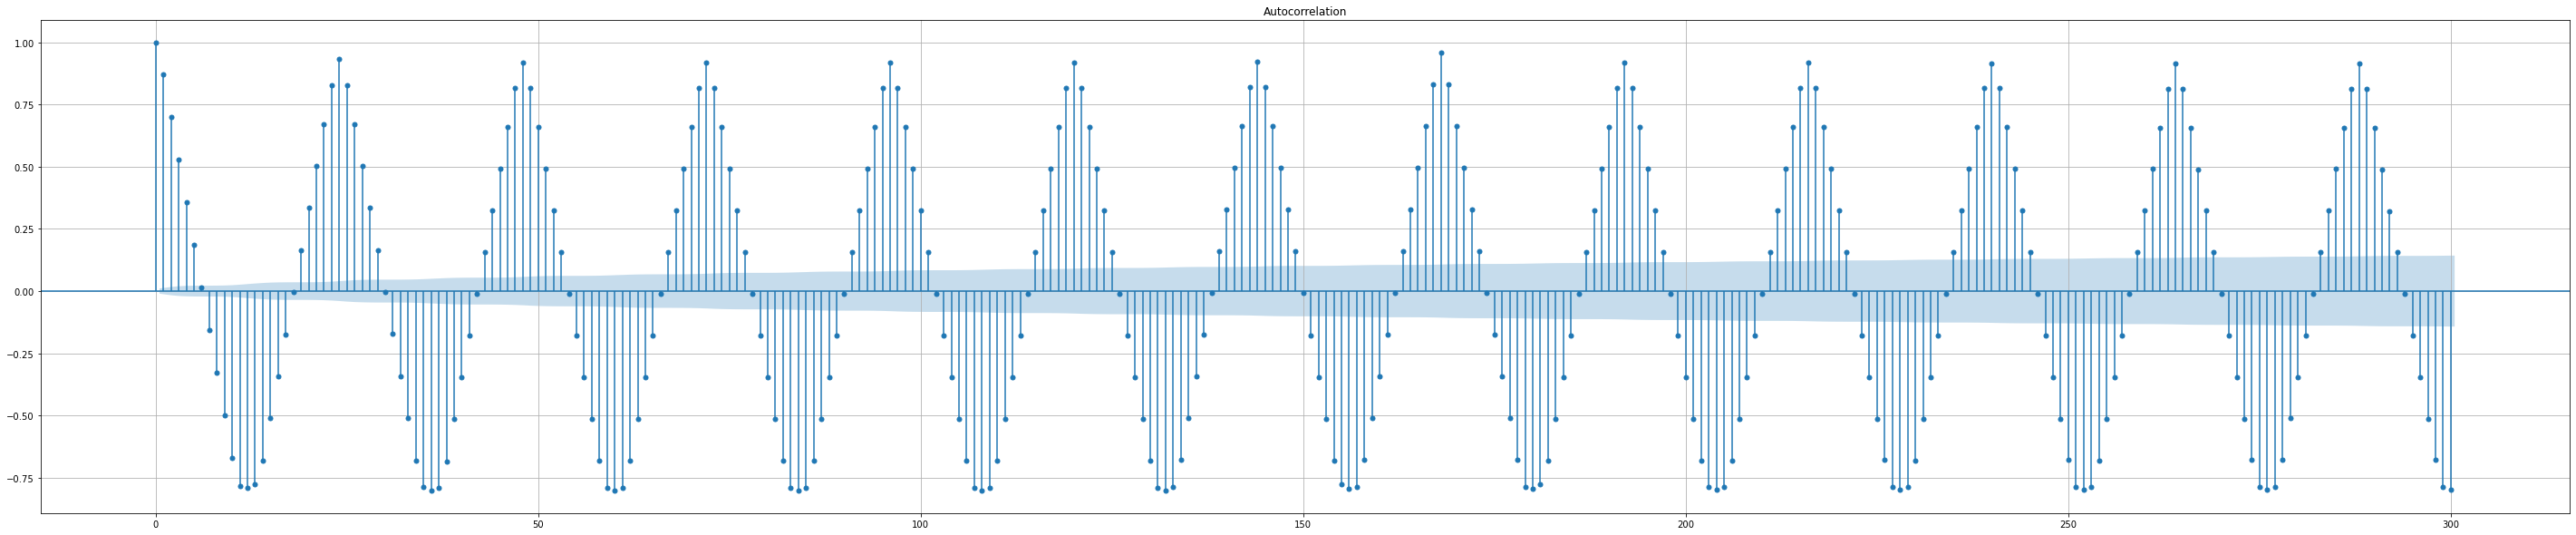

In [17]:
sm.graphics.tsa.plot_acf(datacittà['pubb'].dropna(), lags=300)
plt.show()

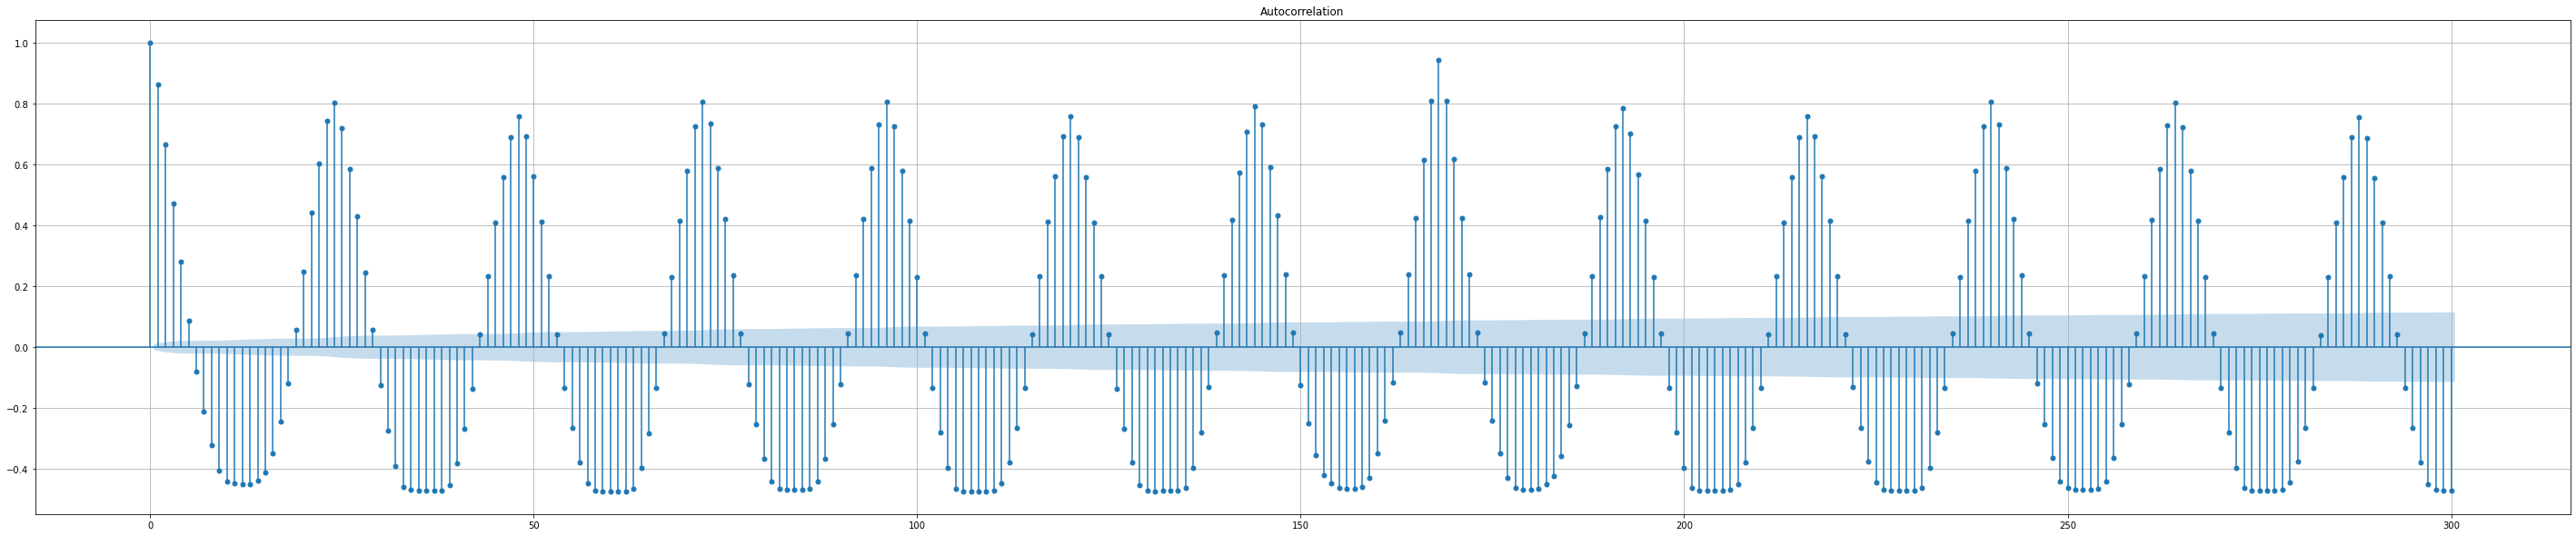

In [18]:
sm.graphics.tsa.plot_acf(datacittà['dip'].dropna(), lags=300)
plt.show()

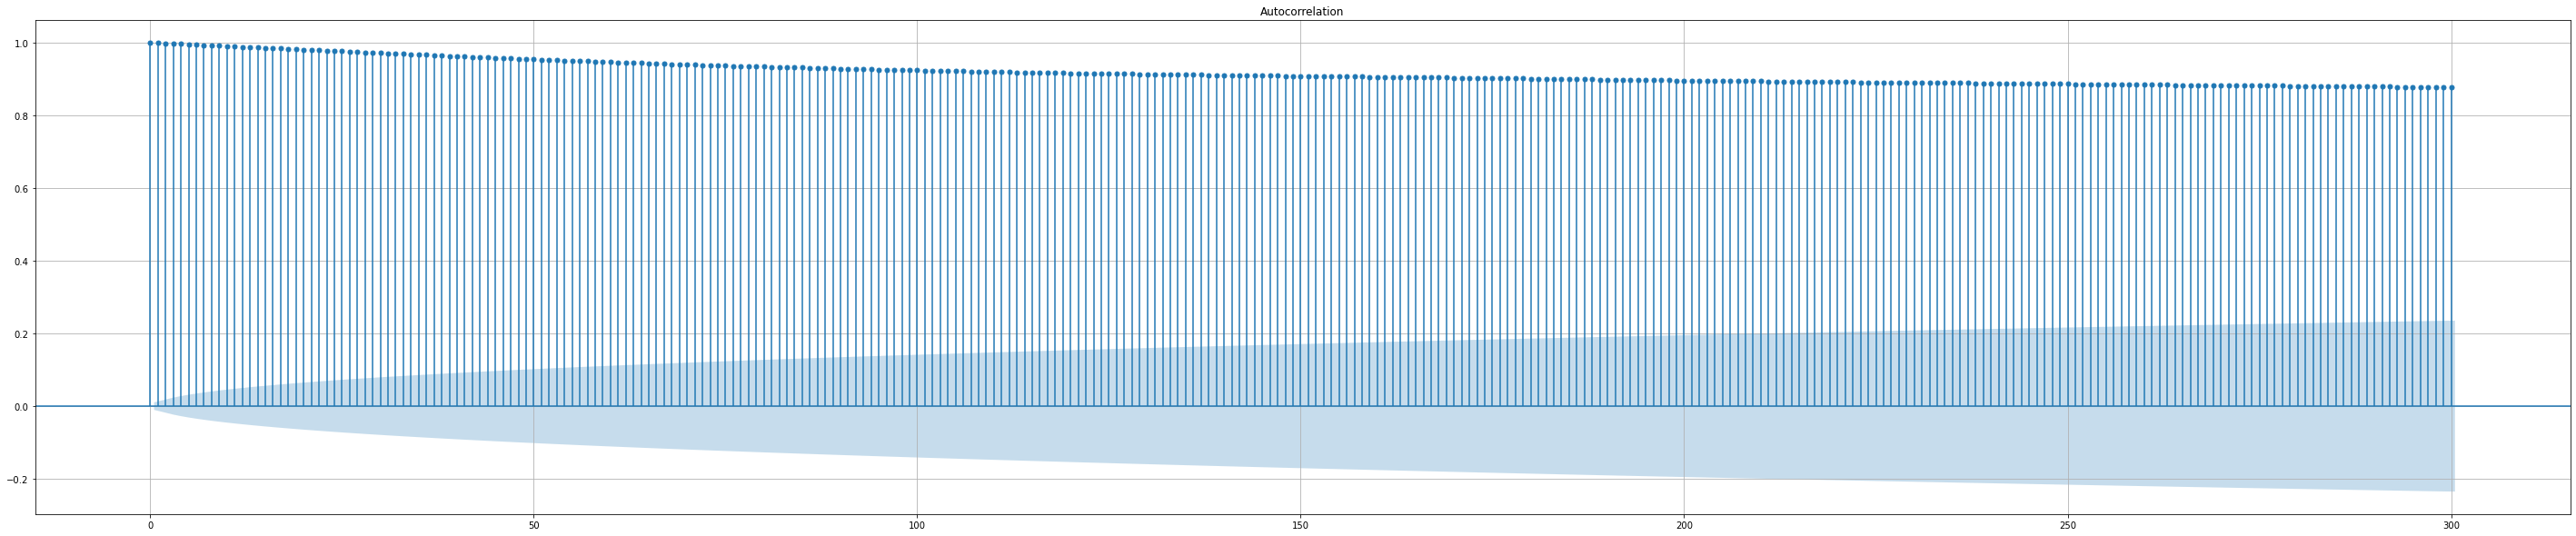

In [19]:
sm.graphics.tsa.plot_acf(datacittà['temp'].dropna(), lags=300)
plt.show()

# La temperatura ha effetto solo sopra ad una certa soglia di consumi ed ha effetto positivo sia per temperature basse che alte

In [7]:
temp_list = np.sort(datacittà.dropna()['temp'].unique())
cons_list = []
for temp in np.sort(temp_list):
    cons = np.nanmax(datacittà[datacittà['temp'] == temp]['Kw'])
    cons_list.append(cons)
print('Il minimo dei consumi massimi per ogni temperatura osservata è {} kW.\nA tale valore corrisponde la temperatura di {} gradi.'.format(min(cons_list), temp_list[np.argmin(cons_list)]))

Il minimo dei consumi massimi per ogni temperatura osservata è 147.561 kW.
A tale valore corrisponde la temperatura di 18.9 gradi.


Utilizzando il filtro Savitzky-Golay*, otteniamo che il valore minimo per la temperaura (e scelto come t0) è 11.8 gradi.
A tale temperatura corrisponde il consumo di 178.82635294117645 kW

*https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter
https://it.qaz.wiki/wiki/Savitzky%E2%80%93Golay_filter
 Adatta un polinomio di grado  n (n=1 nel nostro caso), ad un sottinsieme dei punti e procede per finestre consucutive.


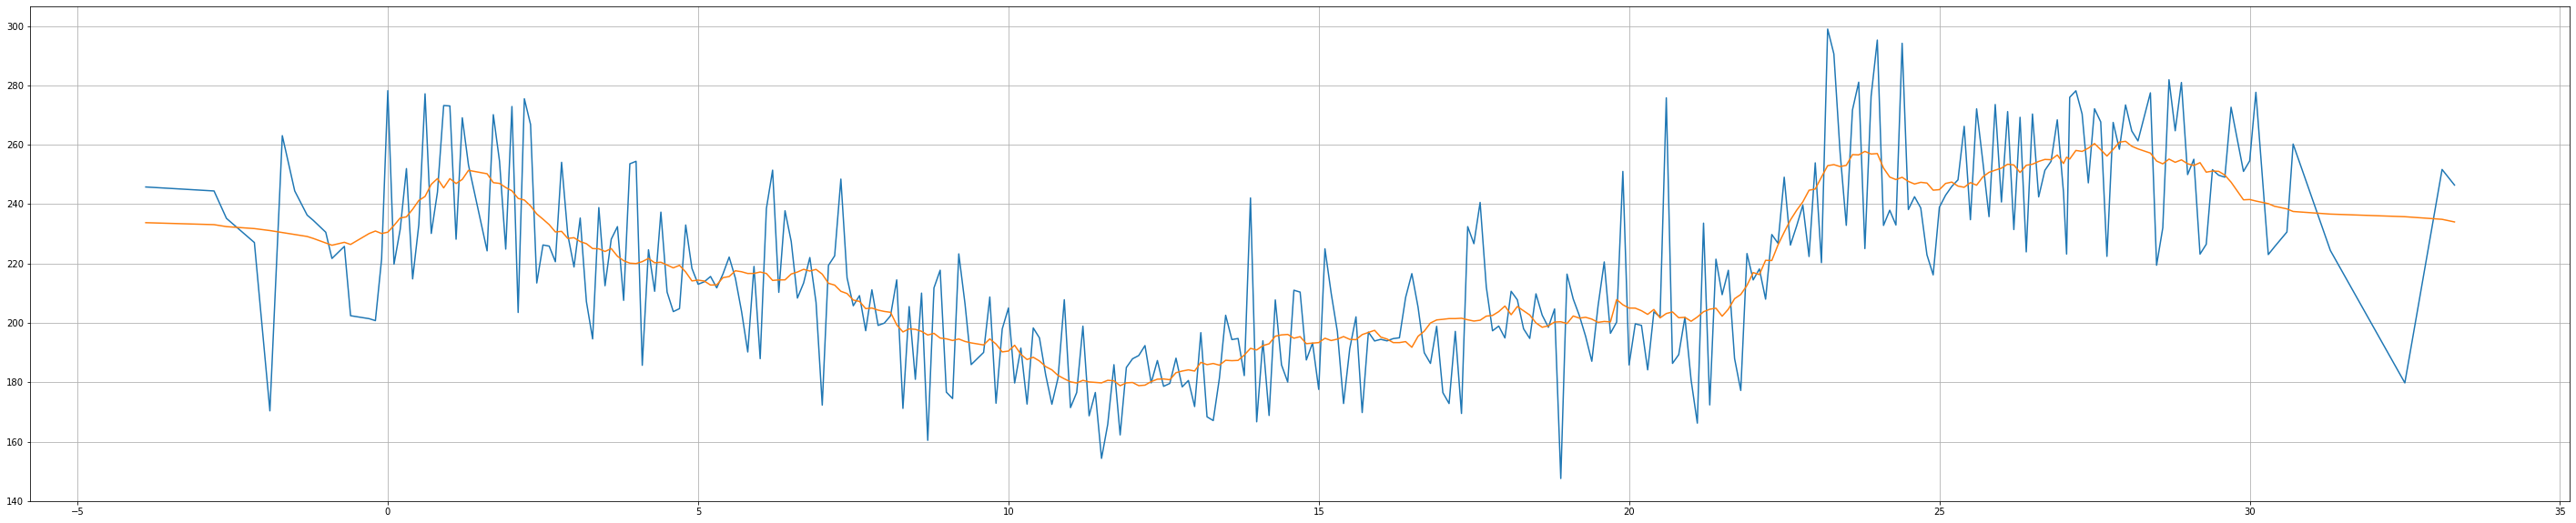

In [8]:
ball = np.round(int(np.sqrt(len(cons_list))))
if ball%2 !=1:
    ball = ball+1
ball = int(ball)
poly_y = scipy.signal.savgol_filter(cons_list, ball, 1)

t0 = np.sort(datacittà['temp'].unique())[np.argmin(poly_y)]
c0 = min(poly_y)

print('Utilizzando il filtro Savitzky-Golay*, otteniamo che il valore minimo per la temperaura (e scelto come t0) è {} gradi.\nA tale temperatura corrisponde il consumo di {} kW'.format(t0, c0))
print('\n*https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter\nhttps://it.qaz.wiki/wiki/Savitzky%E2%80%93Golay_filter\n',
     'Adatta un polinomio di grado  n (n=1 nel nostro caso), ad un sottinsieme dei punti e procede per finestre consucutive.')
plt.plot(temp_list, cons_list)
plt.plot(temp_list, poly_y)
plt.show()

# Aggiungo temp+ e temp-
Costruiti simili alla funzione ReLu, aventi come origine il valore t0.

Annulliamo anche l'effetto della temperatura sui consumi inferiori a c0.

In [14]:
datacittà['temp+'] = datacittà['temp']-t0
datacittà['temp-'] = t0 - datacittà['temp']

maskt0p = datacittà['temp+']<0
maskt0n = datacittà['temp-']<0
maskc0 = datacittà['Kw']<c0

datacittà.loc[maskt0p, 'temp+']=0
datacittà.loc[maskt0n, 'temp-']=0
datacittà.loc[maskc0, 'temp+']=0
datacittà.loc[maskc0, 'temp-']=0

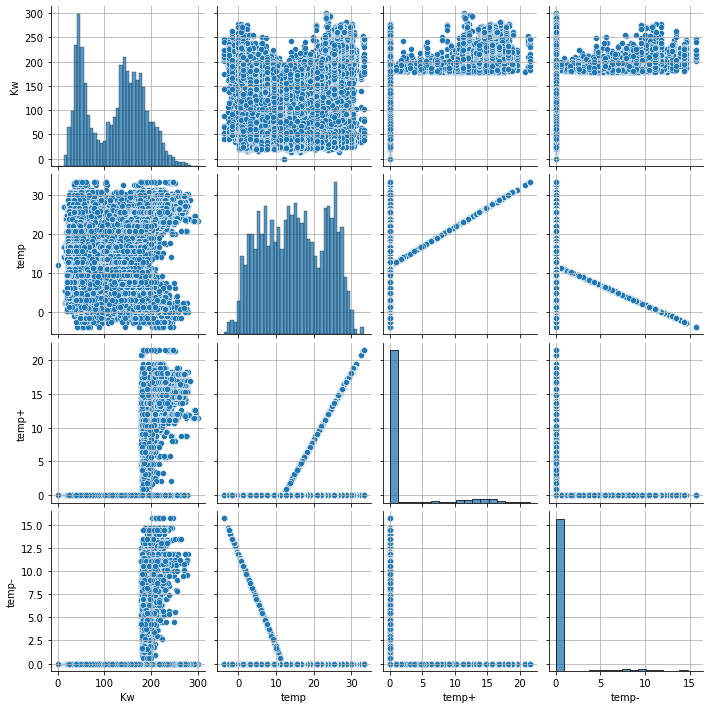

In [10]:
sns.pairplot(datacittà[['Kw', 'temp', 'temp+', 'temp-']])#, diag_kind="kde")

# Alcuni modelli testati
Confronto dati 2018 con 2019

# Modello Lineare
Provato anche con scala logaritmica e con radice quadrata, ma i risulati non sono stati molto migliori.

In [15]:
X = ['error', 'pubb', 'dip', 'temp+', 'temp-']

Bologna 
                             OLS Regression Results                            
Dep. Variable:                     Kw   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                 2.016e+04
Date:                Mon, 01 Feb 2021   Prob (F-statistic):               0.00
Time:                        23:54:25   Log-Likelihood:                -38489.
No. Observations:                8759   AIC:                         7.699e+04
Df Residuals:                    8754   BIC:                         7.702e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
error         52.0766      0.349    149.28

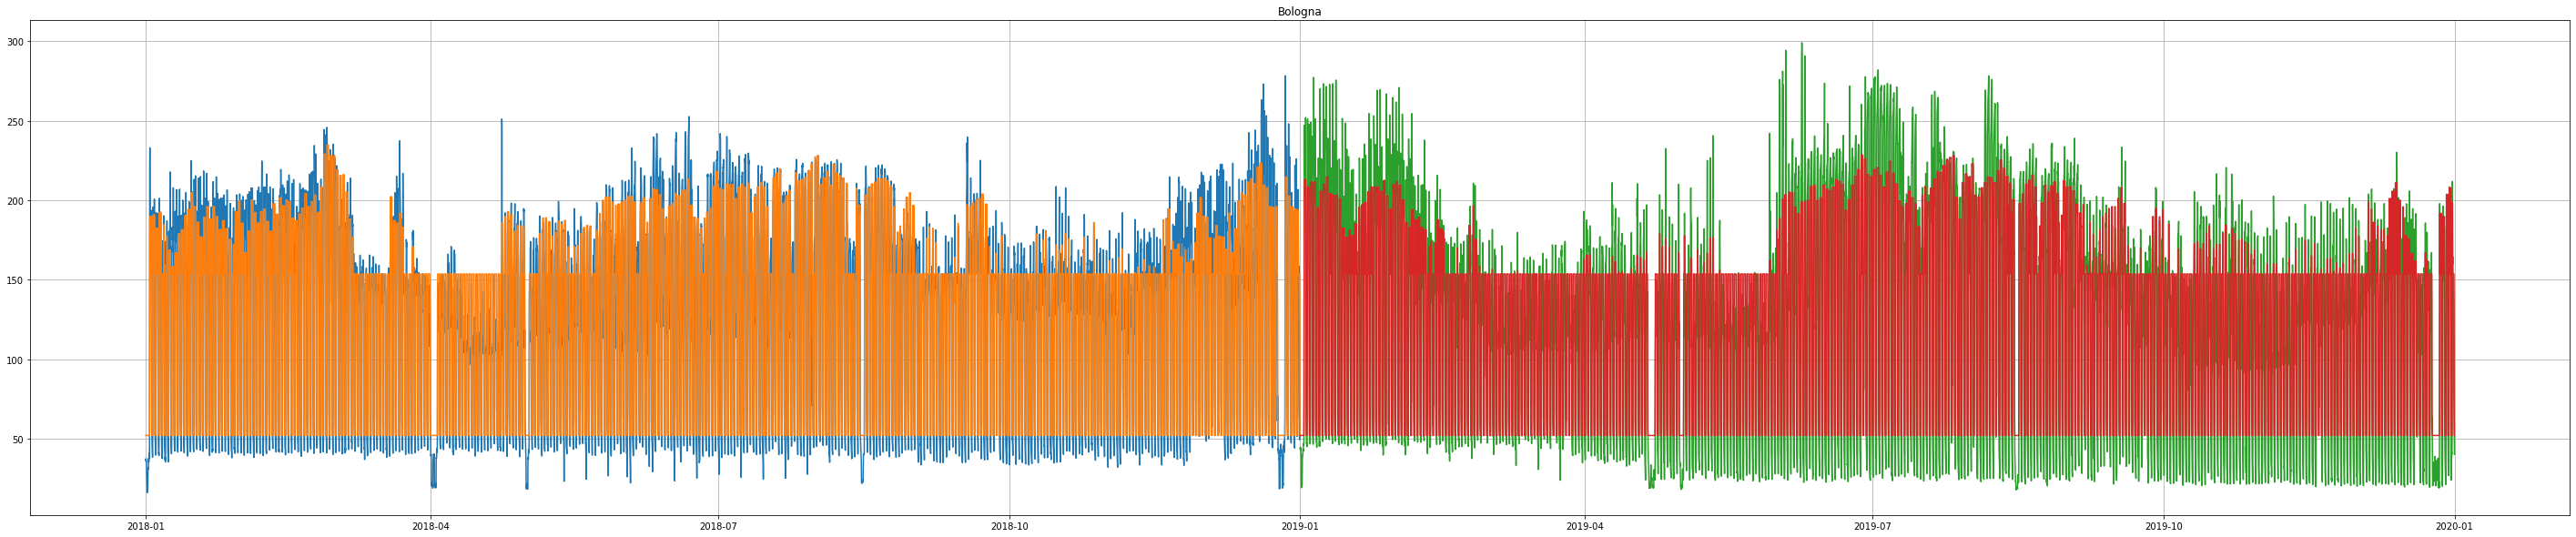

In [12]:
datacittà2018 = datacittà[datacittà['anno']==2018].dropna()
datacittà2019 = datacittà[datacittà['anno']==2019].dropna()

x = datacittà2018[X]
x1 = datacittà2019[X]
y = datacittà2018['Kw']
y1 = datacittà2019['Kw']

x = sm.add_constant(x)
x1 = sm.add_constant(x1)

model = sm.OLS(y,x)
results = model.fit()
print(città, '\n', results.summary(), '\n\n')

yhat = results.fittedvalues
pred = results.predict(x1)

plt.plot(y)
plt.plot(yhat)
plt.plot(y1)
plt.plot(pred)
plt.title('{}'.format(città))
plt.show()

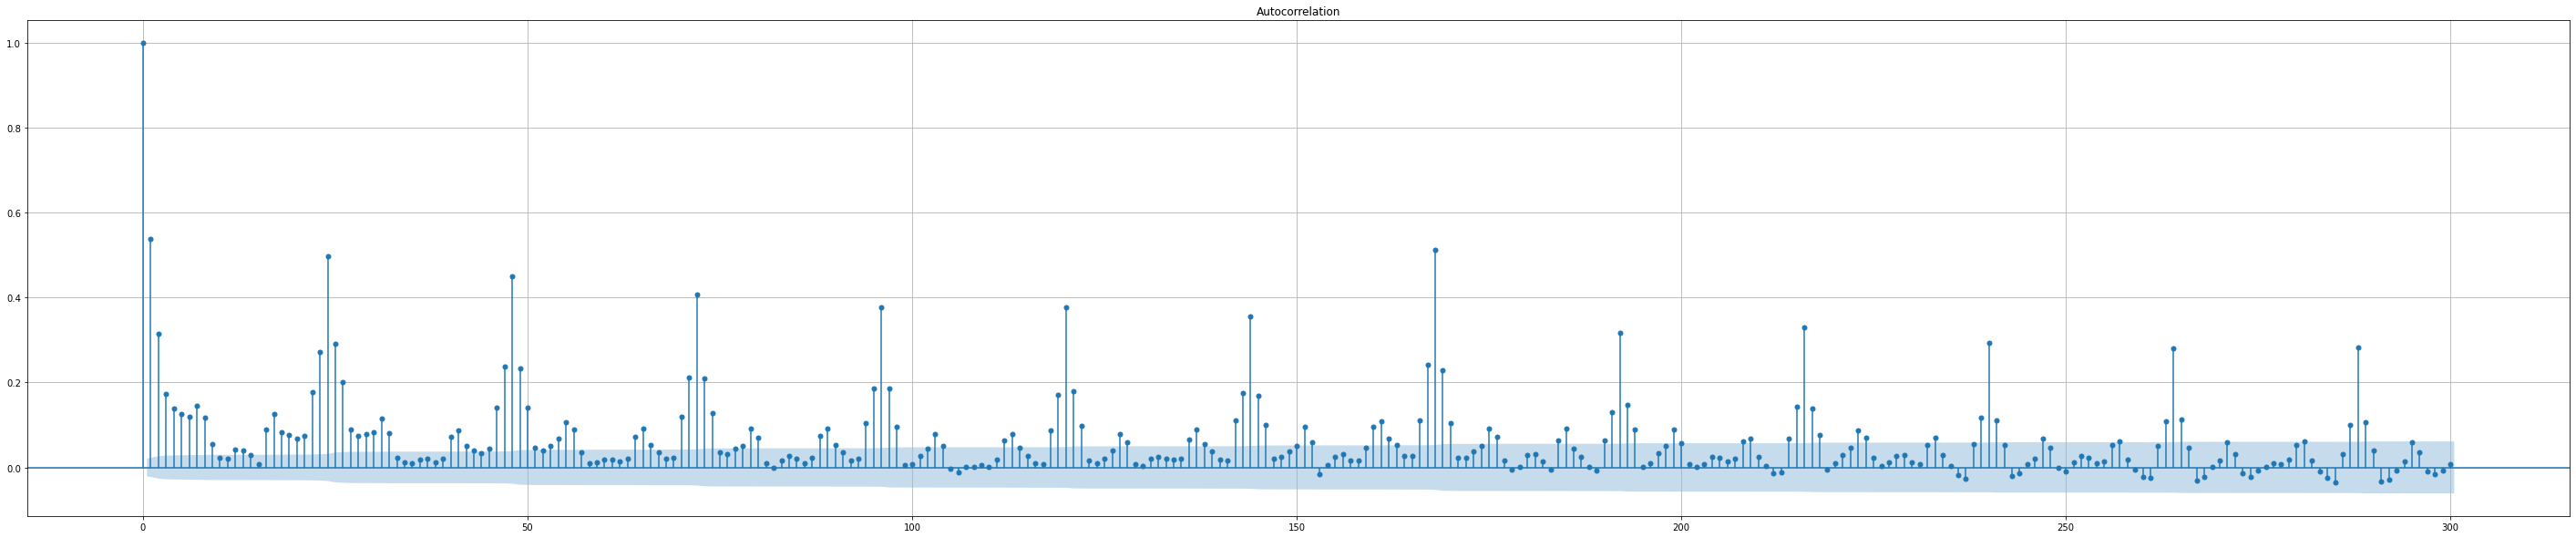

In [13]:
#Autocorrelazione dei residui

sm.graphics.tsa.plot_acf(results.resid.dropna(), lags=300)
plt.show()

# NNLS (Non Negative Least Square)

In [27]:
X = ['error', 'pubb', 'dip', 'temp+', 'temp-']

In [28]:
# Funzione di calcolo per R-quadro

def r_square(y, y_hat):
    ess = np.sum(np.square(y_hat - np.mean(y)))
    tss = np.sum(np.square(y - np.mean(y)))
    return ess/tss

{'const': 0.0, 'error': 62.64686260004206, 'pubb': 0.0, 'dip': 98.59051829503976, 'temp+': 9.712811504433235, 'temp-': 10.662860321624986}
Segrate 	 0.8116011066024876


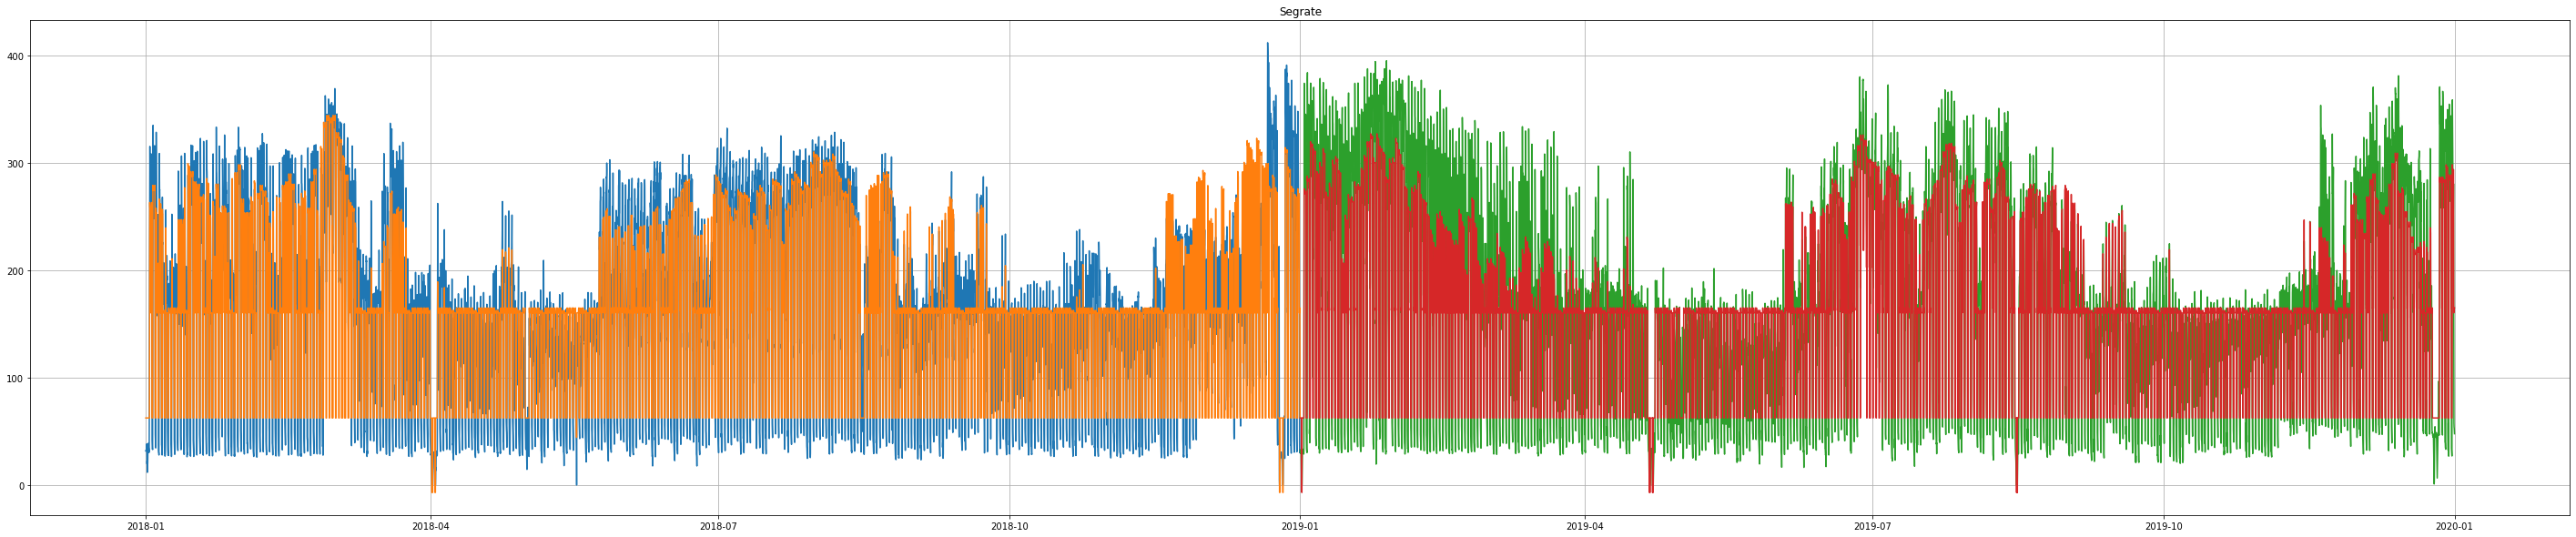

In [29]:
datacittà2018 = datacittà[datacittà['anno']==2018].dropna()
datacittà2019 = datacittà[datacittà['anno']==2019].dropna()

x = datacittà2018[X]
x1 = datacittà2019[X]
y = datacittà2018['Kw']
y1 = datacittà2019['Kw']

x = sm.add_constant(x)
x1 = sm.add_constant(x1)


coef, res = scipy.optimize.nnls(x, y)
print(dict(zip(x.keys(), coef)))
yhat = x.dot(coef)
pred = x1.dot(coef)
#print(pred)
print(città, '\t', r_square(y, yhat))

yhat = results.fittedvalues
pred = results.predict(x1)

plt.plot(y)
plt.plot(yhat)
plt.plot(y1)
plt.plot(pred)
plt.title('{}'.format(città))
plt.show()

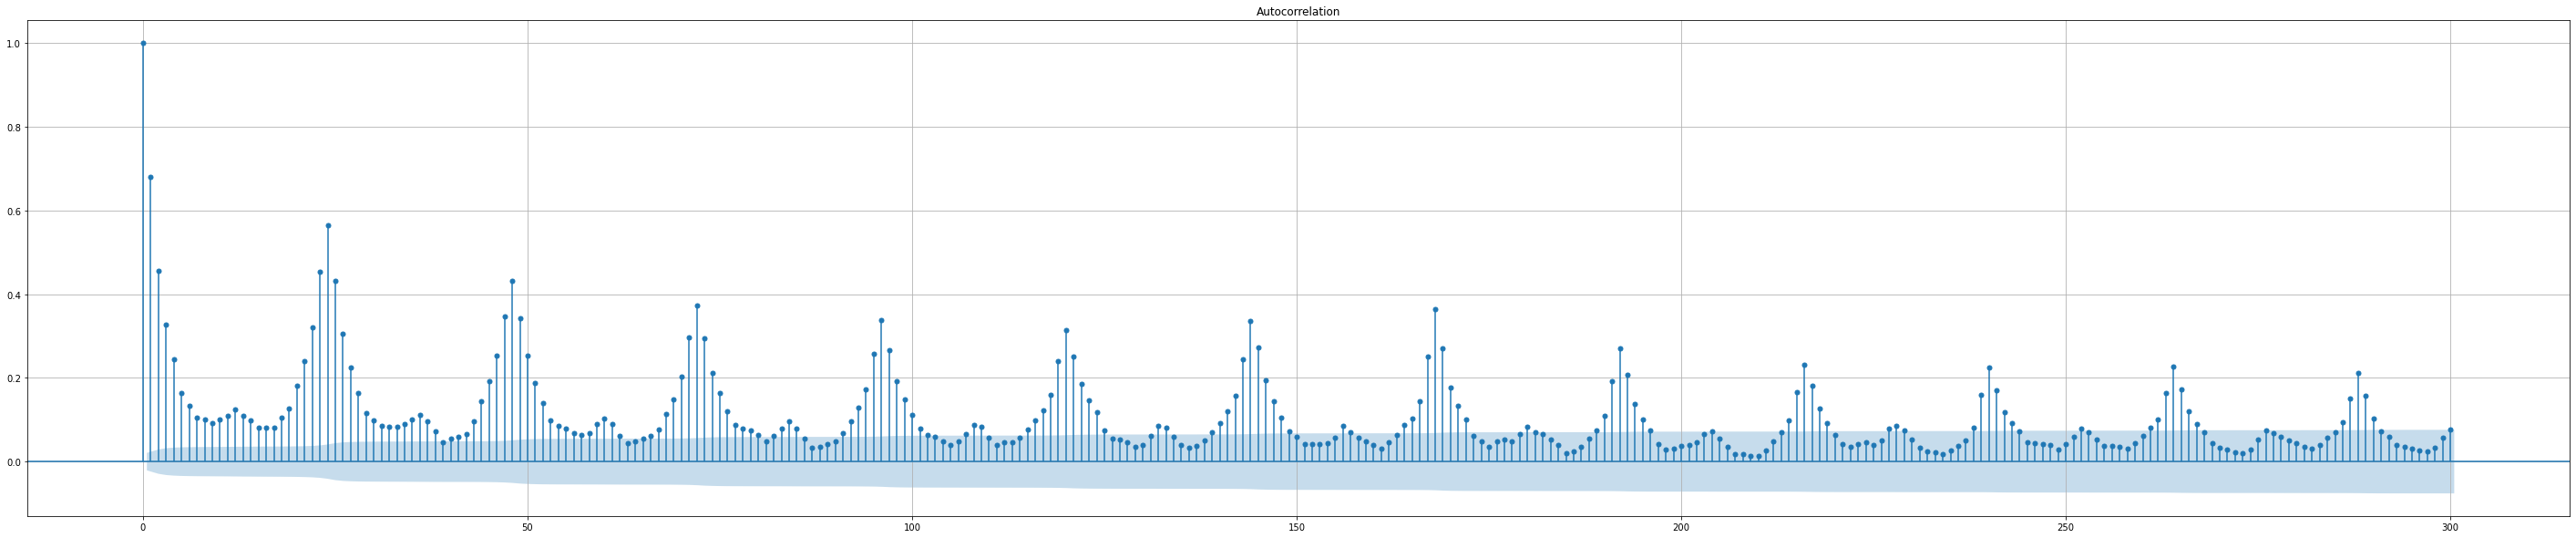

In [30]:
#Autocorrelazione dei residui

sm.graphics.tsa.plot_acf(y-yhat, lags=300)
plt.show()

# Autoregressivo
Lag = 1, 2, 24, 7*24

In [31]:
X = ['error', 'pubb', 'dip', 'temp+', 'temp-']

2018-01-08 00:00:00     37.919985
2018-01-08 01:00:00     37.525246
2018-01-08 02:00:00     35.889675
2018-01-08 03:00:00     37.176153
2018-01-08 04:00:00     36.529379
                          ...    
2018-12-31 19:00:00    167.812813
2018-12-31 20:00:00     88.912575
2018-12-31 21:00:00    111.684275
2018-12-31 22:00:00     87.146916
2018-12-31 23:00:00     51.375934
Length: 8591, dtype: float64
Segrate 
R-sqared =  0.9074373678293047 




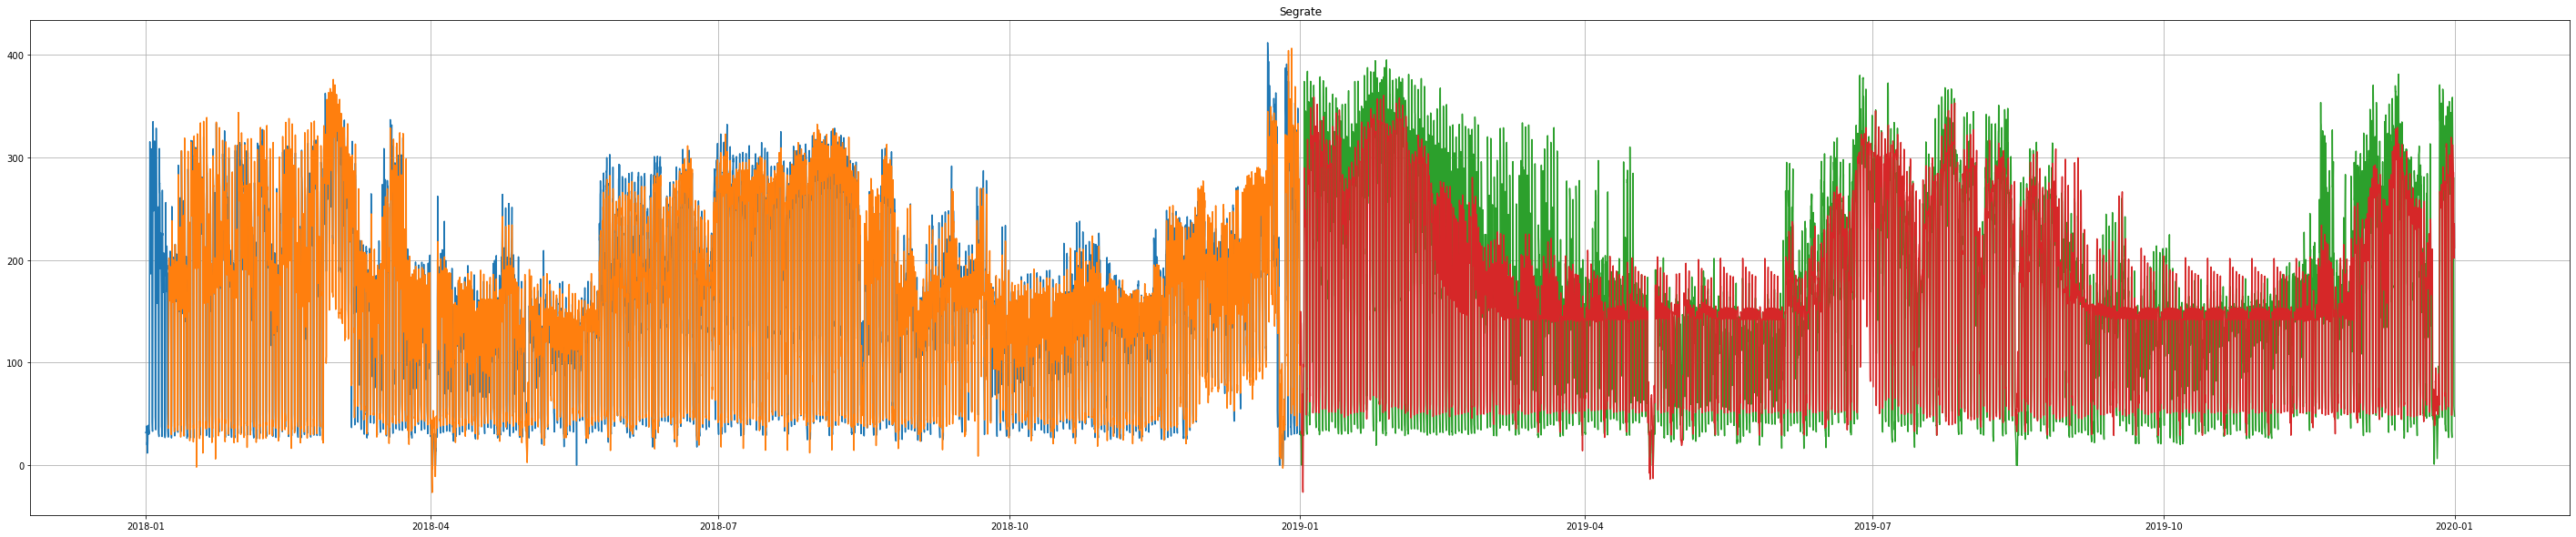

In [32]:
# aggiungo i lag a 24 e 24*7 per le variabili pubblico e dipendenti
datacittà['pubb_24'] = datacittà['pubb'].shift(24)
datacittà['dip_24'] = datacittà['dip'].shift(24)
datacittà['pubb_168'] = datacittà['pubb'].shift(168)
datacittà['dip_168'] = datacittà['dip'].shift(168)

datacittà2018 = datacittà[datacittà['anno']==2018].dropna()
datacittà2019 = datacittà[datacittà['anno']==2019].dropna()

x = datacittà2018[X+['pubb_24','dip_24','pubb_168','dip_168']]
x1 = datacittà2019[X+['pubb_24','dip_24','pubb_168','dip_168']]
y = datacittà2018['Kw'].values
y1 = datacittà2019['Kw'].values

x = sm.add_constant(x)
x1 = sm.add_constant(x1)

model = AutoReg(y, [1, 2, 24, 7*24], exog=x)
results = model.fit()
#print(città, '\n', results.summary(), '\n\n')

y = datacittà2018['Kw']
y1 = datacittà2019['Kw']

yhat = results.fittedvalues
print(yhat)
pred = results.predict(start = len(y), end = len(y)+x1.shape[0]-1, exog_oos = x1)
pred.index = y1.index

results.rsquared = r_square(y, yhat)
print(città, '\nR-sqared = ', results.rsquared, '\n\n')


#pred = results.predict(x1)

plt.plot(datacittà2018['Kw'])
plt.plot(yhat)
plt.plot(datacittà2019['Kw'])
plt.plot(pred)
plt.title('{}'.format(città))
plt.show()

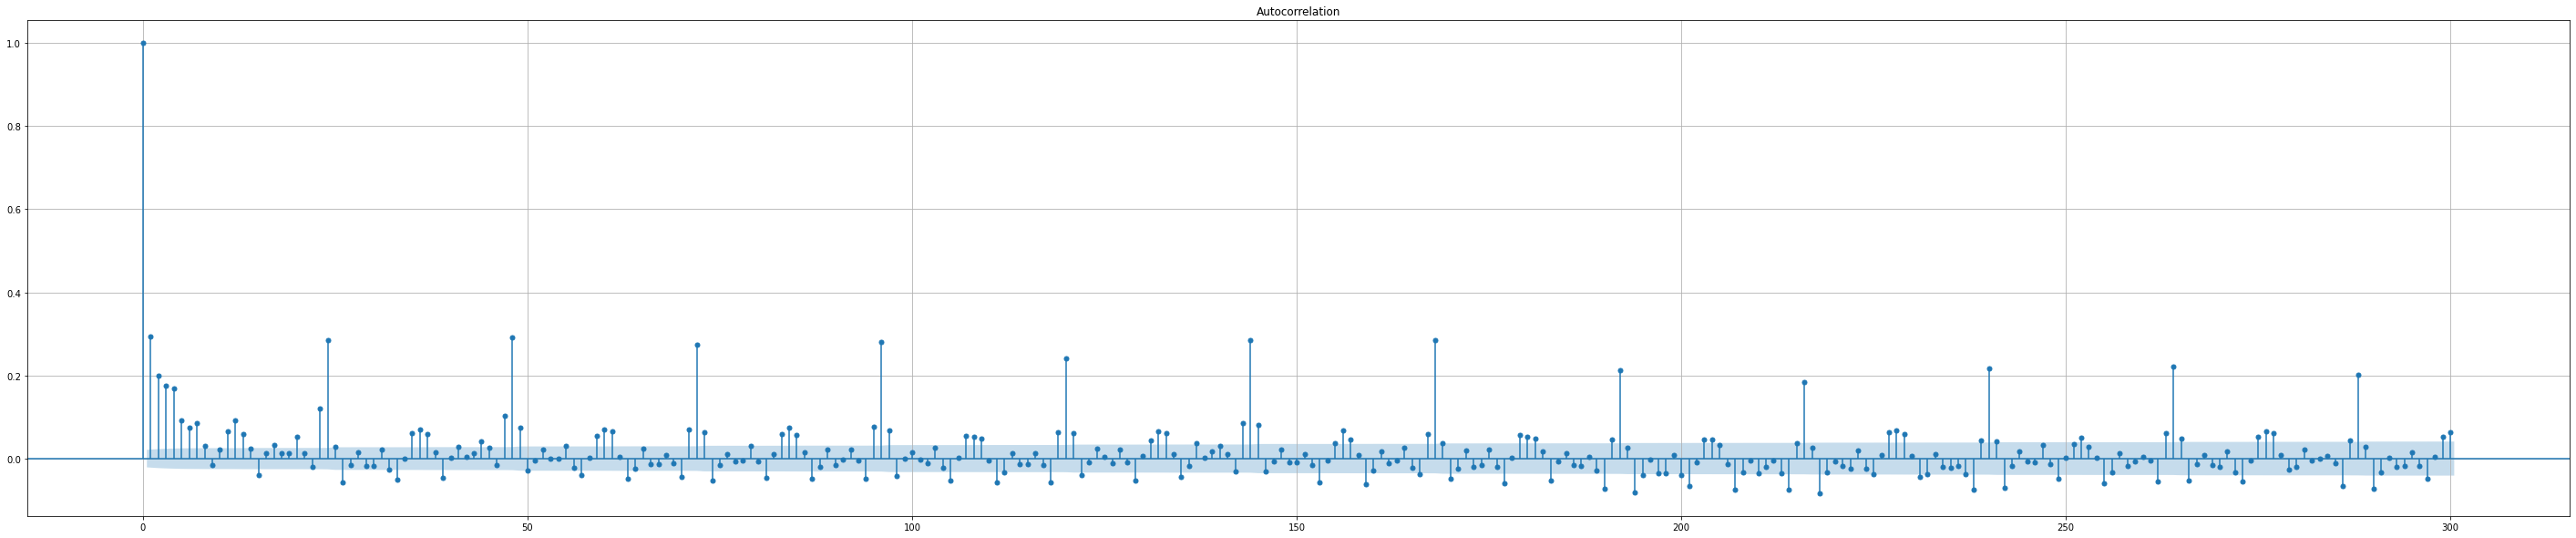

In [33]:
#Autocorrelazione dei residui

sm.graphics.tsa.plot_acf(results.resid.dropna(), lags=300)
plt.show()

Studio l'autocorrelazione dei residui per fasce di consumi, per verificare dove si presentino i picchi che vediamo sopra.

Le seguenti fasce sono state costruite su Roma, ma testate (con valori cambiati, ma abbastanza proporzionali) su altre città

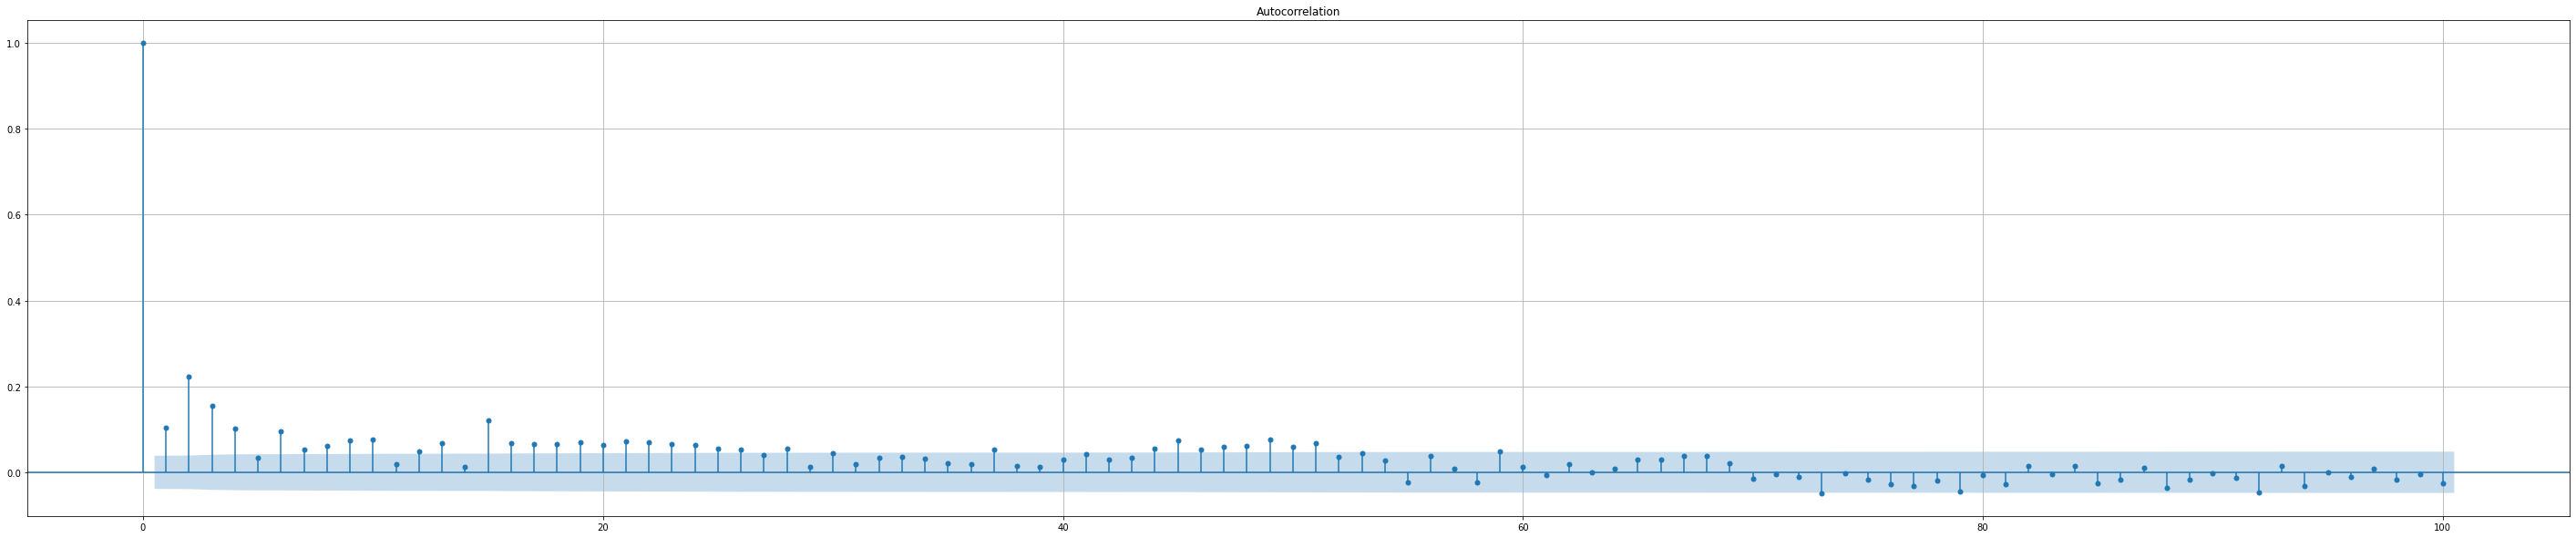

In [34]:
mask = datacittà2018['Kw']<100

sm.graphics.tsa.plot_acf(results.resid[mask].dropna(), lags=100)
plt.show()

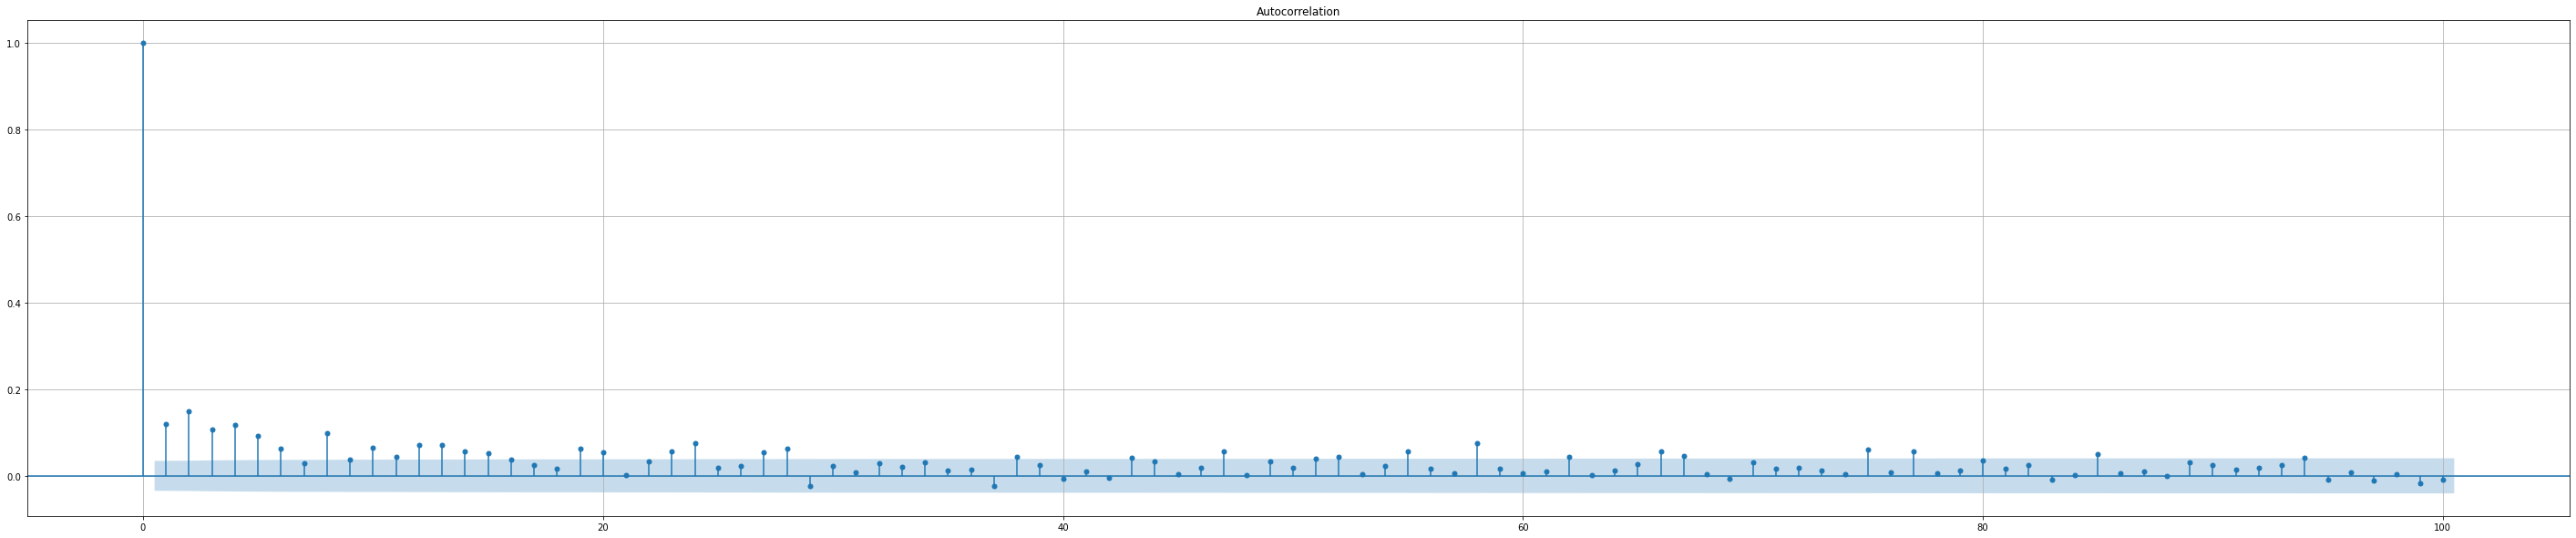

In [35]:
mask1 = datacittà2018['Kw']>=100
mask2 = datacittà2018['Kw']<200

sm.graphics.tsa.plot_acf(results.resid[mask1 & mask2].dropna(), lags=100)
plt.show()

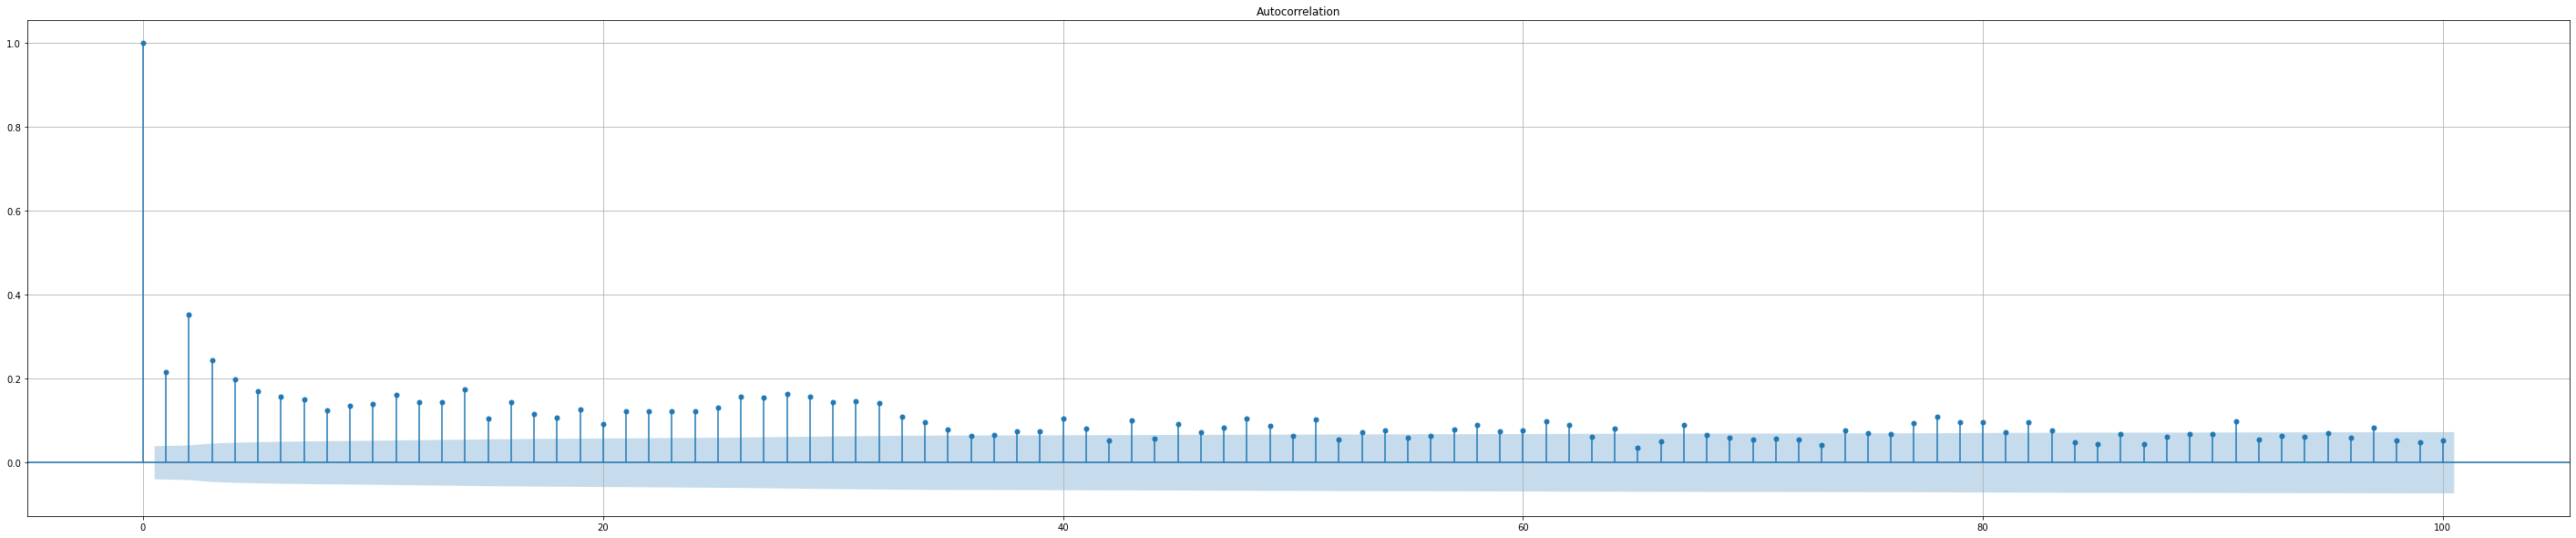

In [36]:
mask1 = datacittà2018['Kw']>=200
mask2 = datacittà2018['Kw']<300

sm.graphics.tsa.plot_acf(results.resid[mask1 & mask2].dropna(), lags=100)
plt.show()

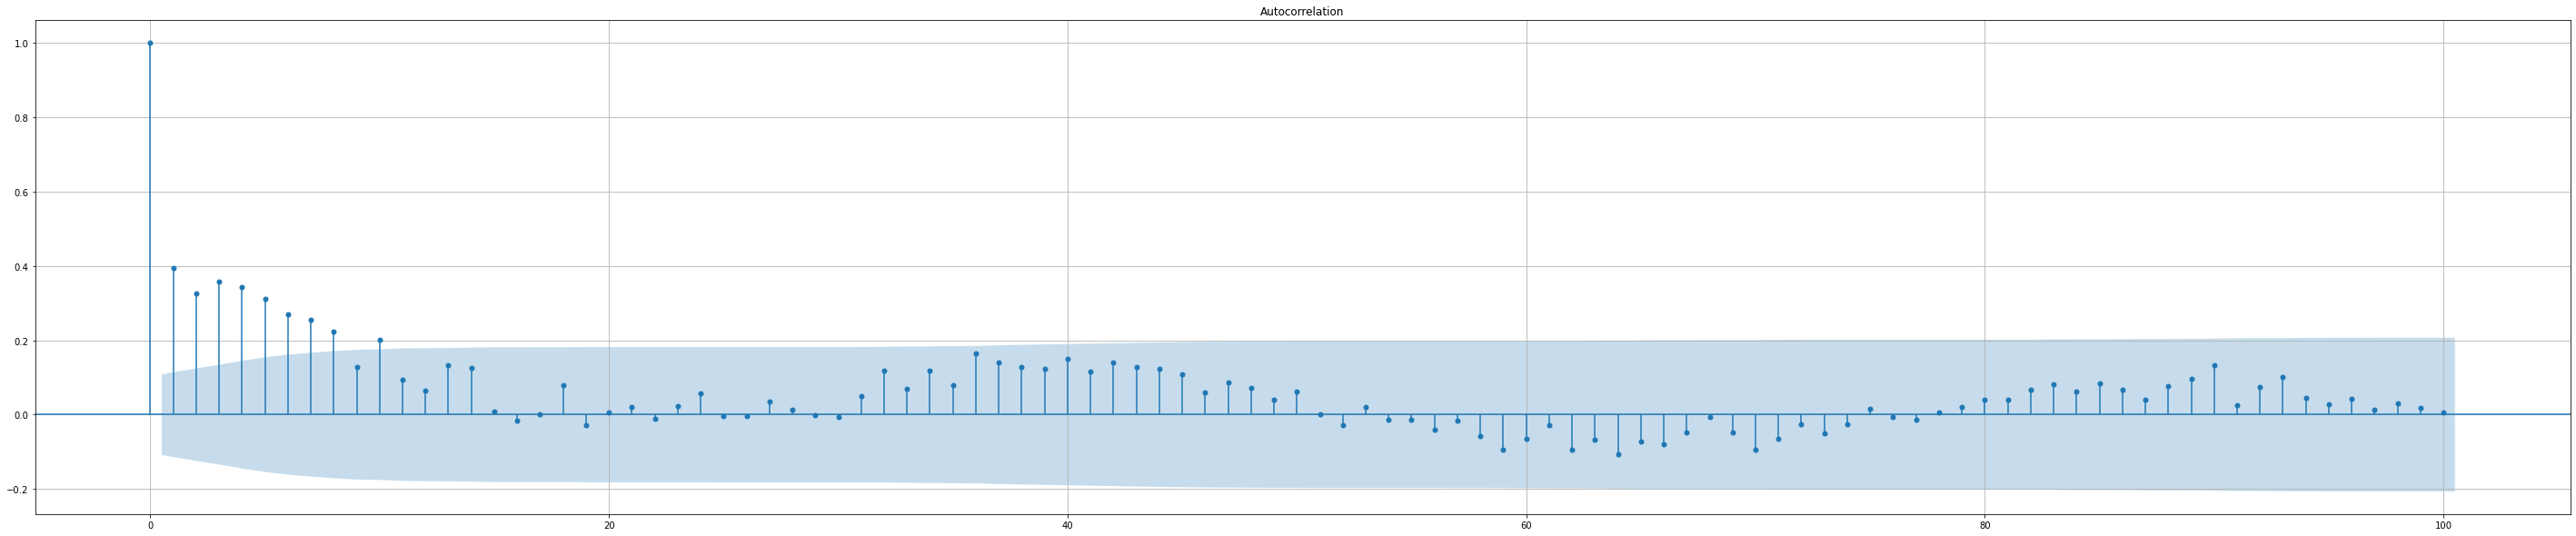

In [37]:
mask1 = datacittà2018['Kw']>=300
mask2 = datacittà2018['Kw']<400

sm.graphics.tsa.plot_acf(results.resid[mask1 & mask2].dropna(), lags=100)
plt.show()

ValueError: could not broadcast input array from shape (3) into shape (101)

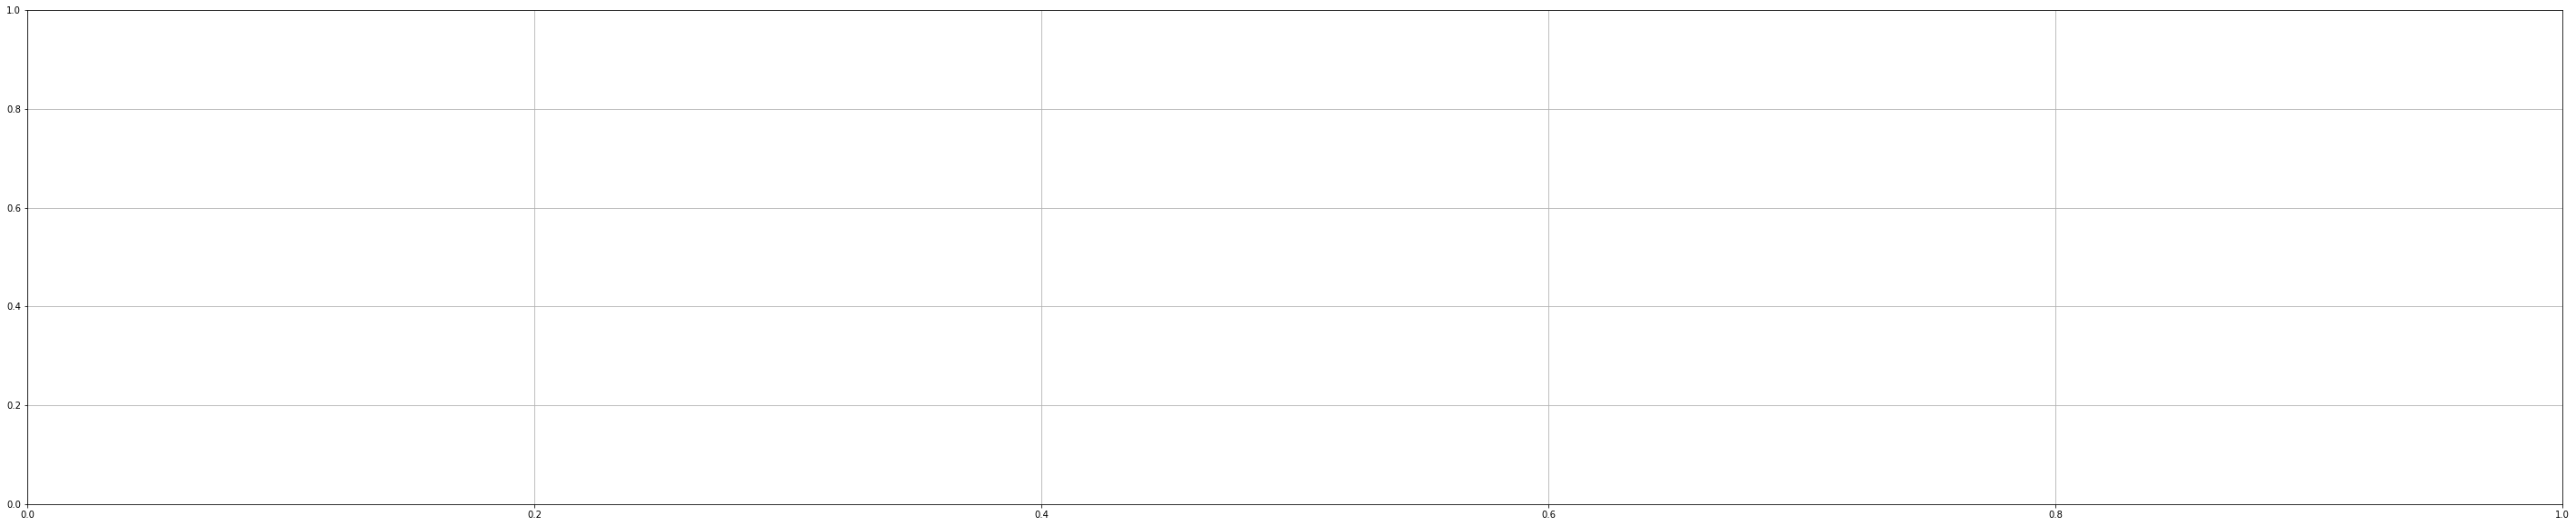

In [38]:
mask = datacittà2018['Kw']>=400

sm.graphics.tsa.plot_acf(results.resid[mask].dropna(), lags=100)
plt.show()

Sembra che i picchi nell'autocorrelazione siano dovuti principalmente ai consumi superiori a 300 kW, che si verificano solitamente in Estate ed Inverno (quindi con temperature più estreme), a orario aperto sia al pubblico che ai dipendenti

# Albero Decisionale
Numero massimo di foglie = 15

In [39]:
X = ['error', 'pubb', 'dip', 'temp']

Segrate 
R-sqared =  0.7605866327395383 




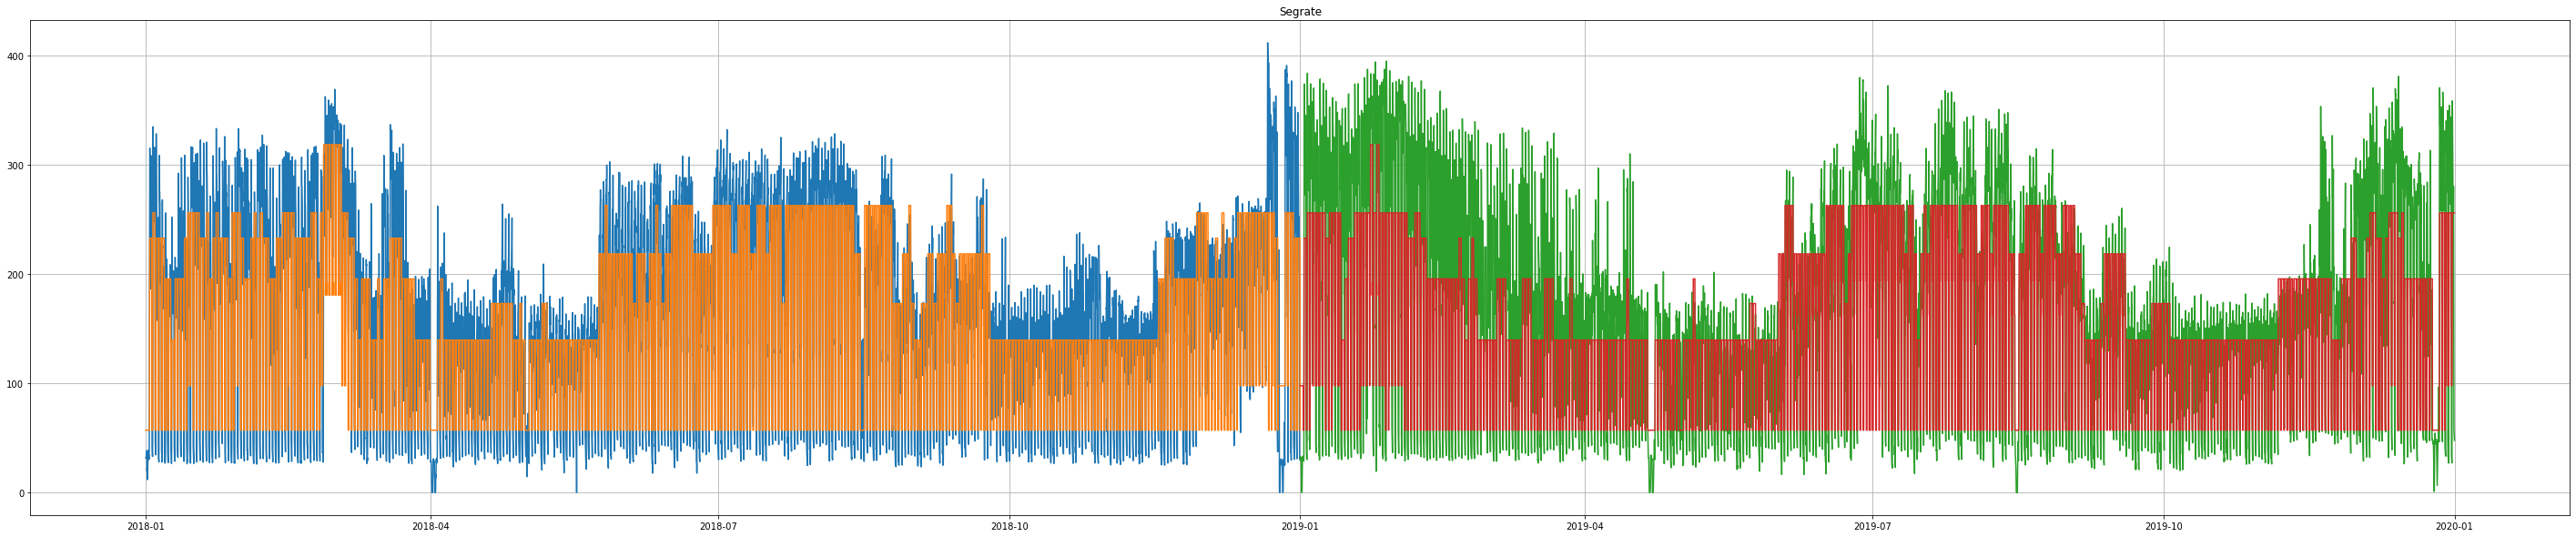

IndexError: list index out of range

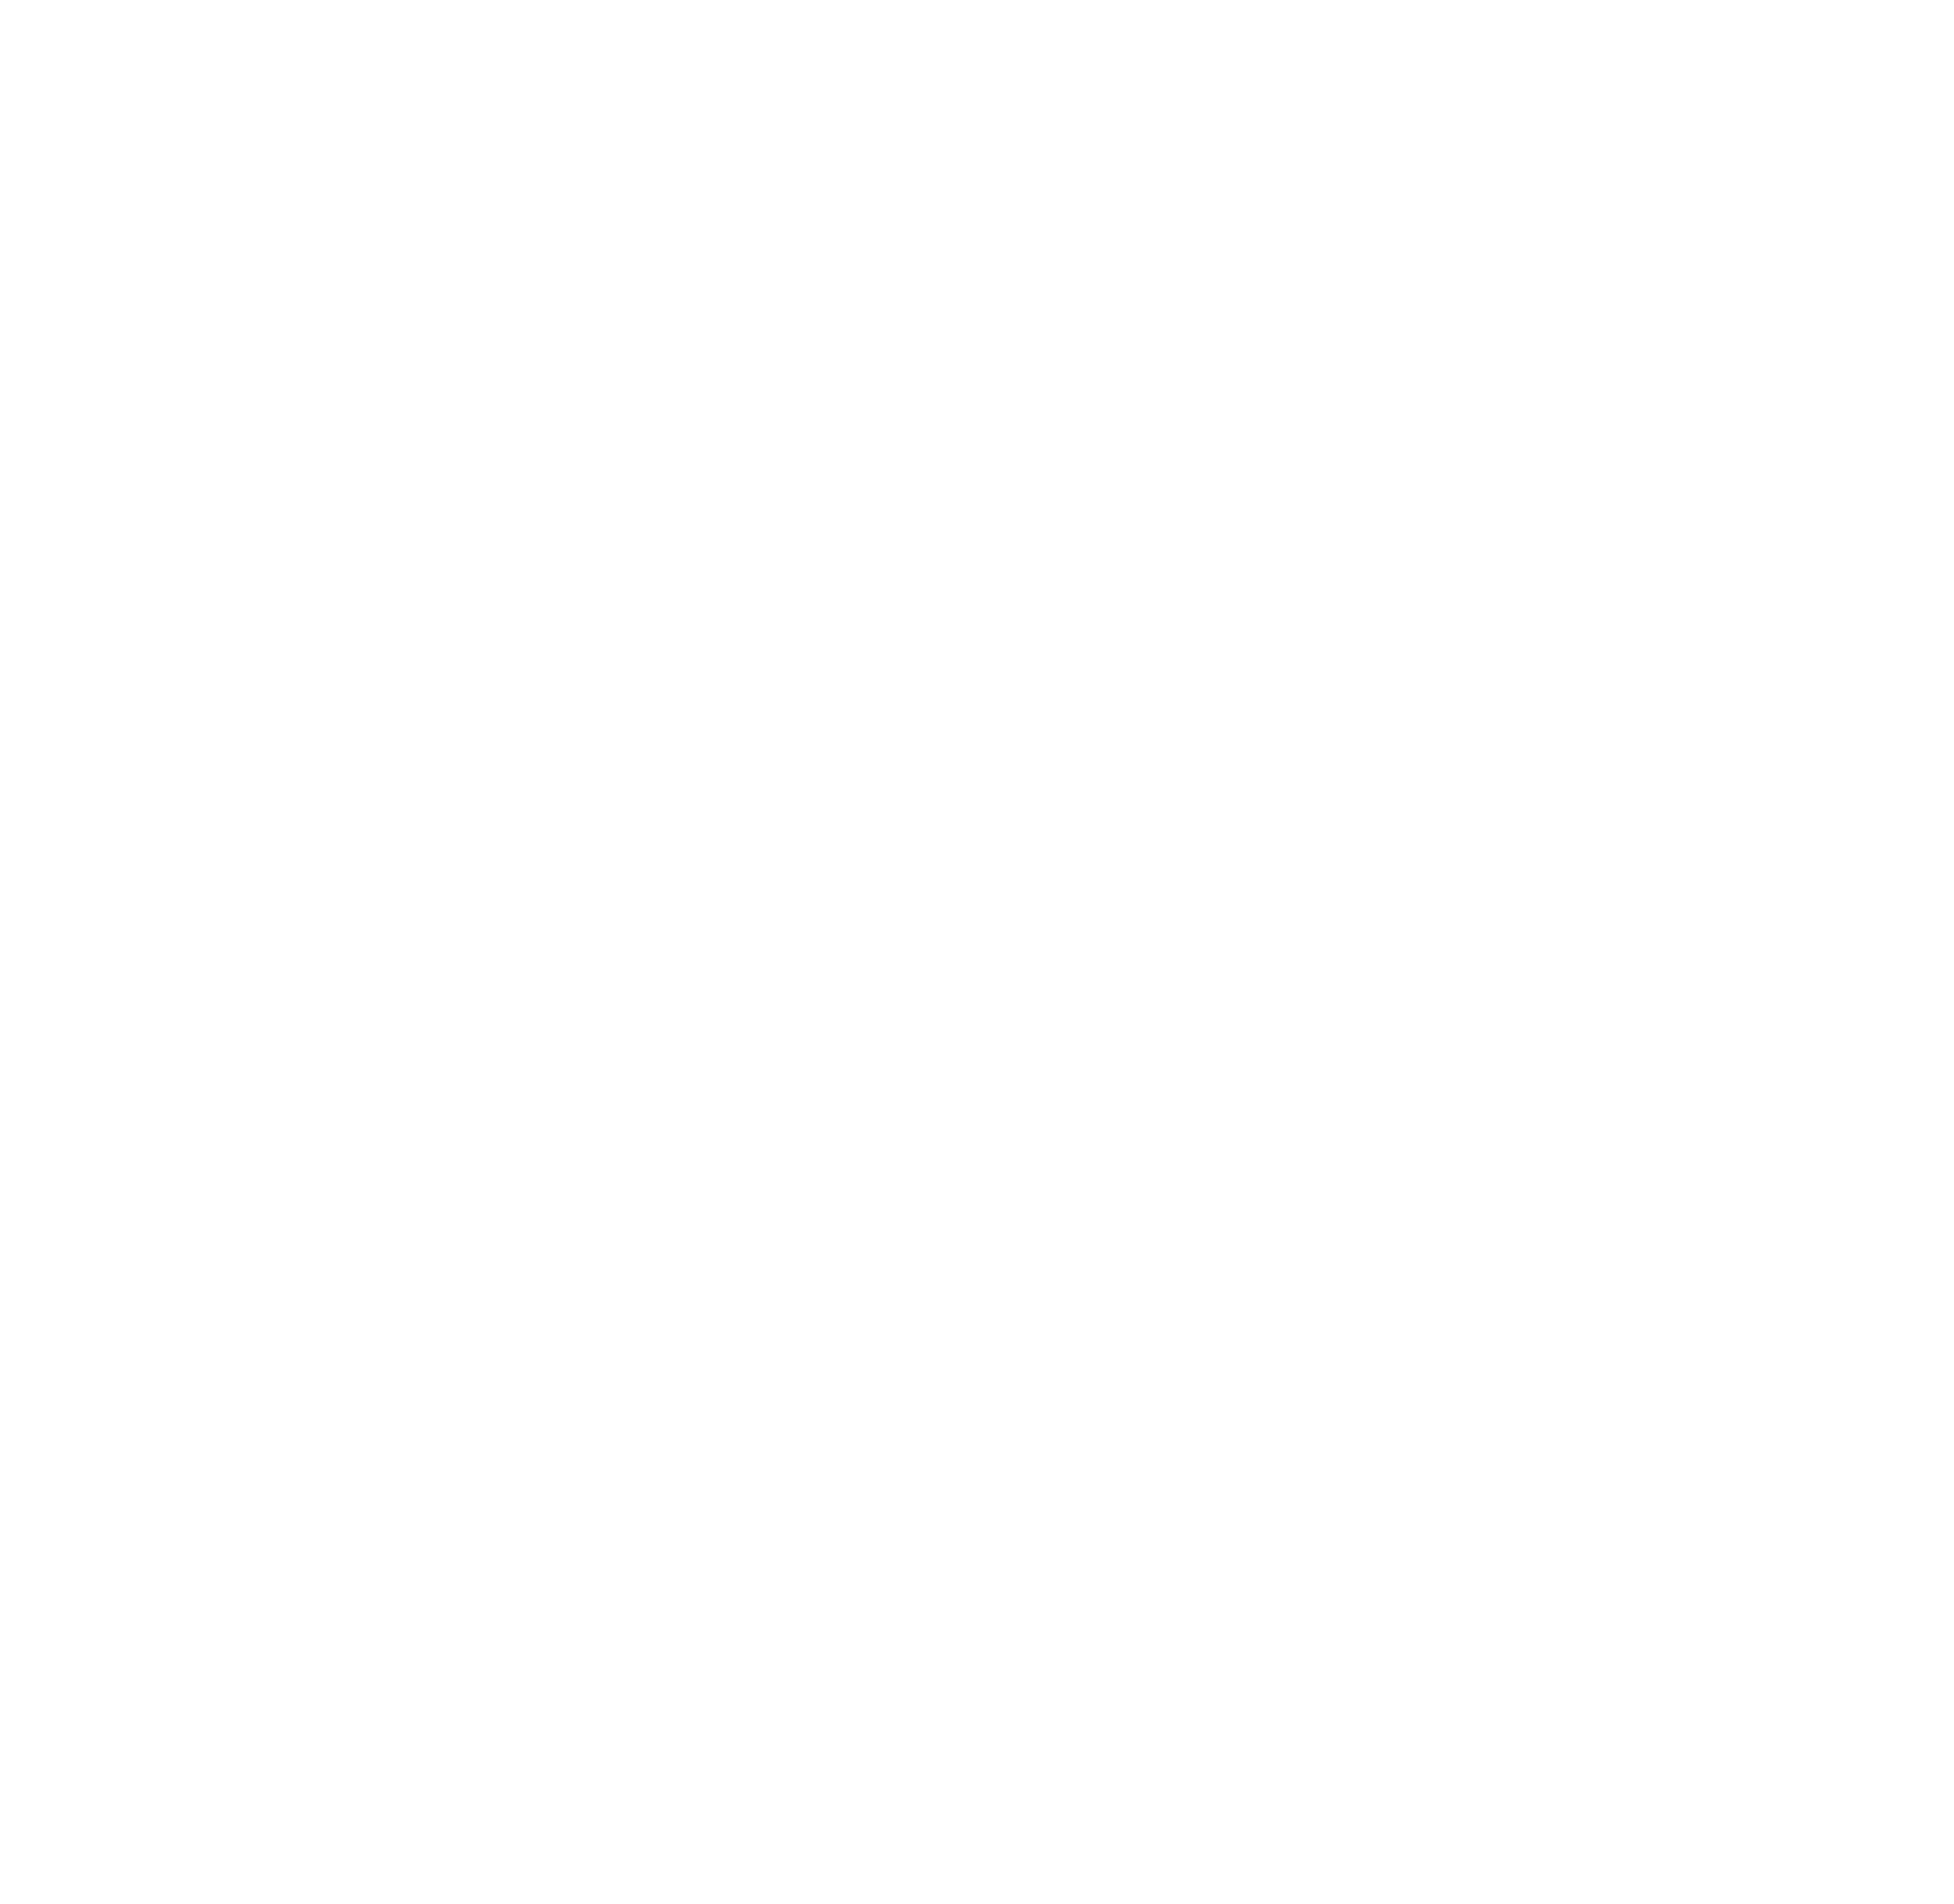

In [40]:
datacittà2018 = datacittà[datacittà['anno']==2018].dropna()
datacittà2019 = datacittà[datacittà['anno']==2019].dropna()

x = datacittà2018[X]
x1 = datacittà2019[X]
y = datacittà2018['Kw']
y1 = datacittà2019['Kw']

x = sm.add_constant(x)
x1 = sm.add_constant(x1)

model = DecisionTreeRegressor(max_leaf_nodes = 15)#max_depth=3, 
results = model.fit(x, y)

yhat = results.predict(x)
yhat = pd.Series(yhat, index=x.index)
pred = results.predict(x1)
pred = pd.Series(pred, index=x1.index)

results.rsquared = r_square(y, yhat)
print(città, '\nR-sqared = ', results.rsquared, '\n\n')


#pred = results.predict(x1)

plt.plot(datacittà2018['Kw'])
plt.plot(yhat)
plt.plot(datacittà2019['Kw'])
plt.plot(pred)
plt.title('{}'.format(città))
plt.show()

fig= plt.figure(figsize=(50,50))
plot_tree(model, feature_names=X, label='none', impurity=False, rounded=True, fontsize=20)
plt.show()

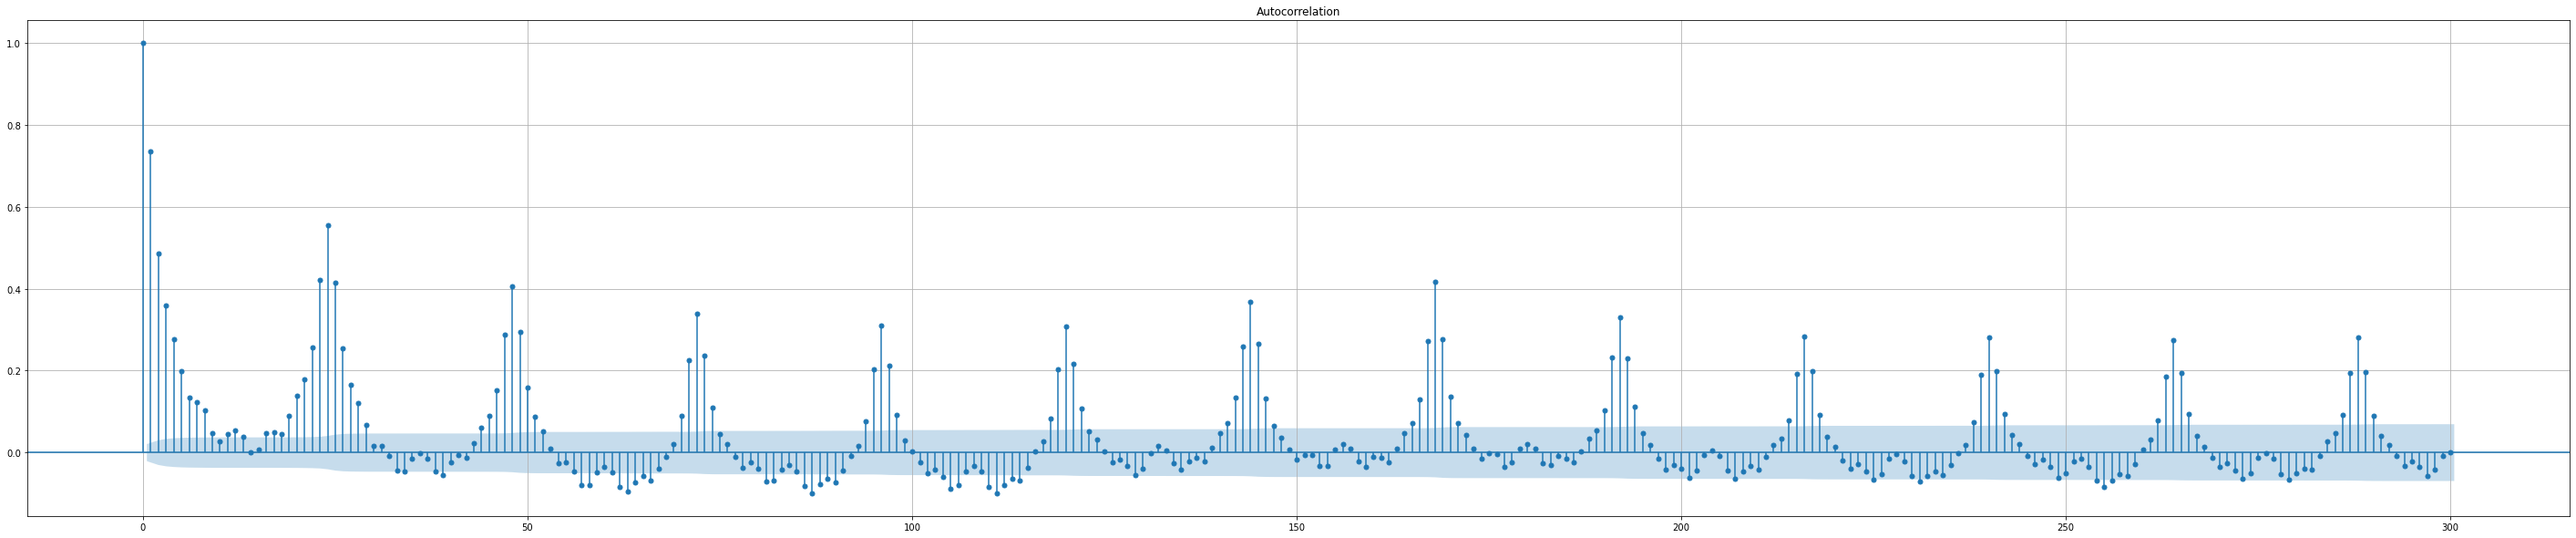

In [41]:
#Autocorrelazione dei residui

sm.graphics.tsa.plot_acf(y-yhat, lags=300)
plt.show()

# Random Forest
Numero massimo di foglie = 10

In [42]:
X = ['error', 'pubb', 'dip', 'temp']

Segrate 
R-sqared =  0.7264545414331173 




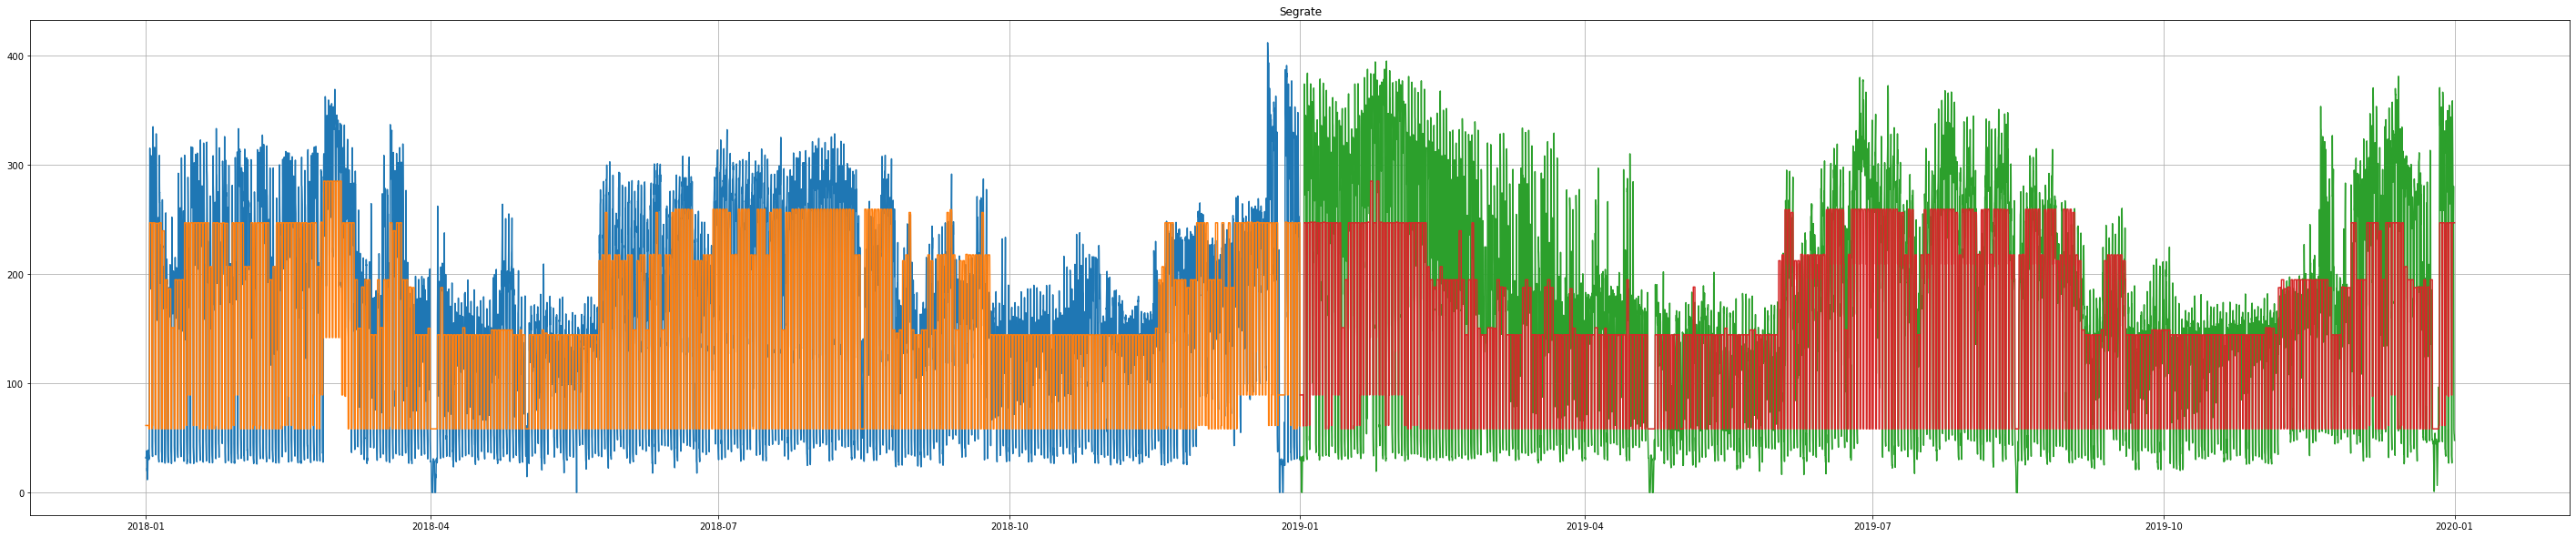

In [43]:
datacittà2018 = datacittà[datacittà['anno']==2018].dropna()
datacittà2019 = datacittà[datacittà['anno']==2019].dropna()

x = datacittà2018[X]
x1 = datacittà2019[X]
y = datacittà2018['Kw']
y1 = datacittà2019['Kw']

x = sm.add_constant(x)
x1 = sm.add_constant(x1)

model = RandomForestRegressor(max_leaf_nodes = 10)# max_depth=5, 
results = model.fit(x, y)

yhat = results.predict(x)
yhat = pd.Series(yhat, index=x.index)
pred = results.predict(x1)
pred = pd.Series(pred, index=x1.index)

results.rsquared = r_square(y, yhat)
print(città, '\nR-sqared = ', results.rsquared, '\n\n')


#pred = results.predict(x1)

plt.plot(datacittà2018['Kw'])
plt.plot(yhat)
plt.plot(datacittà2019['Kw'])
plt.plot(pred)
plt.title('{}'.format(città))
plt.show()

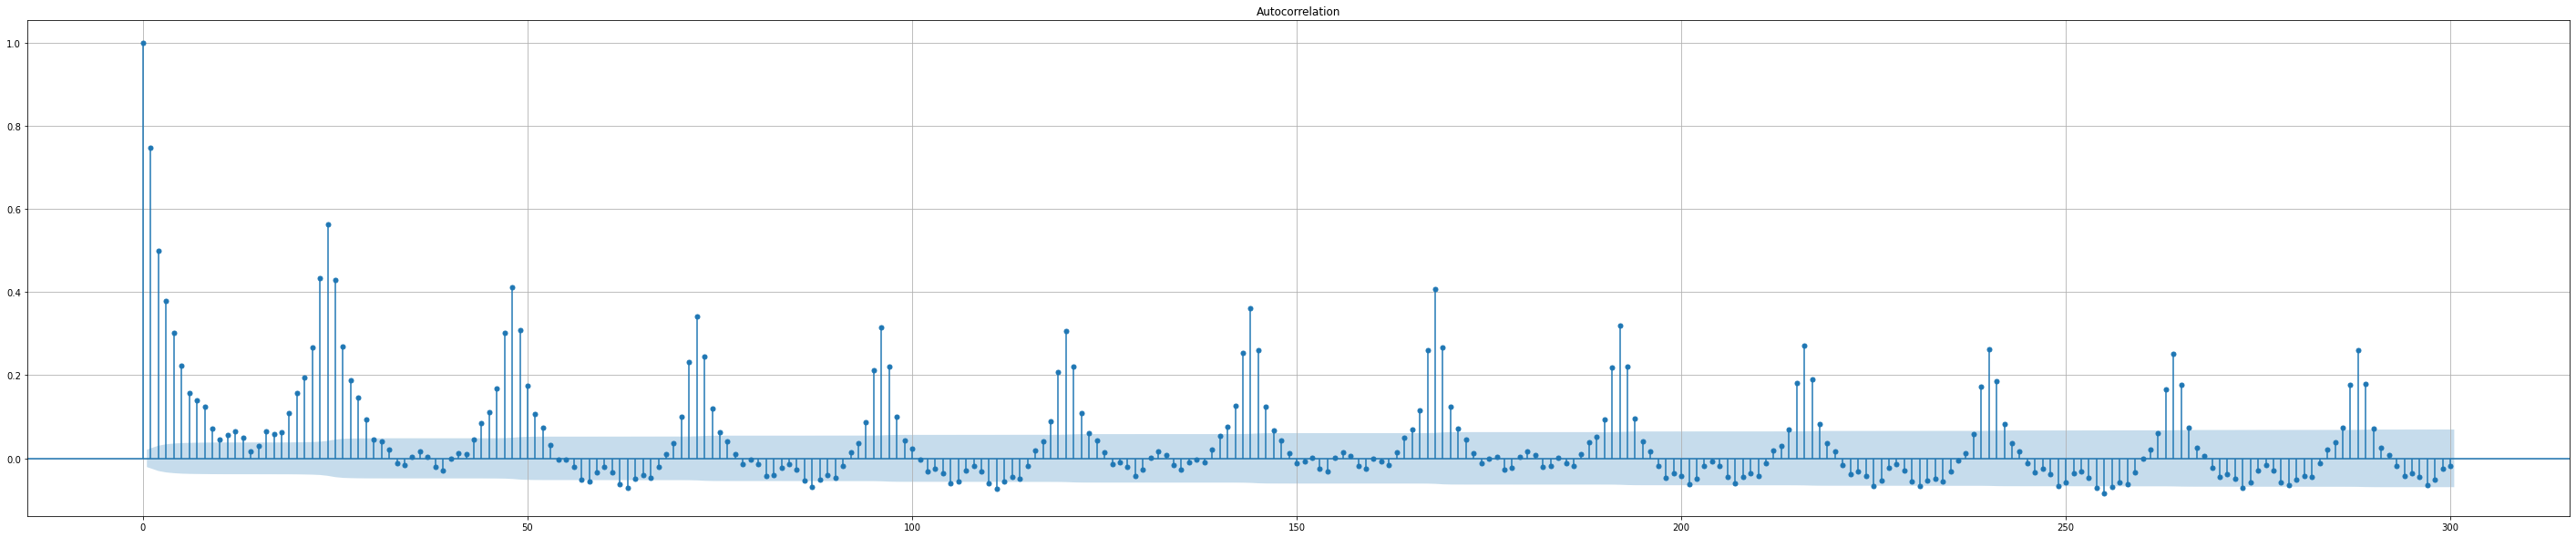

In [44]:
#Autocorrelazione dei residui

sm.graphics.tsa.plot_acf(y-yhat, lags=300)
plt.show()

# K-Neighbors Regressor
k=10

In [45]:
# Inserisco altre avariabili, come i cambiamenti e giorno/ora
X = ['error', 'pubb', 'dip', 'temp', 'led', 'fvt', 'bms', 'giorno della settimana', 'ora']

Segrate 
R-sqared on test set =  0.6638640690551384 




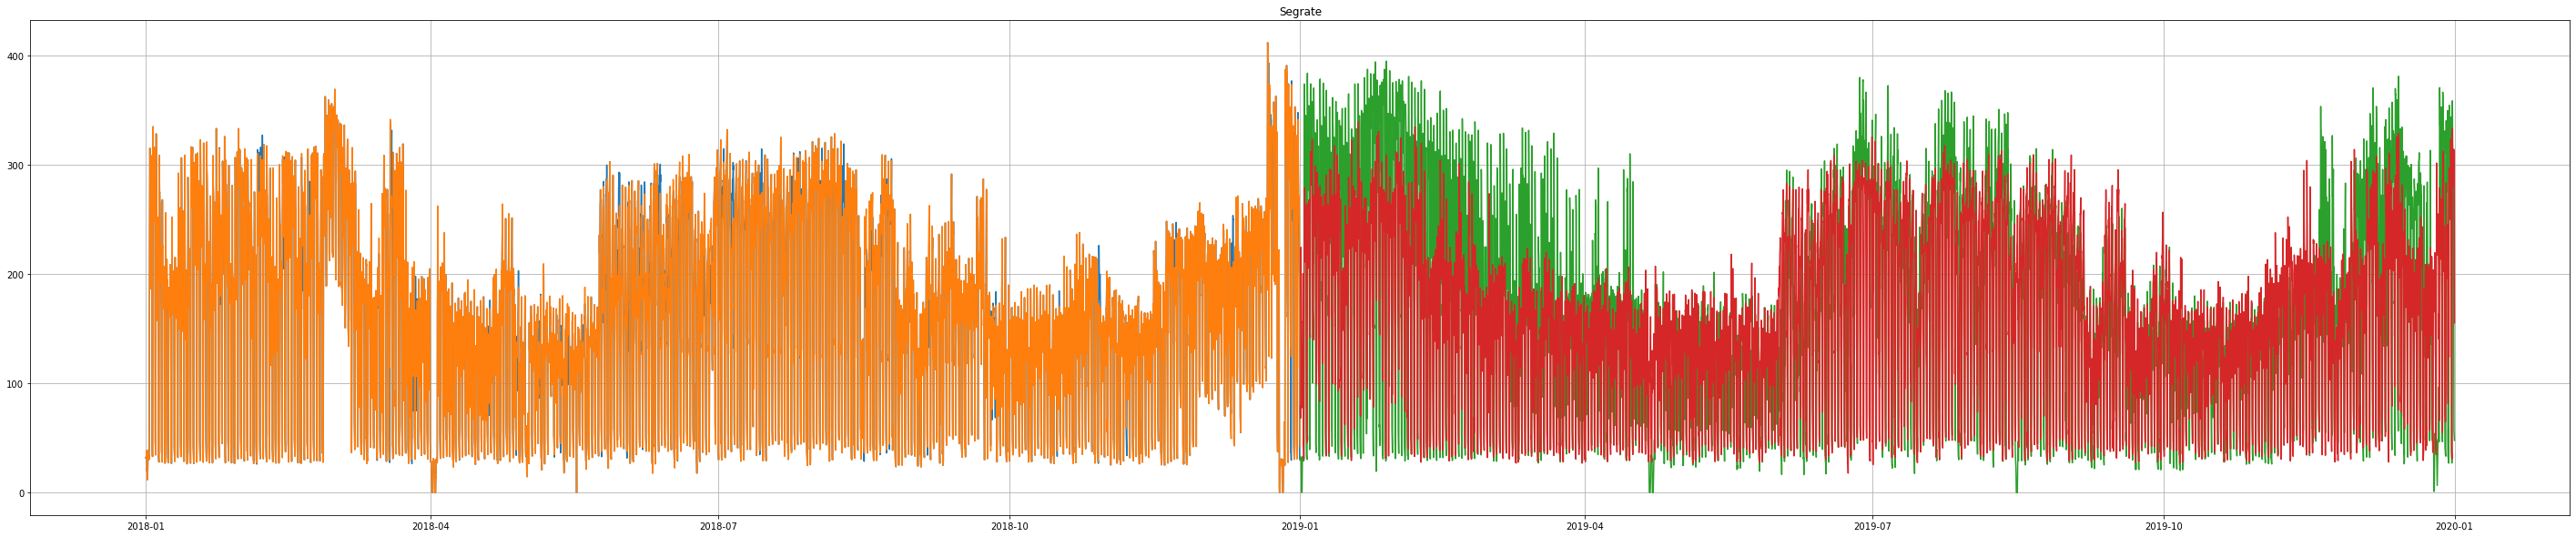

In [46]:
datacittà2018 = datacittà[datacittà['anno']==2018].dropna()
datacittà2019 = datacittà[datacittà['anno']==2019].dropna()

x = datacittà2018[X]
x1 = datacittà2019[X]
y = datacittà2018['Kw']
y1 = datacittà2019['Kw']

x = sm.add_constant(x)
x1 = sm.add_constant(x1)

model = KNeighborsRegressor(10, weights='distance') #uniform 
results = model.fit(x, y)

yhat = results.predict(x)
yhat = pd.Series(yhat, index=x.index)
pred = results.predict(x1)
pred = pd.Series(pred, index=x1.index)

results.rsquared = r_square(y1, pred)
print(città, '\nR-sqared on test set = ', results.rsquared, '\n\n')


#pred = results.predict(x1)

plt.plot(datacittà2018['Kw'])
plt.plot(yhat)
plt.plot(datacittà2019['Kw'])
plt.plot(pred)
plt.title('{}'.format(città))
plt.show()

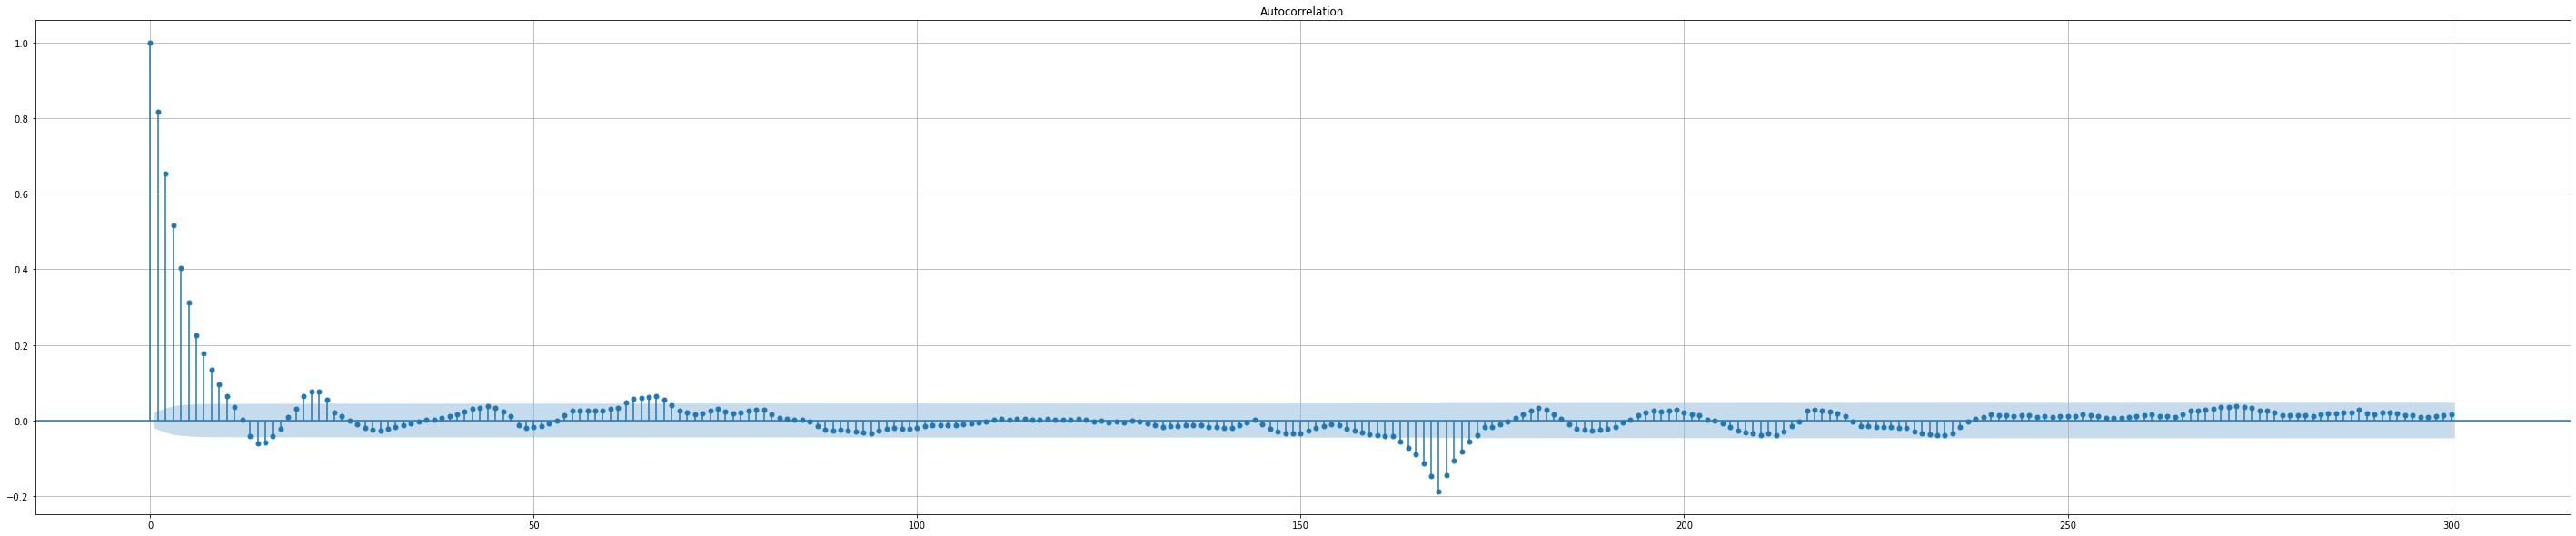

In [47]:
#Autocorrelazione dei residui

sm.graphics.tsa.plot_acf(y-yhat, lags=300)
plt.show()

# Autoregressivo
Lag = 30*24

Questo modello riesce ad eliminare l'autocorrelazione, ma a che costo?

In [48]:
X = ['error', 'pubb', 'dip', 'temp+', 'temp-']

Segrate 
R-sqared =  0.8616520814878899 




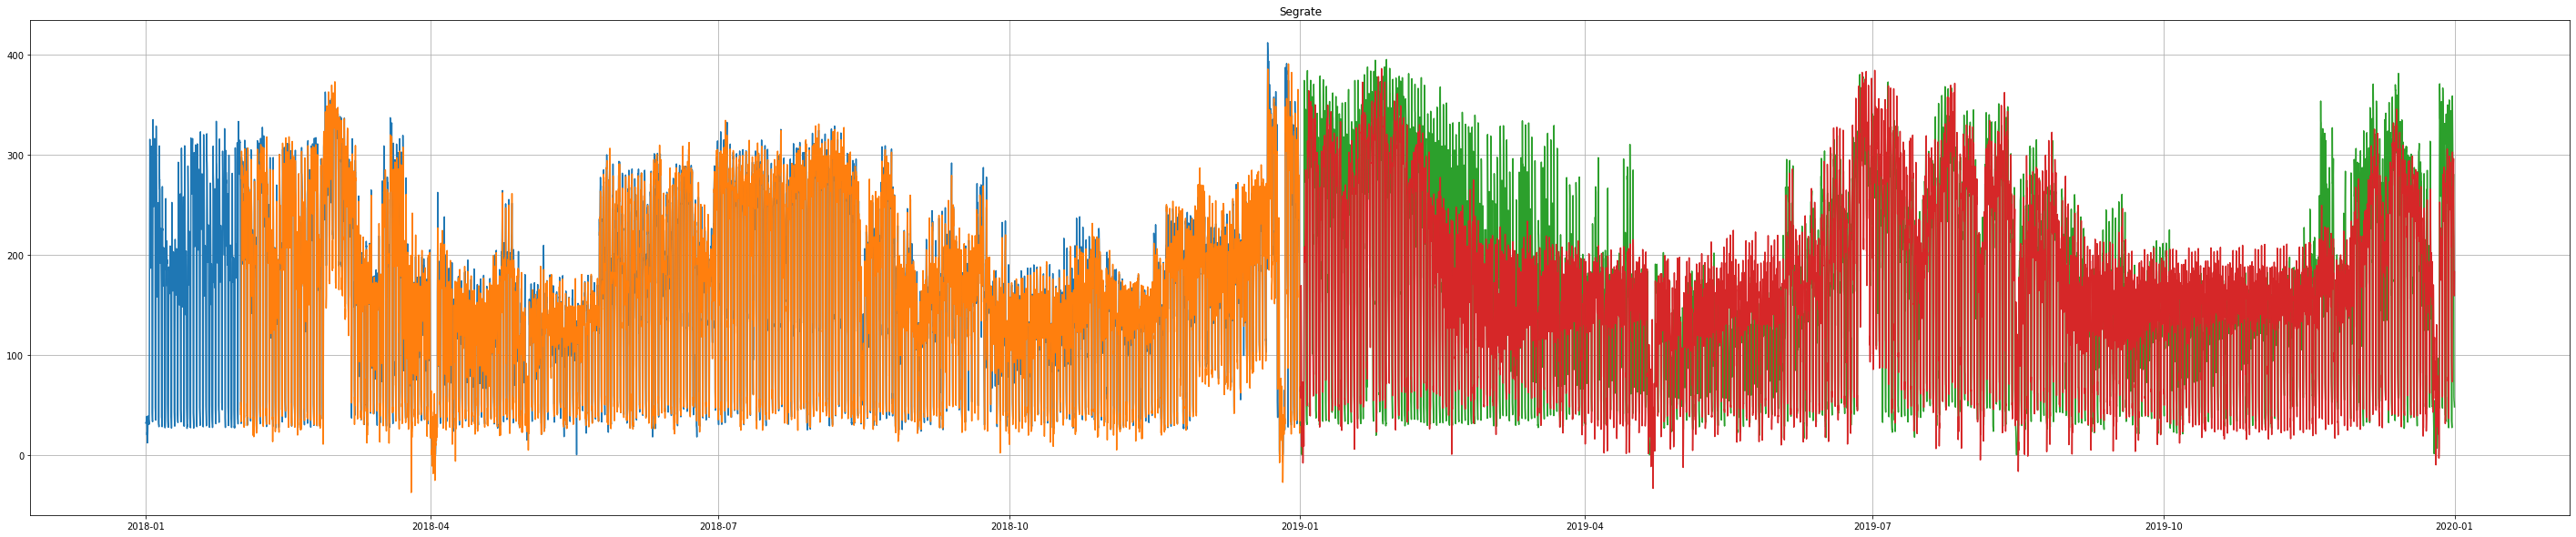

In [49]:
datacittà2018 = datacittà[datacittà['anno']==2018].dropna()
datacittà2019 = datacittà[datacittà['anno']==2019].dropna()

x = datacittà2018[X]
x1 = datacittà2019[X]
y = datacittà2018['Kw'].values
y1 = datacittà2019['Kw'].values

x = sm.add_constant(x)
x1 = sm.add_constant(x1)

model = AutoReg(y, 30*24, exog=x)
results = model.fit()
#print(città, '\n', results.summary(), '\n\n')

y = datacittà2018['Kw']
y1 = datacittà2019['Kw']

yhat = results.fittedvalues
pred = results.predict(start = len(y), end = len(y)+x1.shape[0]-1, exog_oos = x1)
pred.index = y1.index

results.rsquared = r_square(y, results.fittedvalues)
print(città, '\nR-sqared = ', results.rsquared, '\n\n')


#pred = results.predict(x1)

plt.plot(datacittà2018['Kw'])
plt.plot(yhat)
plt.plot(datacittà2019['Kw'])
plt.plot(pred)
plt.title('{}'.format(città))
plt.show()

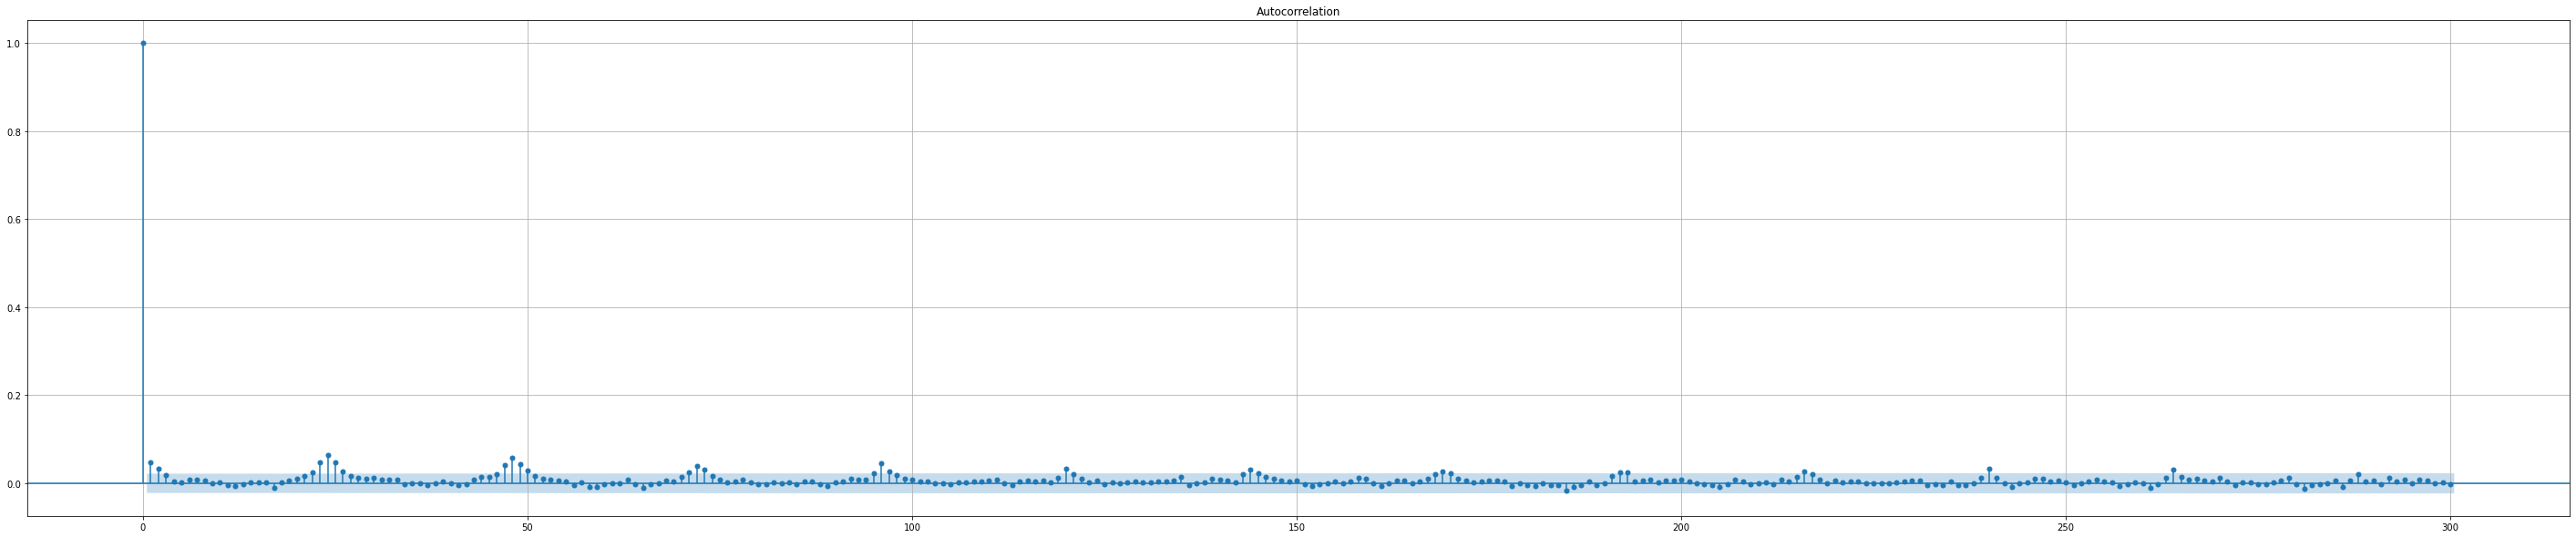

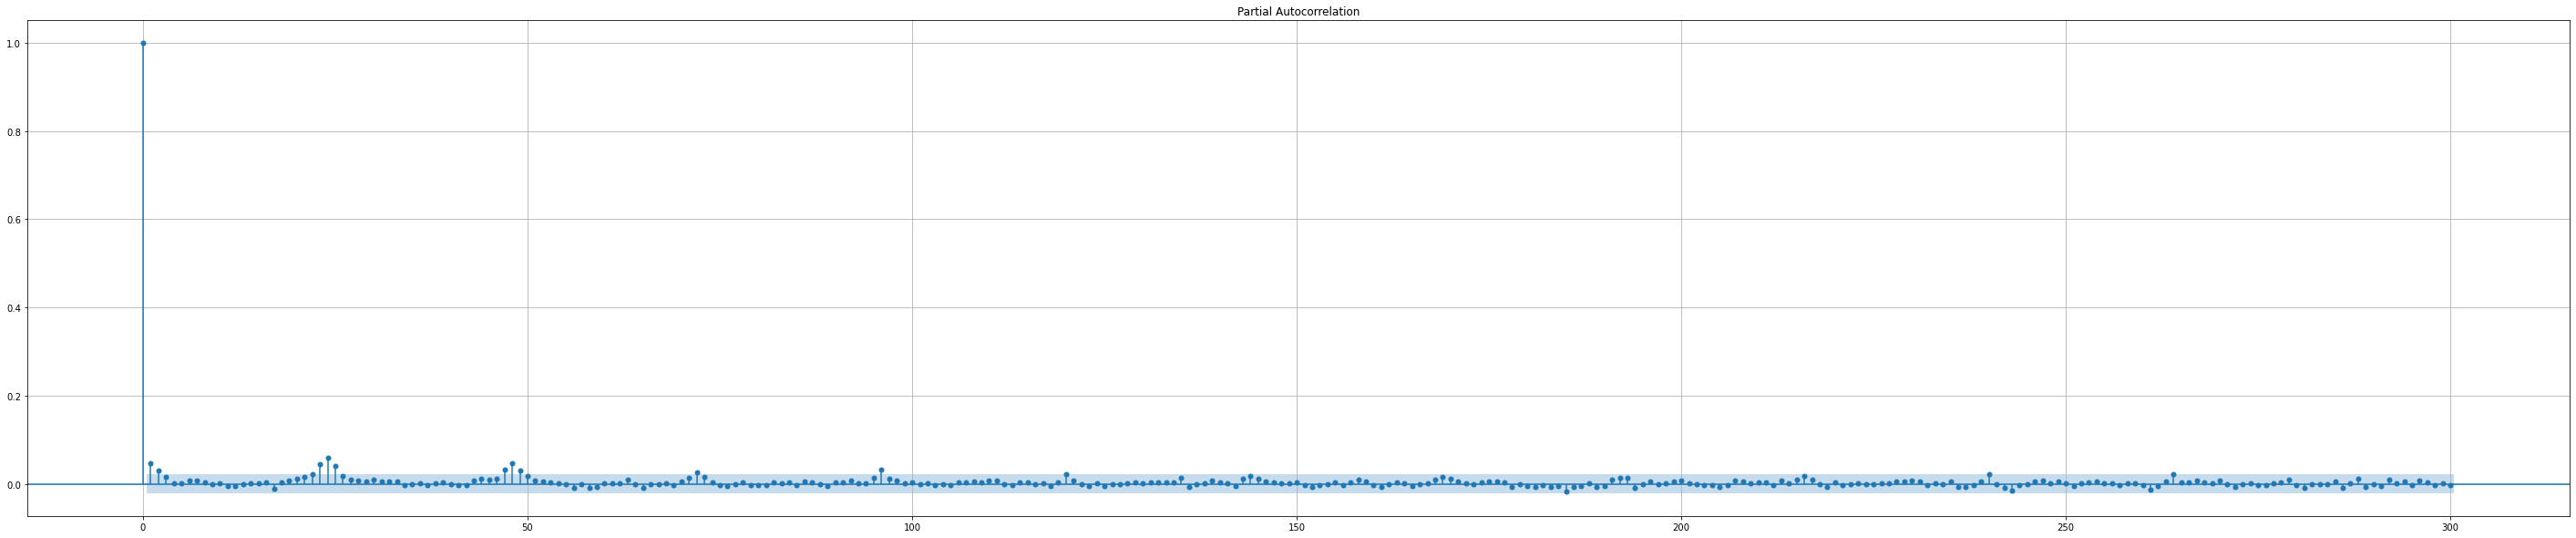

In [50]:
#Autocorrelazione dei residui

sm.graphics.tsa.plot_acf(results.resid.dropna(), lags=300)
sm.graphics.tsa.plot_pacf(results.resid.dropna(), lags=300)
plt.show()

In [51]:
# Funzione di calcolo per R-quadro
def r_square(y, y_hat):
    ess = np.sum(np.square(y_hat - np.mean(y)))
    tss = np.sum(np.square(y - np.mean(y)))
    return ess/tss

In [52]:
#temp+ e temp- per tutte le città

for città in data_edit:
    temp_list = np.sort(data_edit[città].dropna()['temp'].unique())
    cons_list = []
    for temp in np.sort(temp_list):
        cons = np.nanmax(data_edit[città][data_edit[città]['temp'] == temp]['Kw'])
        cons_list.append(cons)

    ball = np.round(int(np.sqrt(len(cons_list))))
    if ball%2 !=1:
        ball = ball+1
    ball = int(ball)
    poly_y = scipy.signal.savgol_filter(cons_list, ball, 1)

    t0 = np.sort(data_edit[città]['temp'].unique())[np.argmin(poly_y)]
    c0 = min(poly_y)

    data_edit[città]['temp+'] = data_edit[città]['temp']-t0
    data_edit[città]['temp-'] = t0 - data_edit[città]['temp']

    maskt0p = data_edit[città]['temp+']<0
    maskt0n = data_edit[città]['temp-']<0
    maskc0 = data_edit[città]['Kw']<c0

    data_edit[città].loc[maskt0p, 'temp+']=0
    data_edit[città].loc[maskt0n, 'temp-']=0
    data_edit[città].loc[maskc0, 'temp+']=0
    data_edit[città].loc[maskc0, 'temp-']=0

In [53]:
X = ['pubb', 'dip', 'temp+', 'temp-', 'error']





Media: 0.8591341128720641
Mediana: 0.9515031129506817


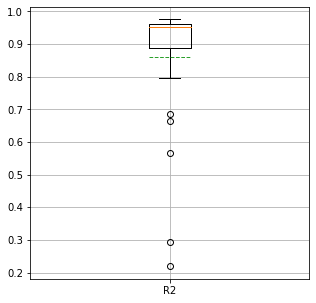

In [54]:
# Modello lineare con y = sqrt(Kw)
R2 = []
for città in data_edit:
    datacittà = data_edit[città].dropna()

    x = datacittà[X]#+['giorno della settimana', 'ora']]
    #x = pd.get_dummies(x, prefix='WDay', columns=['giorno della settimana'])
    #x = pd.get_dummies(x, prefix='Hour', columns=['ora'])
    y = datacittà['Kw']

    #x = sm.add_constant(x)
    model = sm.OLS(y,x)
    results = model.fit()
    """
    plt.plot((y)**2)
    plt.plot((results.fittedvalues)**2)
    plt.title(città)
    plt.show()
    """
    #print(results.summary())
    #results.rsquared = r_square(y, results.fittedvalues)
    R2.append(results.rsquared)
    #if results.rsquared<.75:
    #    print(città, results.rsquared, '\n')

print('\n\n\n\nMedia:', np.mean(R2))
print('Mediana:', np.median(R2))


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.boxplot(R2, labels=['R2'], meanline=True, showmeans=True)
fig.savefig('OLS_boxplot.png')
plt.show()





Media: 0.8248294290413778
Mediana: 0.867156752582837


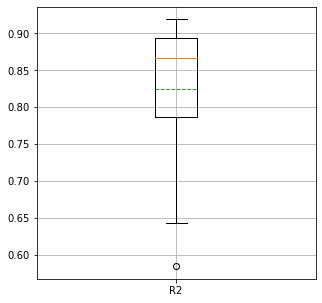

In [55]:
# Modello lineare con y = sqrt(Kw)
R2 = []
for città in data_edit:
    datacittà = data_edit[città].dropna()

    x = datacittà[X+['giorno della settimana', 'ora']]
    x = pd.get_dummies(x, prefix='WDay', columns=['giorno della settimana'])
    x = pd.get_dummies(x, prefix='Hour', columns=['ora'])
    y = datacittà['Kw']

    #x = sm.add_constant(x)
    model = sm.OLS(y,x)
    results = model.fit()
    """
    plt.plot((y)**2)
    plt.plot((results.fittedvalues)**2)
    plt.title(città)
    plt.show()
    """
    #print(results.summary())
    #results.rsquared = r_square(y, results.fittedvalues)
    R2.append(results.rsquared)
    #if results.rsquared<.75:
    #    print(città, results.rsquared, '\n')

print('\n\n\n\nMedia:', np.mean(R2))
print('Mediana:', np.median(R2))


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.boxplot(R2, labels=['R2'], meanline=True, showmeans=True)
fig.savefig('OLS_boxplot.png')
plt.show()

Carate Differita 0.6705539754500176 

Misterbianco Corpo L 0.6067493979895147 

Orbassano Differita 0.6671636736665376 

Parma Differita 0.5376857807439622 

Segrate Edilizia 0.6431676175671079 





Media: 0.8168209135600246
Mediana: 0.8575004786901057


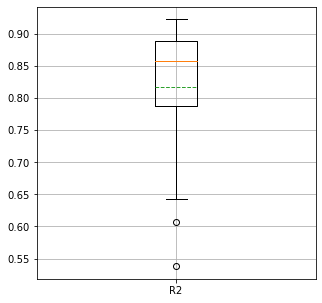

In [56]:
# Modello lineare con y = sqrt(Kw)
R2 = []
for città in data_edit:
    datacittà = data_edit[città].dropna()

    x = datacittà[X+['giorno della settimana', 'ora']]
    x = pd.get_dummies(x, prefix='WDay', columns=['giorno della settimana'])
    x = pd.get_dummies(x, prefix='Hour', columns=['ora'])
    y = np.sqrt(datacittà['Kw'])

    #x = sm.add_constant(x)
    model = sm.OLS(y,x)
    results = model.fit()
    """
    plt.plot((y)**2)
    plt.plot((results.fittedvalues)**2)
    plt.title(città)
    plt.show()
    """
    #print(results.summary())
    #results.rsquared = r_square(y, results.fittedvalues)
    R2.append(results.rsquared)
    if results.rsquared<.75:
        print(città, results.rsquared, '\n')

print('\n\n\n\nMedia:', np.mean(R2))
print('Mediana:', np.median(R2))


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.boxplot(R2, labels=['R2'], meanline=True, showmeans=True)
fig.savefig('OLS_boxplot.png')
plt.show()

Carate Differita 0.6882904348651634 

Misterbianco Corpo L 0.6402099600129544 

Orbassano Differita 0.7071237864618837 

Parma Differita 0.5845079421976079 

Pero 0.7485247754602214 

Segrate Edilizia 0.6744923255326699 





Media: 0.8240900334765027
Mediana: 0.8669139473206513


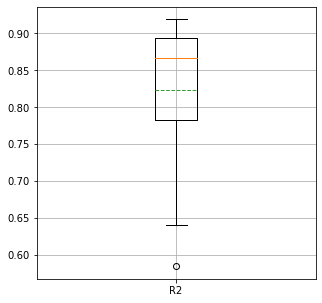

In [57]:
# Modello lineare con y = sqrt(Kw)
R2 = []
for città in data_edit:
    datacittà = data_edit[città].dropna()

    x = datacittà[X+['giorno della settimana', 'ora']]
    x = pd.get_dummies(x, prefix='WDay', columns=['giorno della settimana'])
    x = pd.get_dummies(x, prefix='Hour', columns=['ora'])
    y = datacittà['Kw']

    #x = sm.add_constant(x)
    coef, res = scipy.optimize.nnls(x, y)
    #print(dict(zip(x.keys(), coef)))
    yhat = x.dot(coef)
    #print(pred)
    #print(città, '\t', r_square(y, yhat))
    
    #print(results.summary())
    #results.rsquared = r_square(y, results.fittedvalues)
    results.rsquared = r_square(y, yhat)
    R2.append(results.rsquared)
    if results.rsquared<.75:
        print(città, results.rsquared, '\n')

print('\n\n\n\nMedia:', np.mean(R2))
print('Mediana:', np.median(R2))


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.boxplot(R2, labels=['R2'], meanline=True, showmeans=True)
plt.show()

Carate Differita 0.6651813806804432 

Misterbianco Corpo L 0.3415439422837259 

Orbassano Differita 0.5616921553203099 

Parma Differita 0.26899651558598964 

Pero 0.6841274875175617 

Segrate Edilizia 0.21862612376189097 

Sesto Fiorentino 0.7179114063145927 





Media: 0.7640195291126456
Mediana: 0.8391415829283577


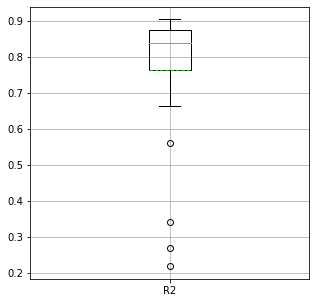

In [58]:
# Modello lineare con y = sqrt(Kw)
R2 = []
for città in data_edit:
    datacittà = data_edit[città].dropna()

    x = datacittà[X]#+['giorno della settimana', 'ora']]
    #x = pd.get_dummies(x, prefix='WDay', columns=['giorno della settimana'])
    #x = pd.get_dummies(x, prefix='Hour', columns=['ora'])
    y = datacittà['Kw']

    #x = sm.add_constant(x)
    coef, res = scipy.optimize.nnls(x, y)
    #print(dict(zip(x.keys(), coef)))
    yhat = x.dot(coef)
    #print(pred)
    #print(città, '\t', r_square(y, yhat))
    
    #print(results.summary())
    #results.rsquared = r_square(y, results.fittedvalues)
    #results.rsquared = r_square(y, yhat)
    R2.append(r_square(y, yhat))
    if r_square(y, yhat)<.75:
        print(città, r_square(y, yhat), '\n')

print('\n\n\n\nMedia:', np.mean(R2))
print('Mediana:', np.median(R2))


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.boxplot(R2, labels=['R2'], meanline=True, showmeans=True)
plt.show()

Carate Differita 0.6882904348651634 

Misterbianco Corpo L 0.6402099600129544 

Orbassano Differita 0.7071237864618837 

Parma Differita 0.5845079421976079 

Pero 0.7485247754602214 

Segrate Edilizia 0.6744923255326699 





Media: 0.8240900334765027
Mediana: 0.8669139473206513


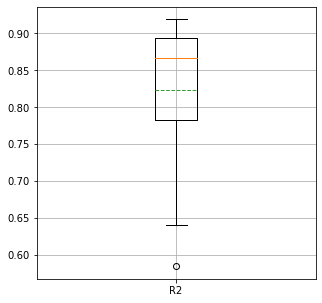

In [59]:
# Modello lineare con y = sqrt(Kw)
R2 = []
for città in data_edit:
    datacittà = data_edit[città].dropna()

    x = datacittà[X+['giorno della settimana', 'ora']]
    x = pd.get_dummies(x, prefix='WDay', columns=['giorno della settimana'])
    x = pd.get_dummies(x, prefix='Hour', columns=['ora'])
    y = datacittà['Kw']

    #x = sm.add_constant(x)
    coef, res = scipy.optimize.nnls(x, y)
    #print(dict(zip(x.keys(), coef)))
    yhat = x.dot(coef)
    #print(pred)
    #print(città, '\t', r_square(y, yhat))
    
    #print(results.summary())
    #results.rsquared = r_square(y, results.fittedvalues)
    #results.rsquared = r_square(y, yhat)
    R2.append(r_square(y, yhat))
    if r_square(y, yhat)<.75:
        print(città, r_square(y, yhat), '\n')

print('\n\n\n\nMedia:', np.mean(R2))
print('Mediana:', np.median(R2))


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.boxplot(R2, labels=['R2'], meanline=True, showmeans=True)
plt.show()

In [60]:
# Modello lineare con y = sqrt(Kw)
for città in data_edit:
    datacittà = data_edit[città].dropna()

    x = datacittà[X+['giorno della settimana', 'ora']]
    x = pd.get_dummies(x, prefix='WDay', columns=['giorno della settimana'])
    x = pd.get_dummies(x, prefix='Hour', columns=['ora'])
    y = np.sqrt(datacittà['Kw'])

    #x = sm.add_constant(x)
    model = sm.OLS(y,x)
    results = model.fit()

    print(np.mean(results.resid), np.var(results.resid))
    """
    plt.plot(results.resid)
    plt.title(città)
    plt.show()

    sm.graphics.tsa.plot_acf(results.resid.dropna(), lags=300)
    plt.title(città)
    plt.show()
    """
    

4.086847692474483e-14 1.0261757378241467
-5.636815816282467e-14 1.027379019439684
4.571914219059502e-14 1.9673083328733962
-1.3511917416150966e-14 0.13820035158954197
5.0434267558109423e-14 2.11140992294229
-5.25890997083469e-14 2.571779585565998
-1.3388667133849868e-15 2.2109039175104175
4.128898561036585e-15 2.226734154235961
-9.631168240494949e-14 1.698422874112036
5.4827638911179987e-14 2.8867161941274615
2.2887477068973817e-13 2.6505097056086027
-0.0004034813107505825 0.19307036001919026
1.7744555555357253e-14 1.0810100873259594
1.8083091235832984e-12 2.6406880345355237
-0.0069688612190657315 0.37004342435479953
-2.5500783750641427e-14 2.261601757467244
0.007892993974849204 0.31420547000711657
1.5147567474776453e-14 1.4235430658514114
-7.126976471511635e-15 1.979037918988608
2.939513146059076e-14 1.6428278518531032
1.3762983378674993e-13 2.1616780101827135
-0.0002795215481844805 0.3343665960084721
3.90363485932537e-14 1.5340514294949112
4.954671638077912e-14 1.7240969600854914
2.4

In [61]:
X = ['pubb', 'dip', 'temp', 'error']

[0.5862006076288084, 0.5859751091090267, 0.5888267044176992, 0.5897489545295814, 0.5905933952853276, 0.5890198837252615]


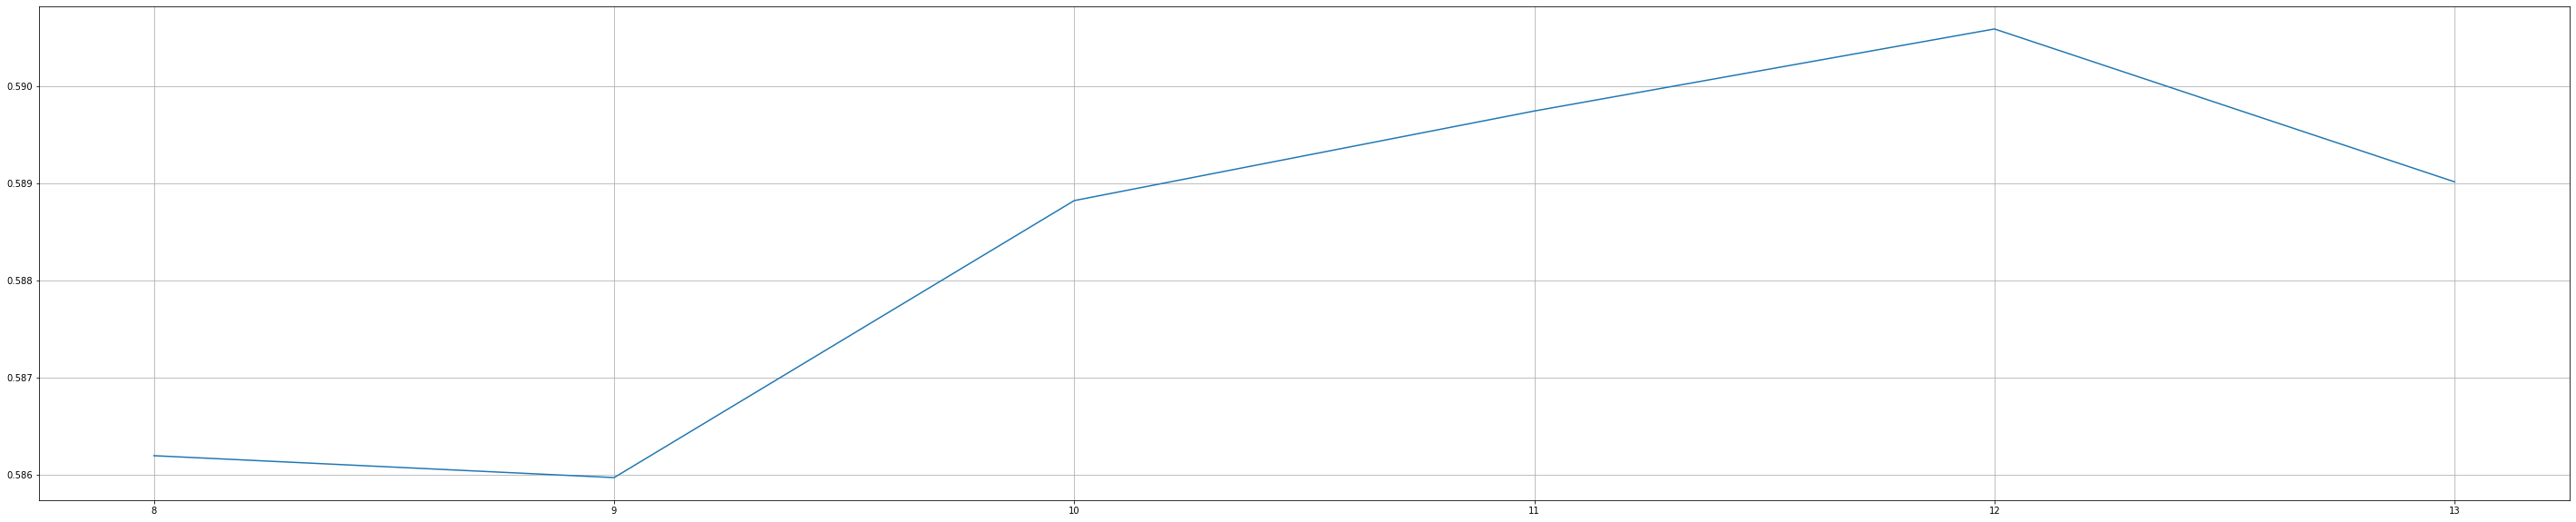

In [62]:
num_leaves = range(8,14)
scores = []
for i in num_leaves:
    i_scores = []
    for città in data_edit:
        datacittà = data_edit[città].dropna()
        x = datacittà[X]
        y = datacittà['Kw']
        
        model = DecisionTreeRegressor(max_leaf_nodes = i)
        città_scores = cross_val_score(model, x, y, cv=5)
        città_score = np.nanmean(città_scores)
        i_scores.append(città_score)
    i_score = np.nanmean(i_scores)
    scores.append(i_score)
print(scores)
plt.plot(num_leaves, scores)

In [63]:
parameters = {'n_estimators':[3,5,8,10,15,20,25,50,75,100,125,150], 'max_leaf_nodes':[10,12,15,17,20,23,25,27,30,35]}
clf = GridSearchCV(RandomForestRegressor(), parameters, n_jobs=-1)
clf.fit(X=x, y=y)
RF_model = clf.best_estimator_
#print(clf.cv_results_)
print (clf.best_score_, clf.best_params_) 

0.7009146299923121 {'max_leaf_nodes': 27, 'n_estimators': 8}


In [67]:
X = ['error', 'pubb', 'dip', 'temp+', 'temp-']

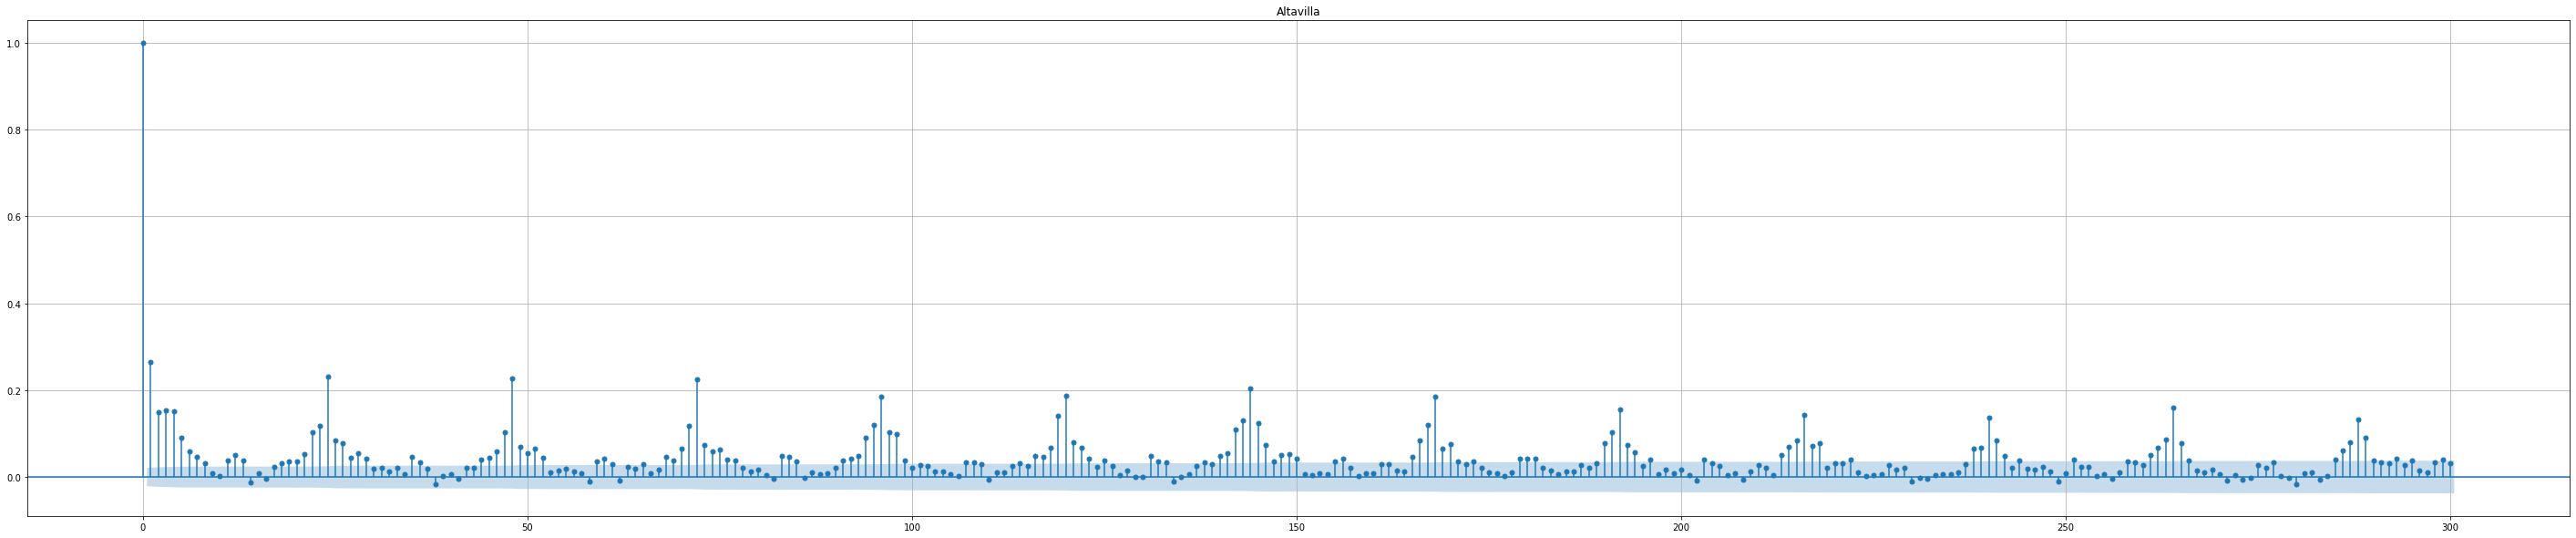

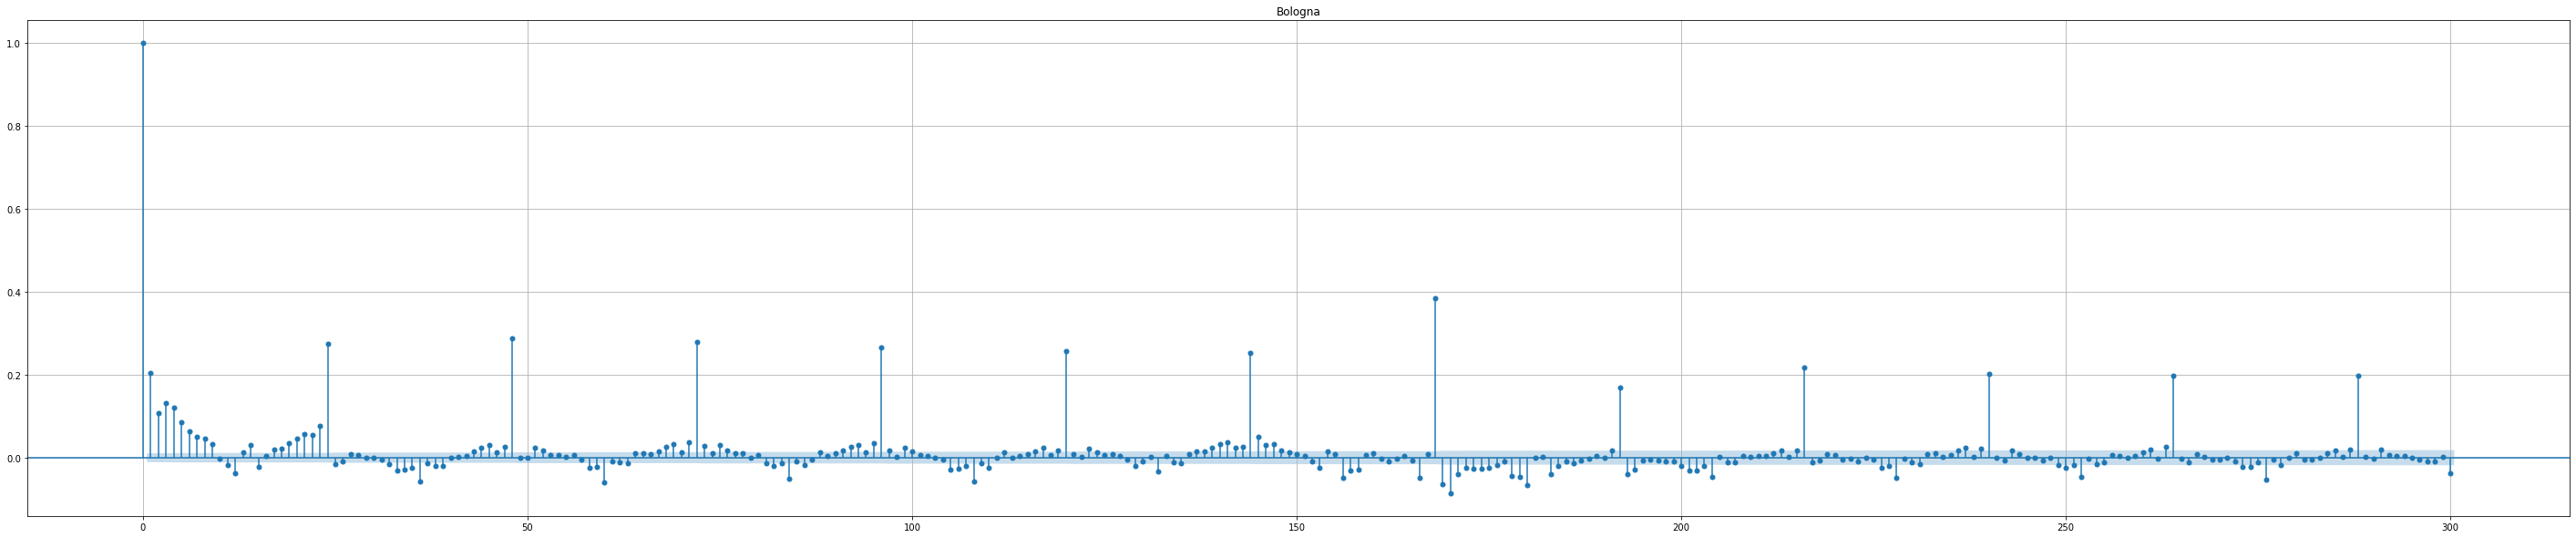

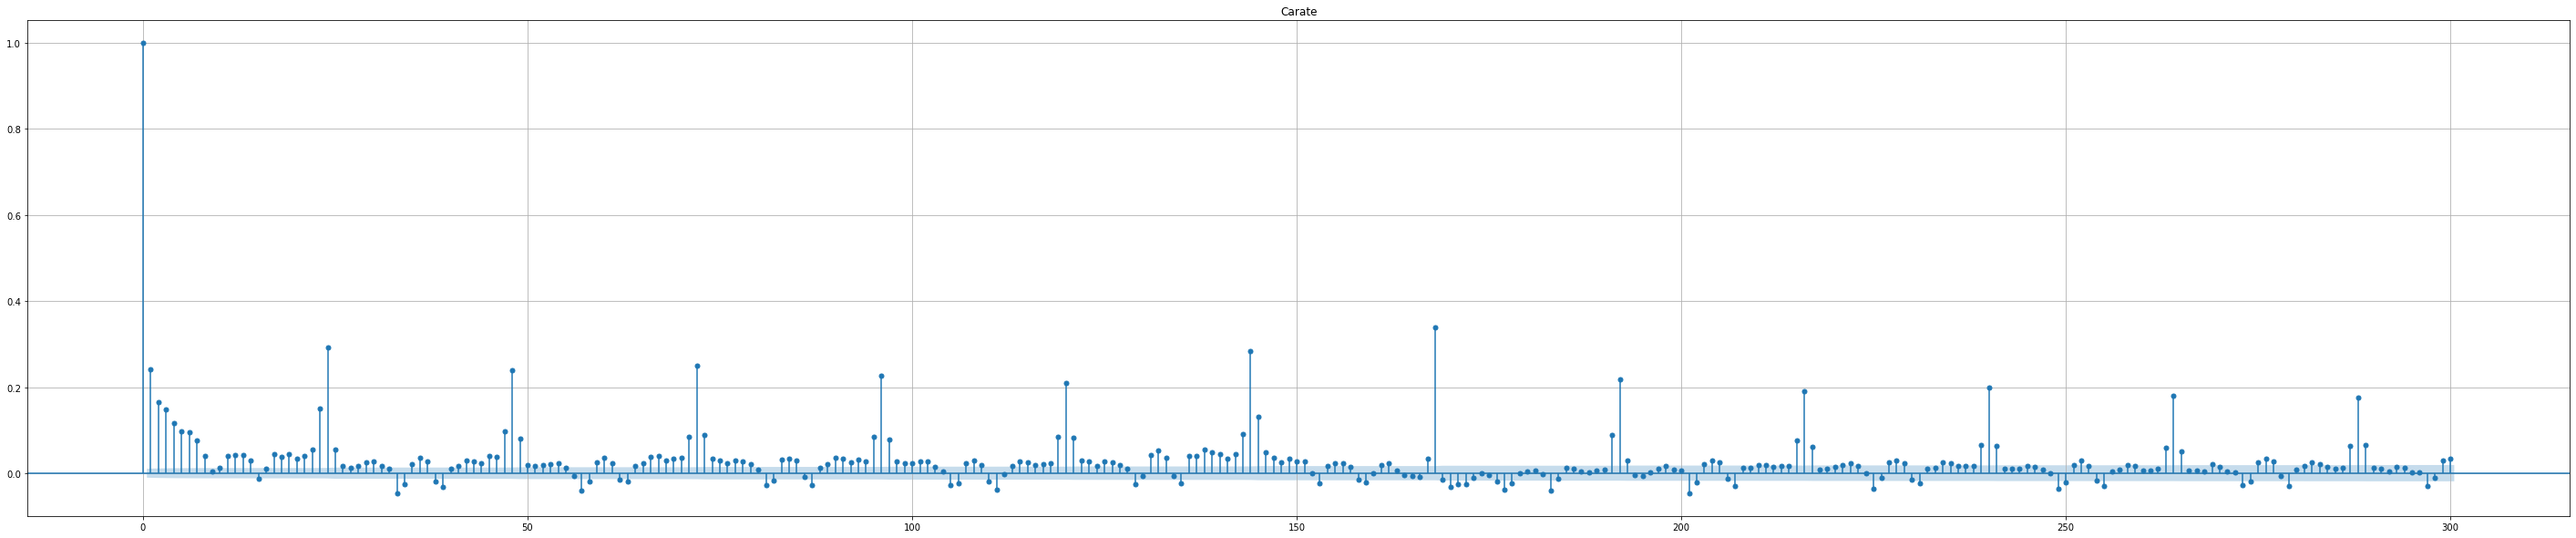

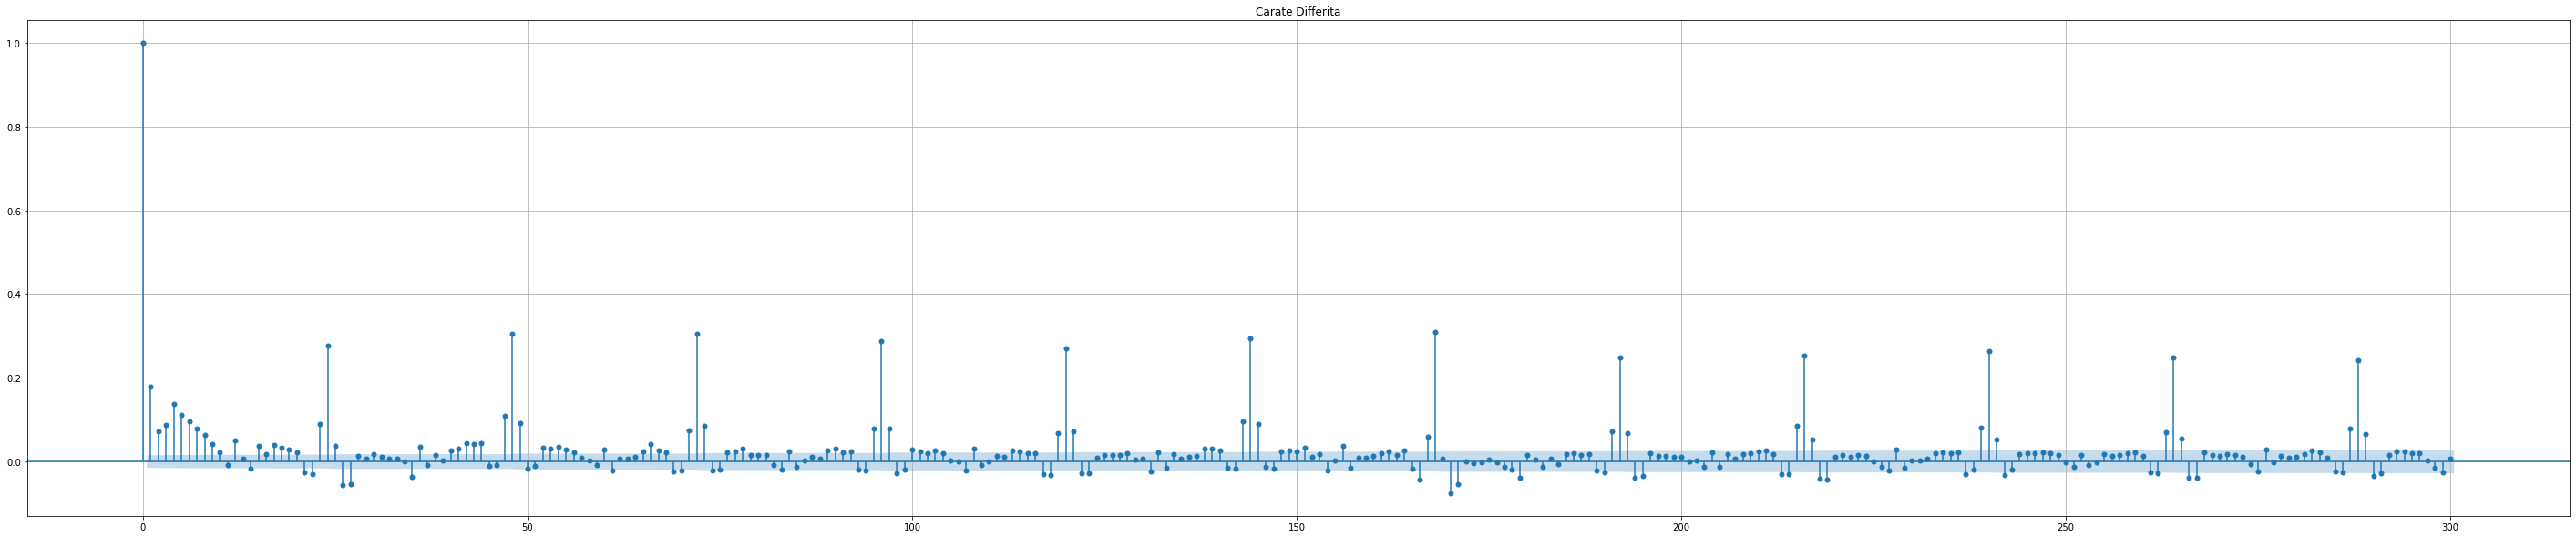

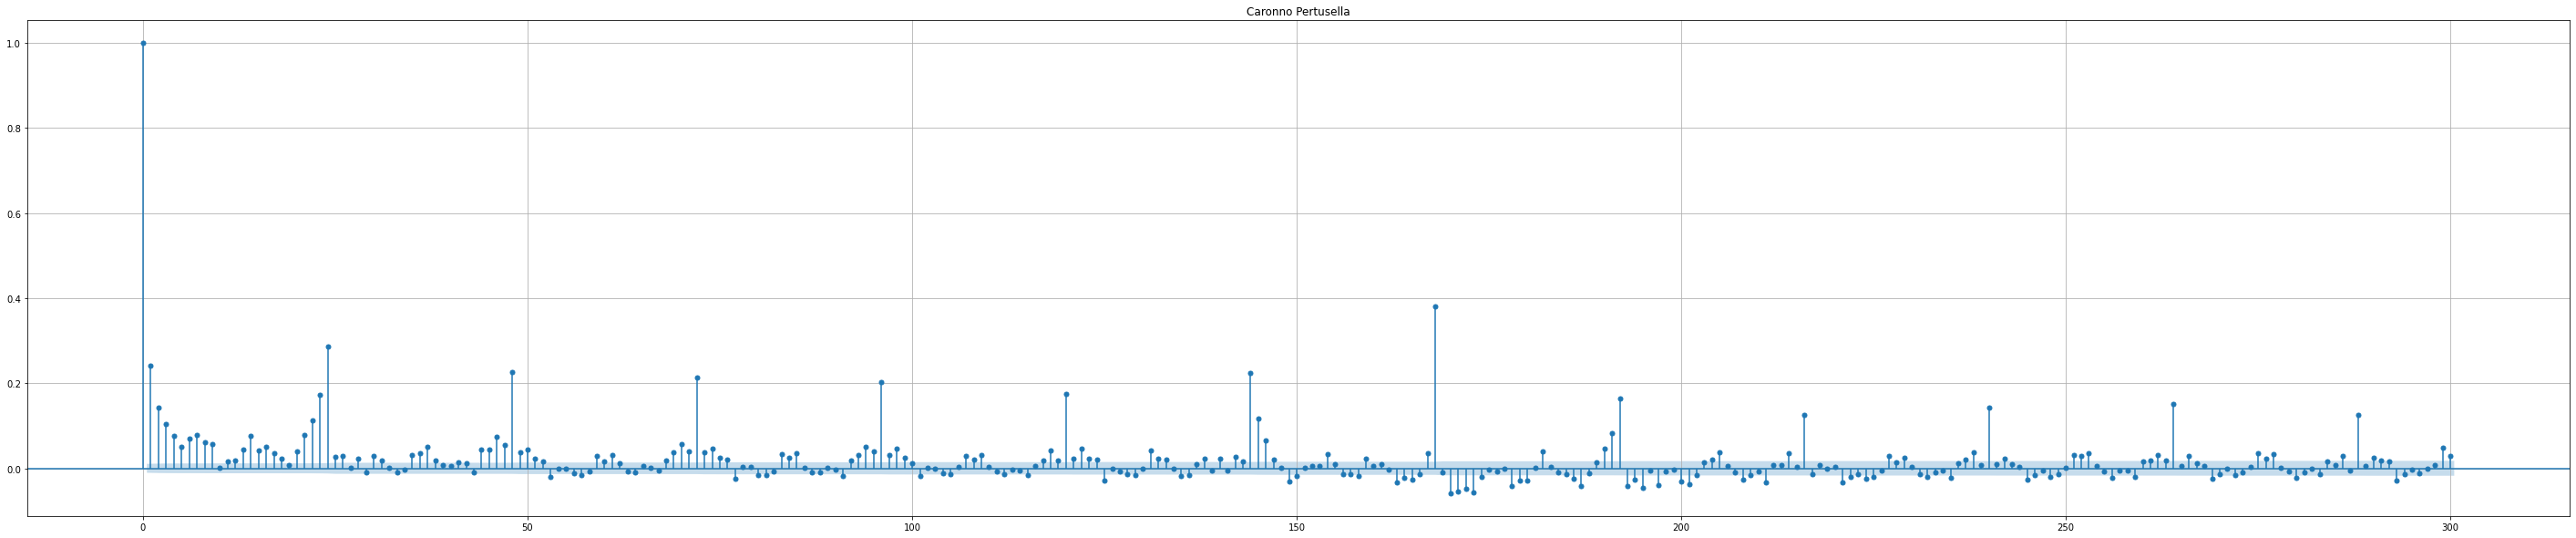

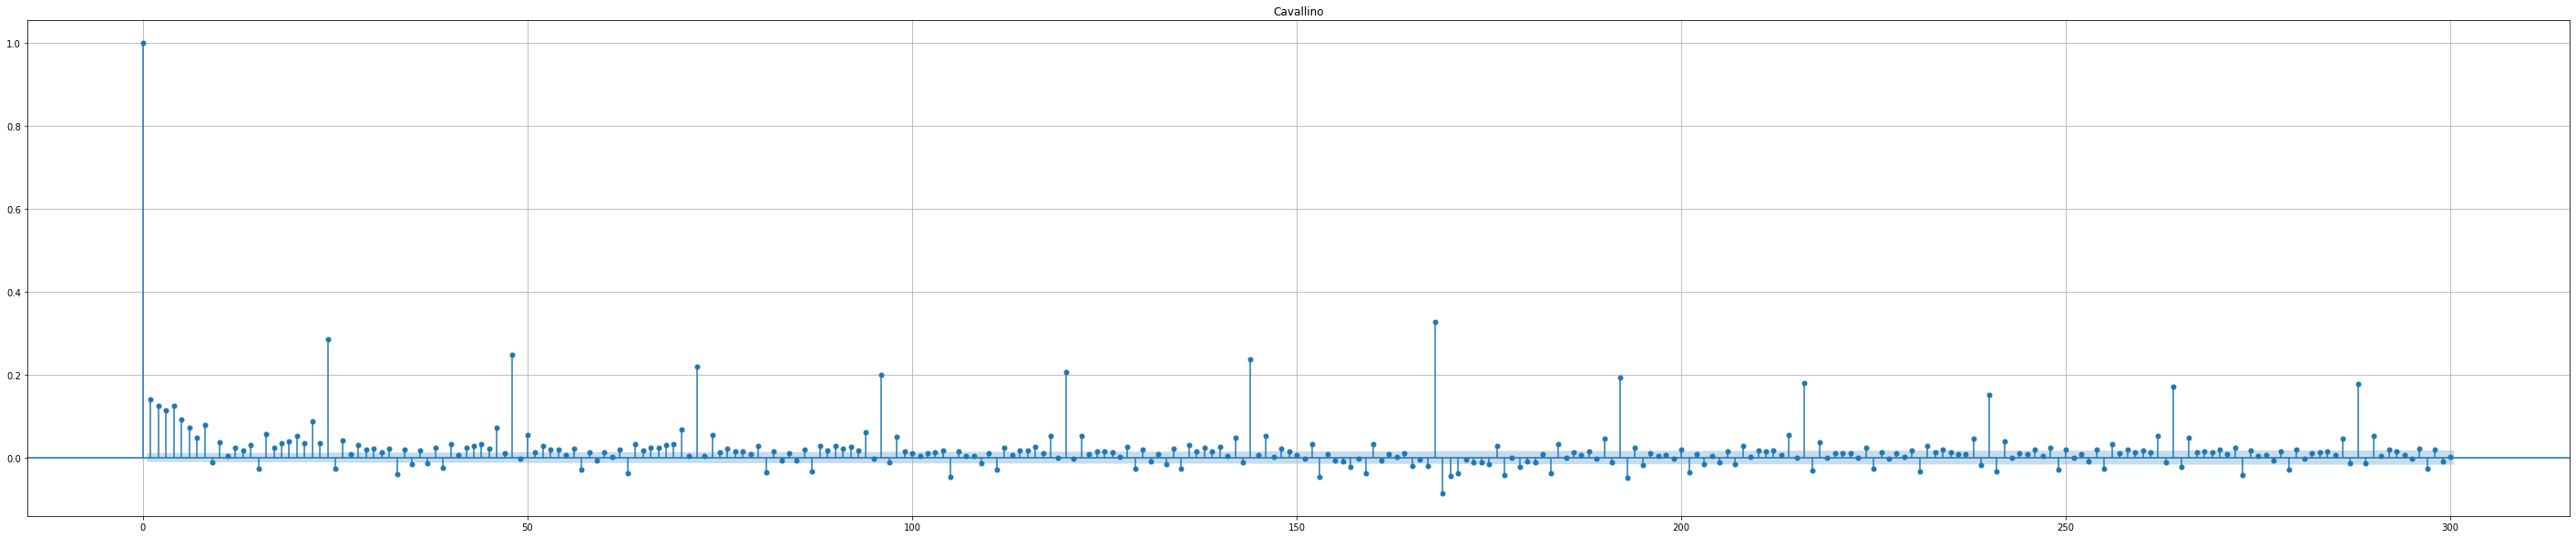

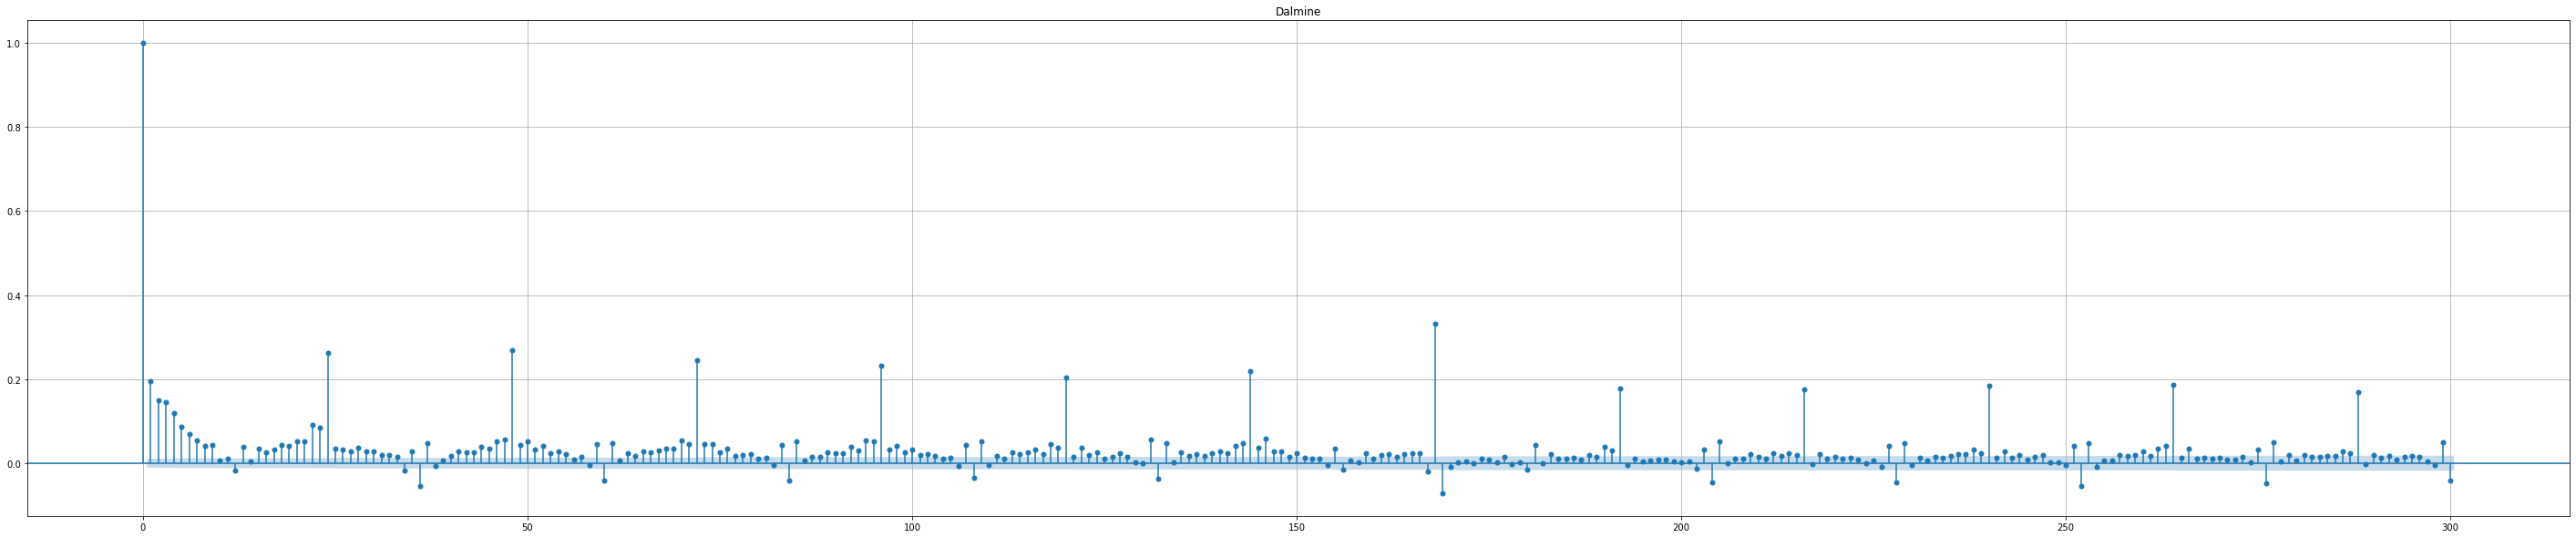

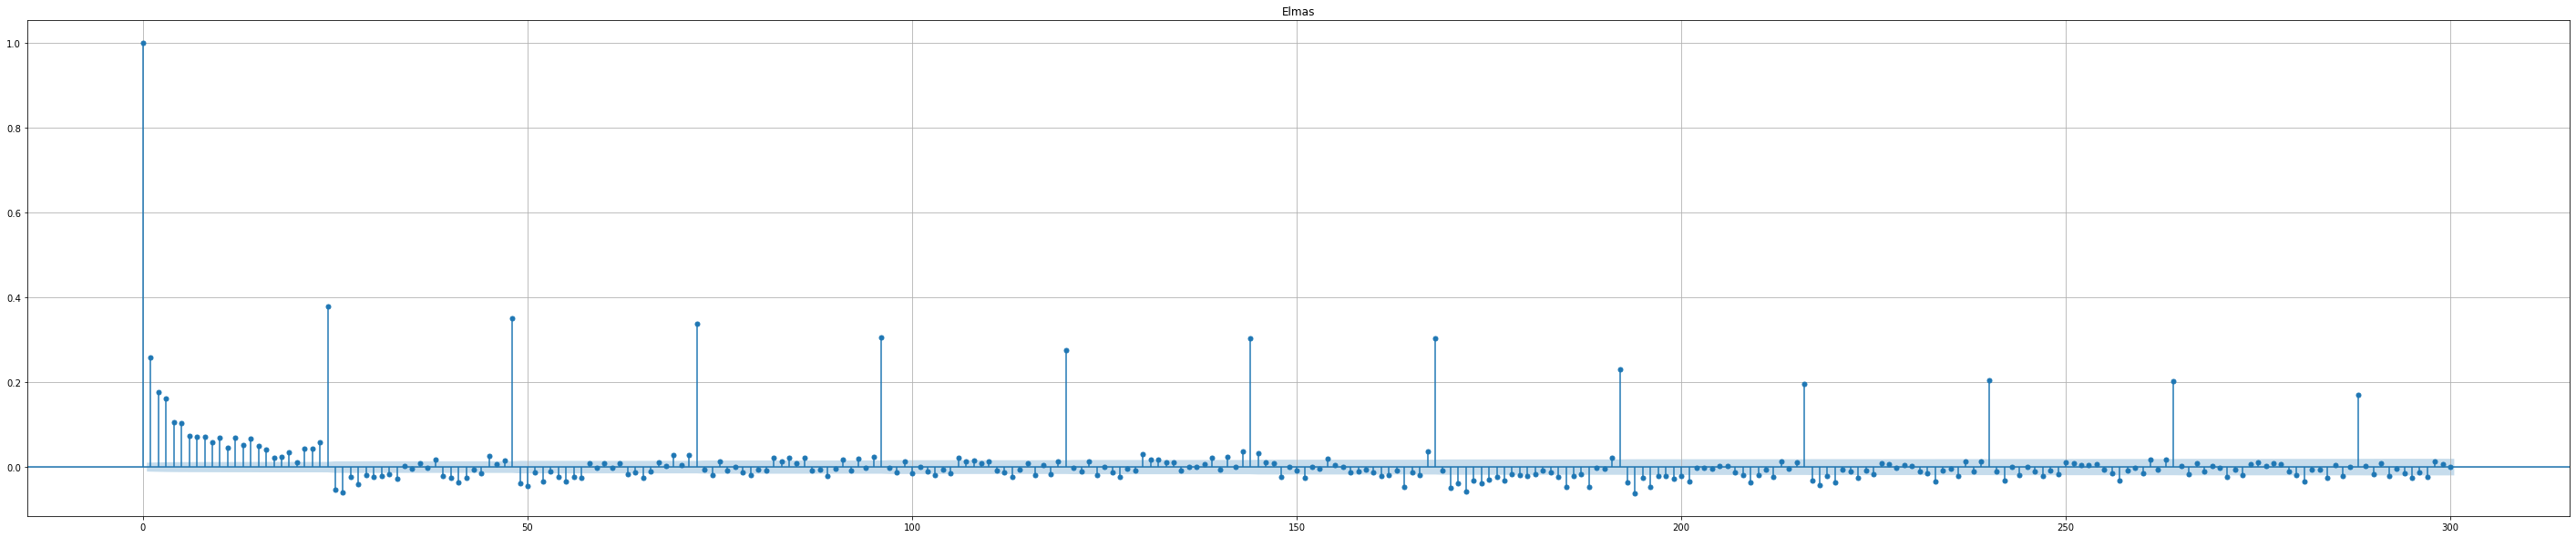

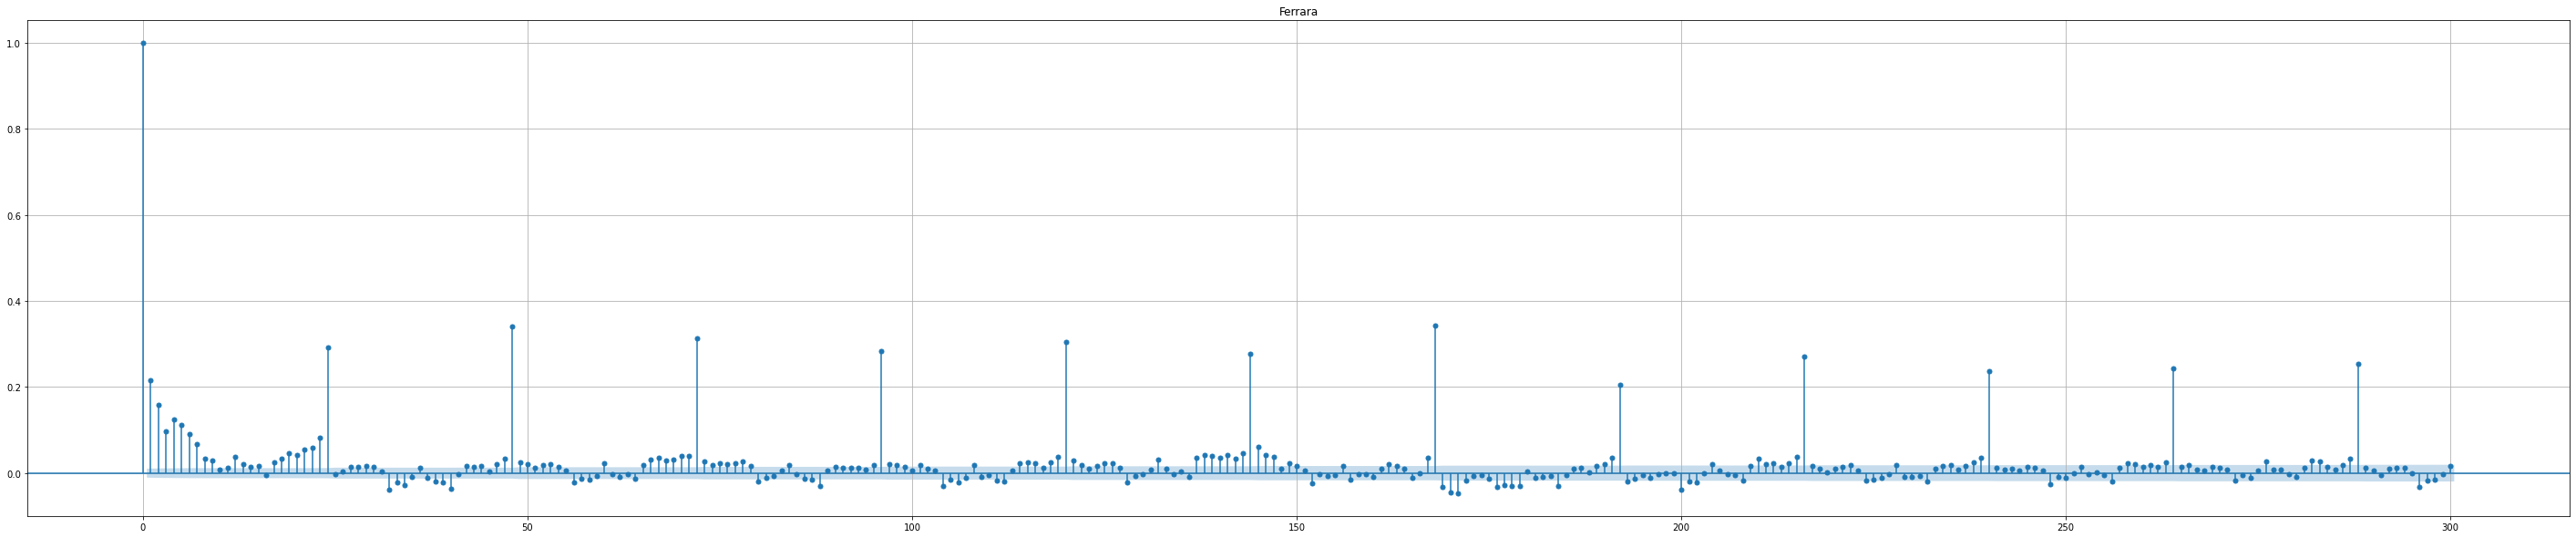

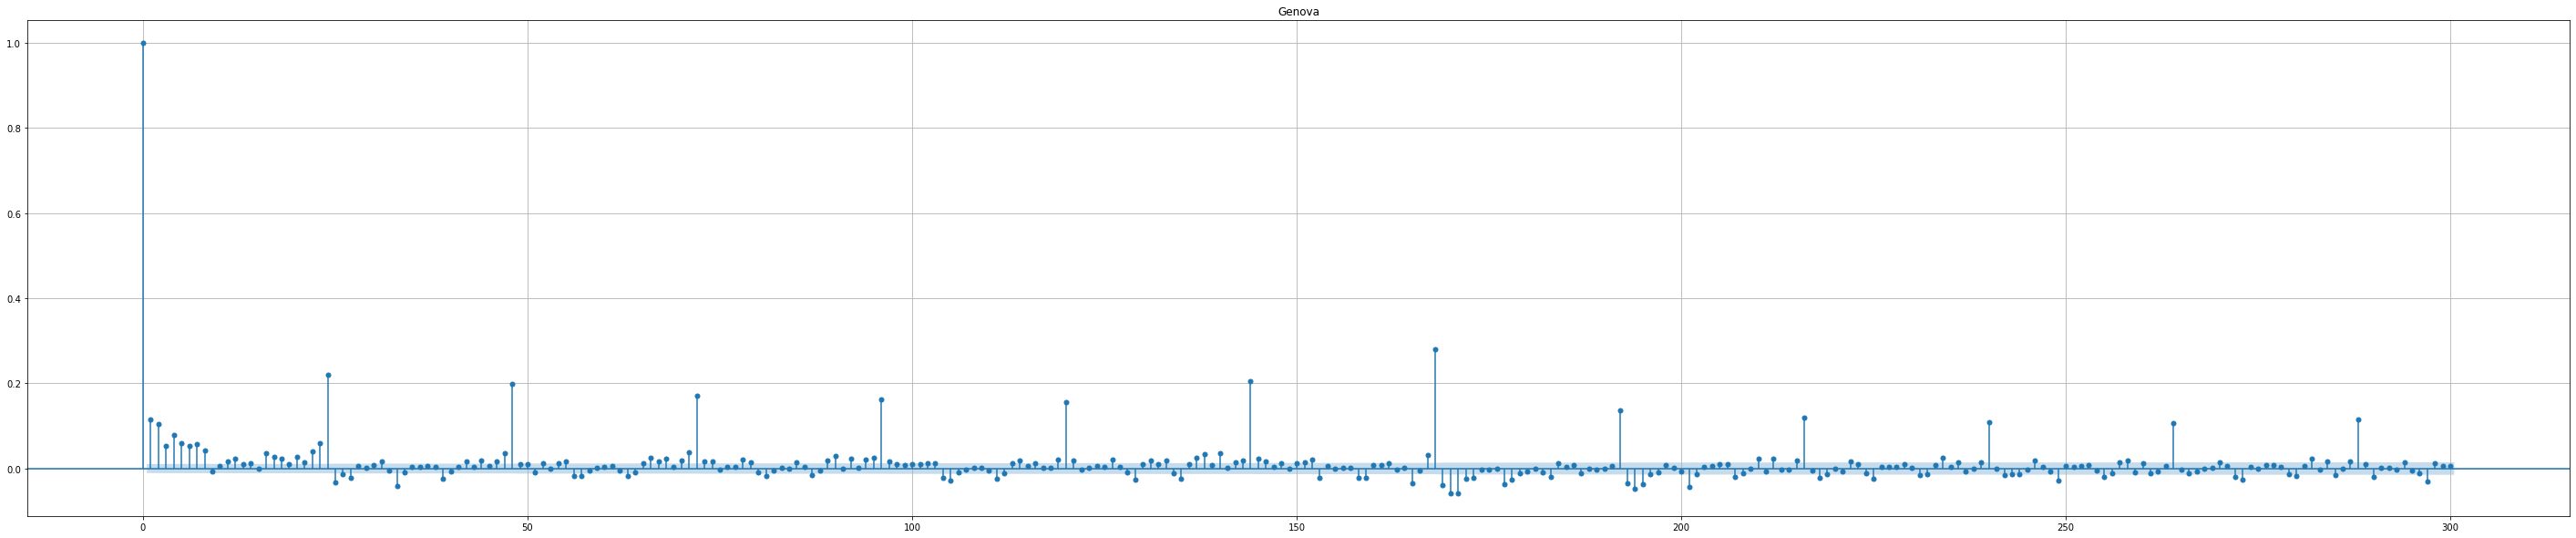

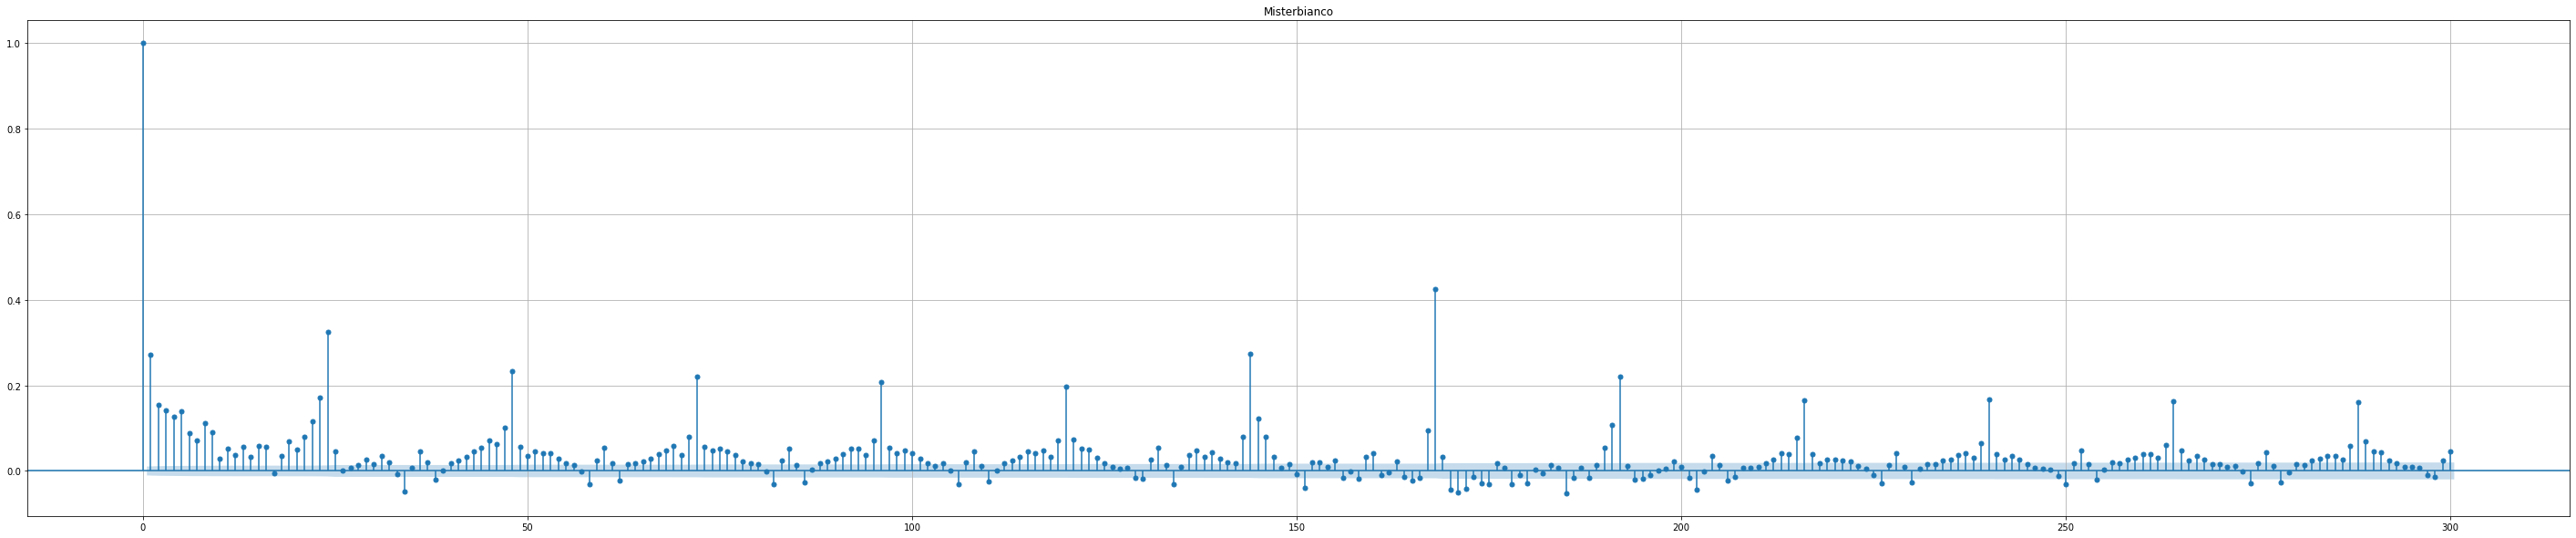

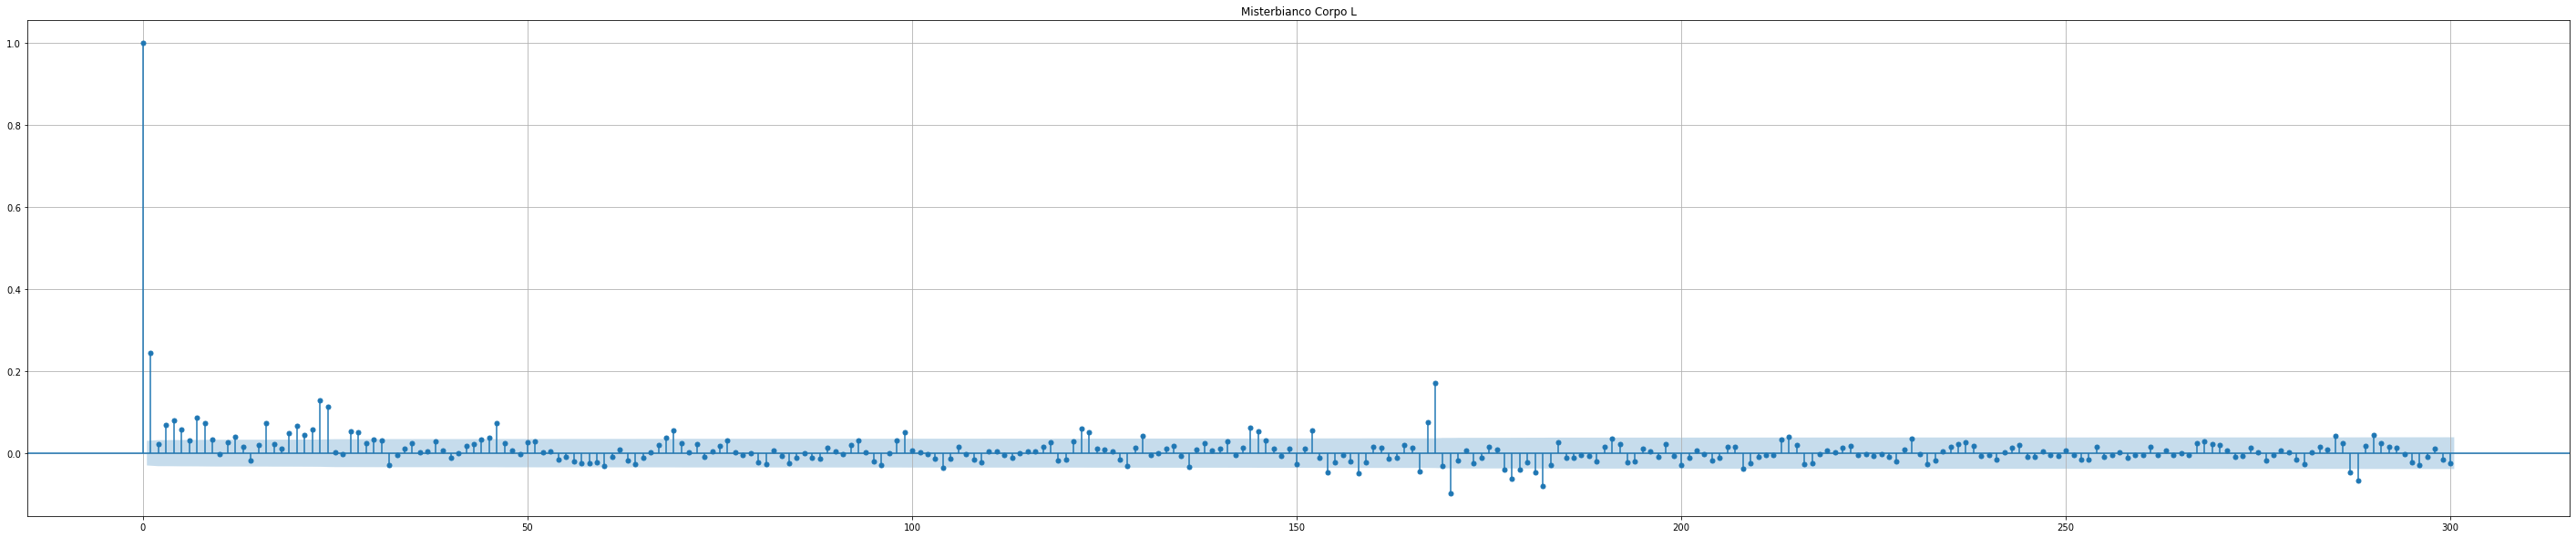

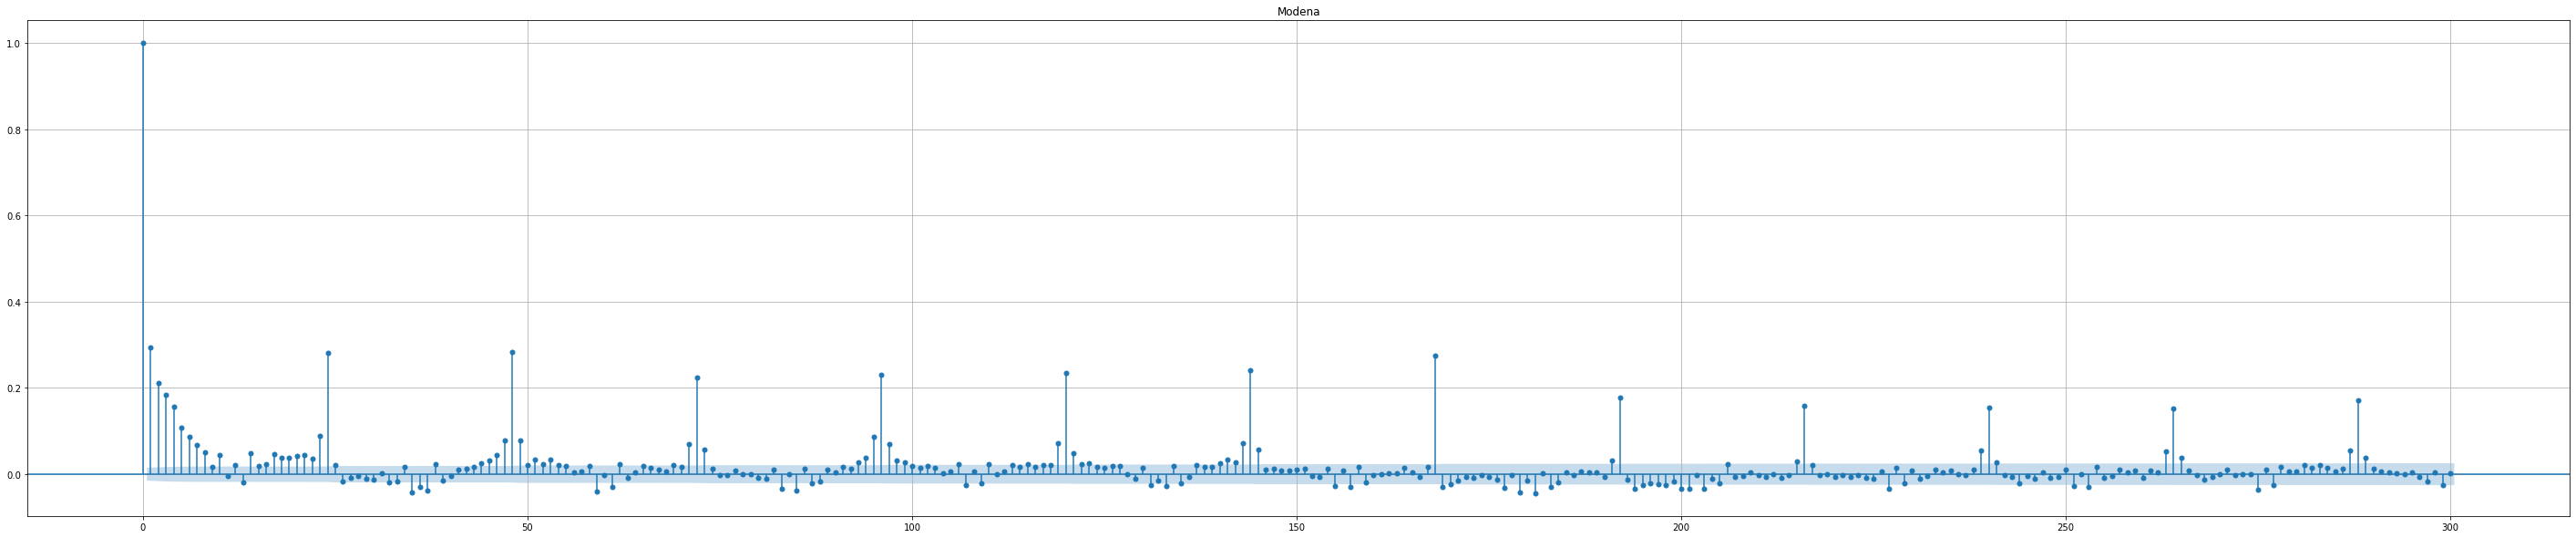

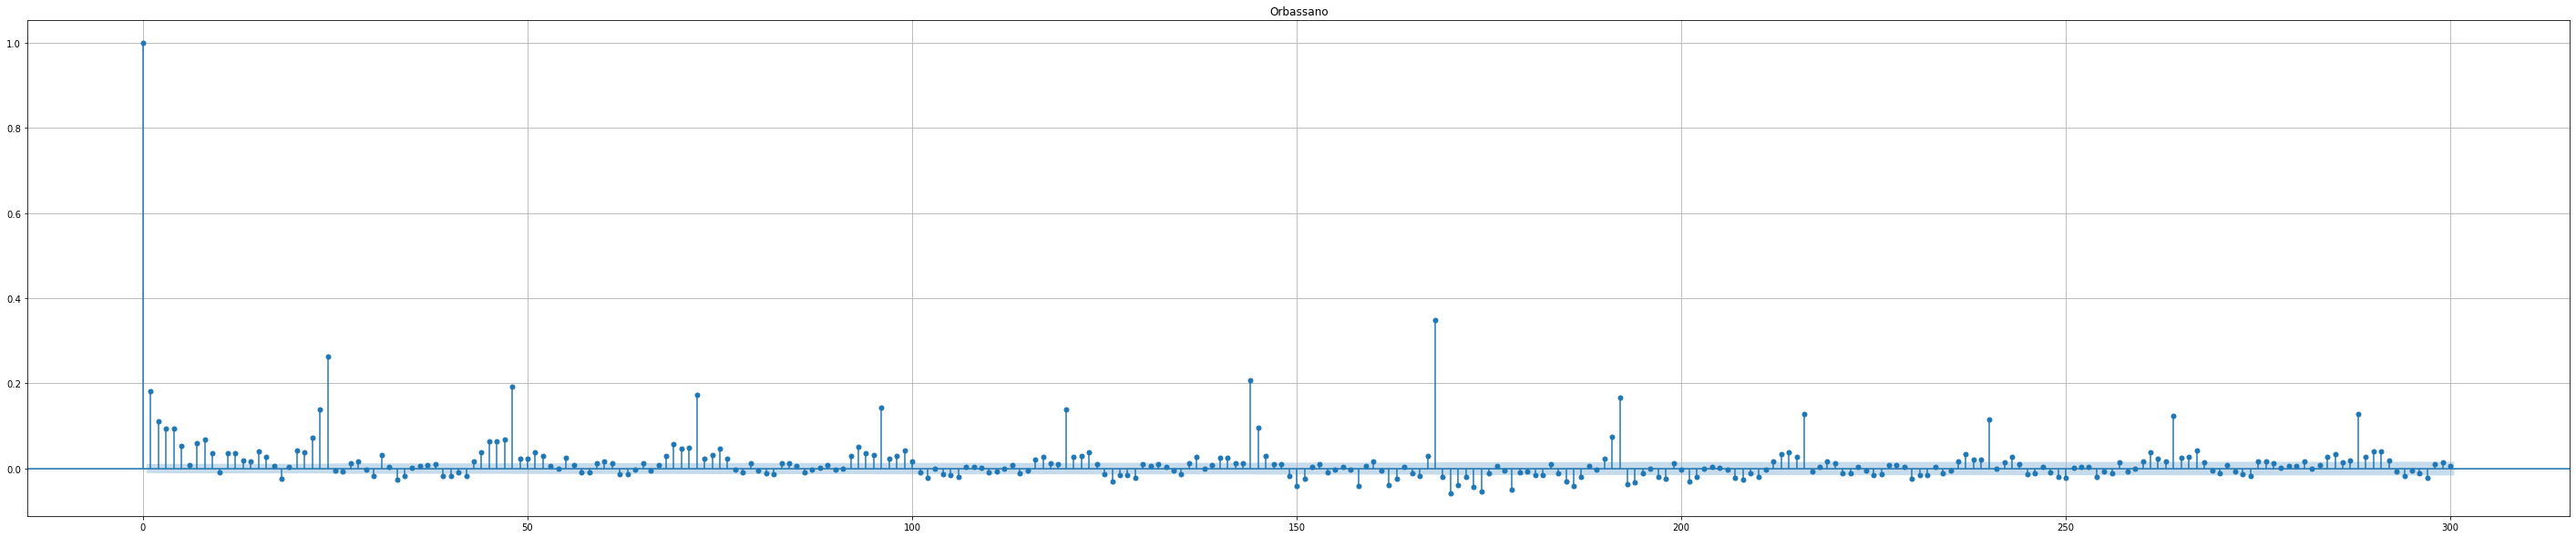

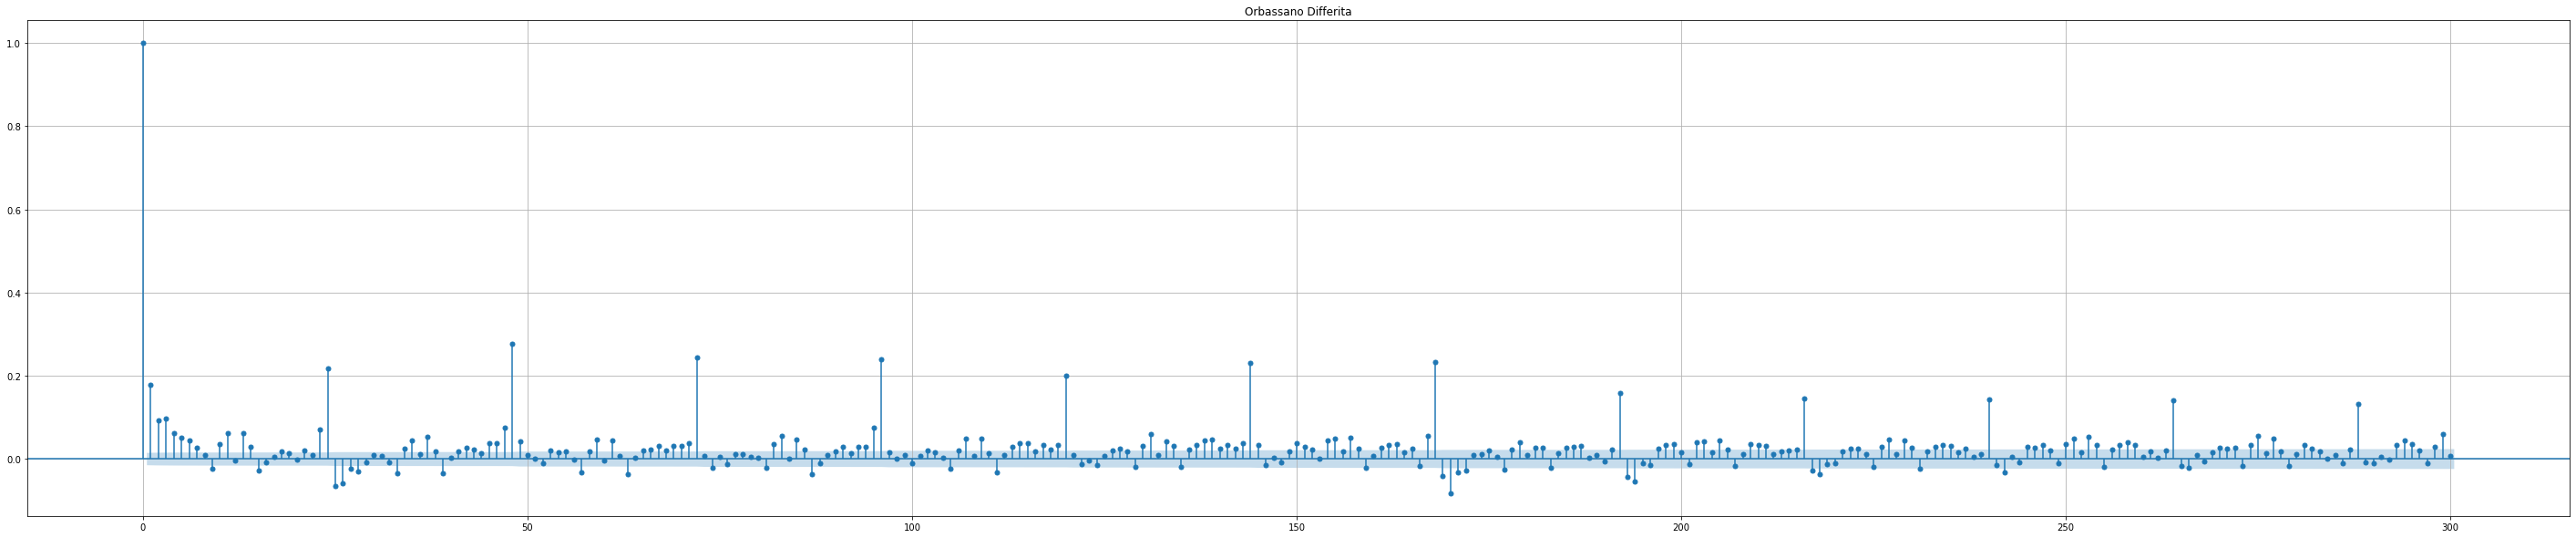

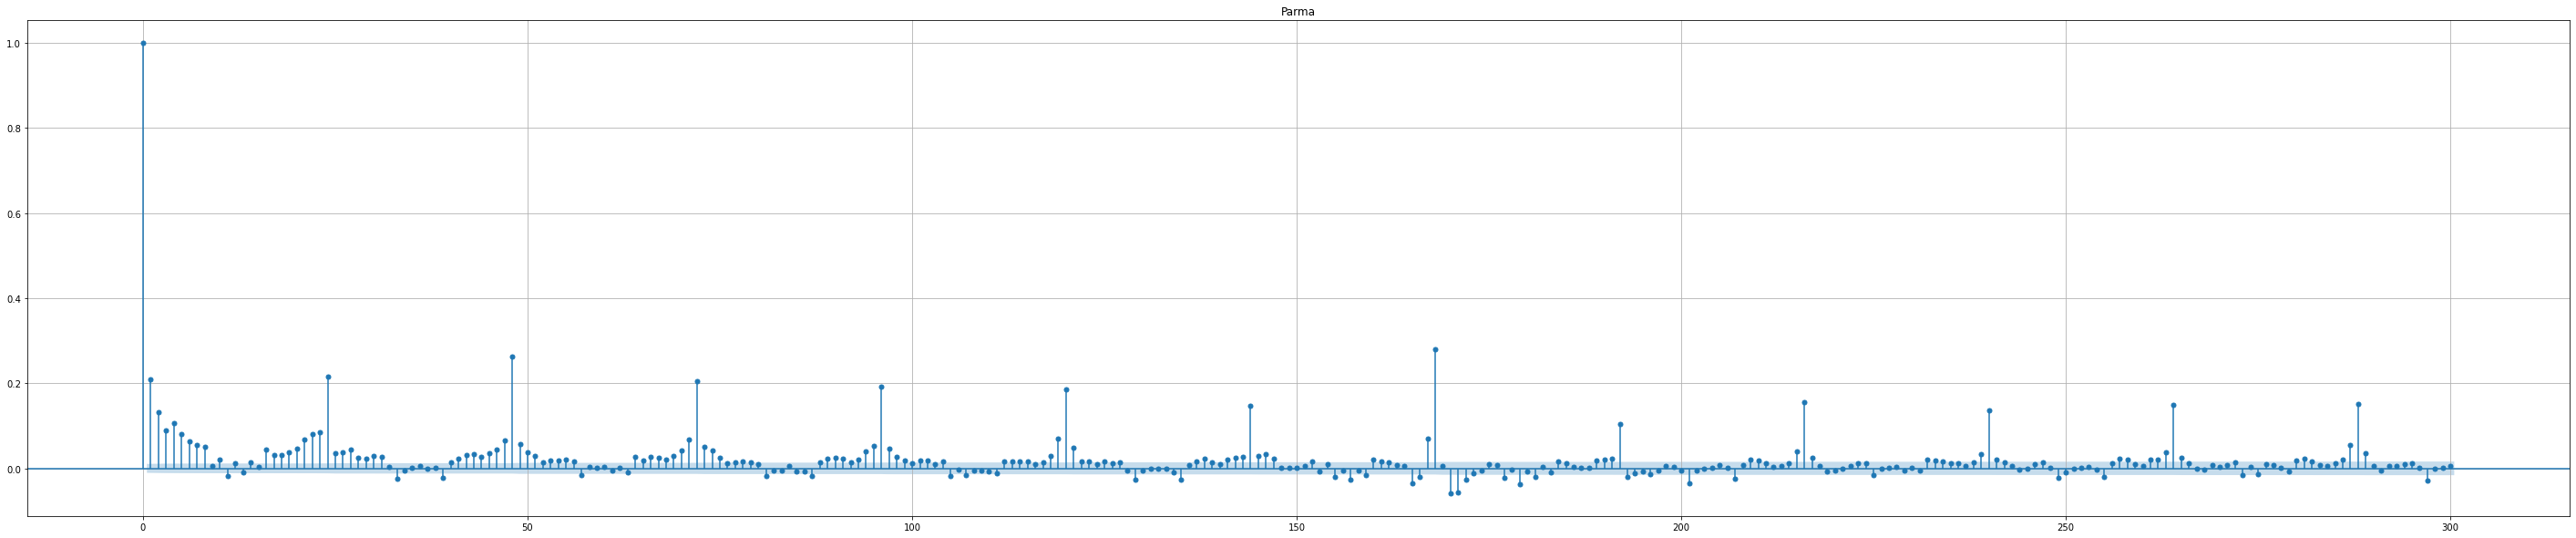

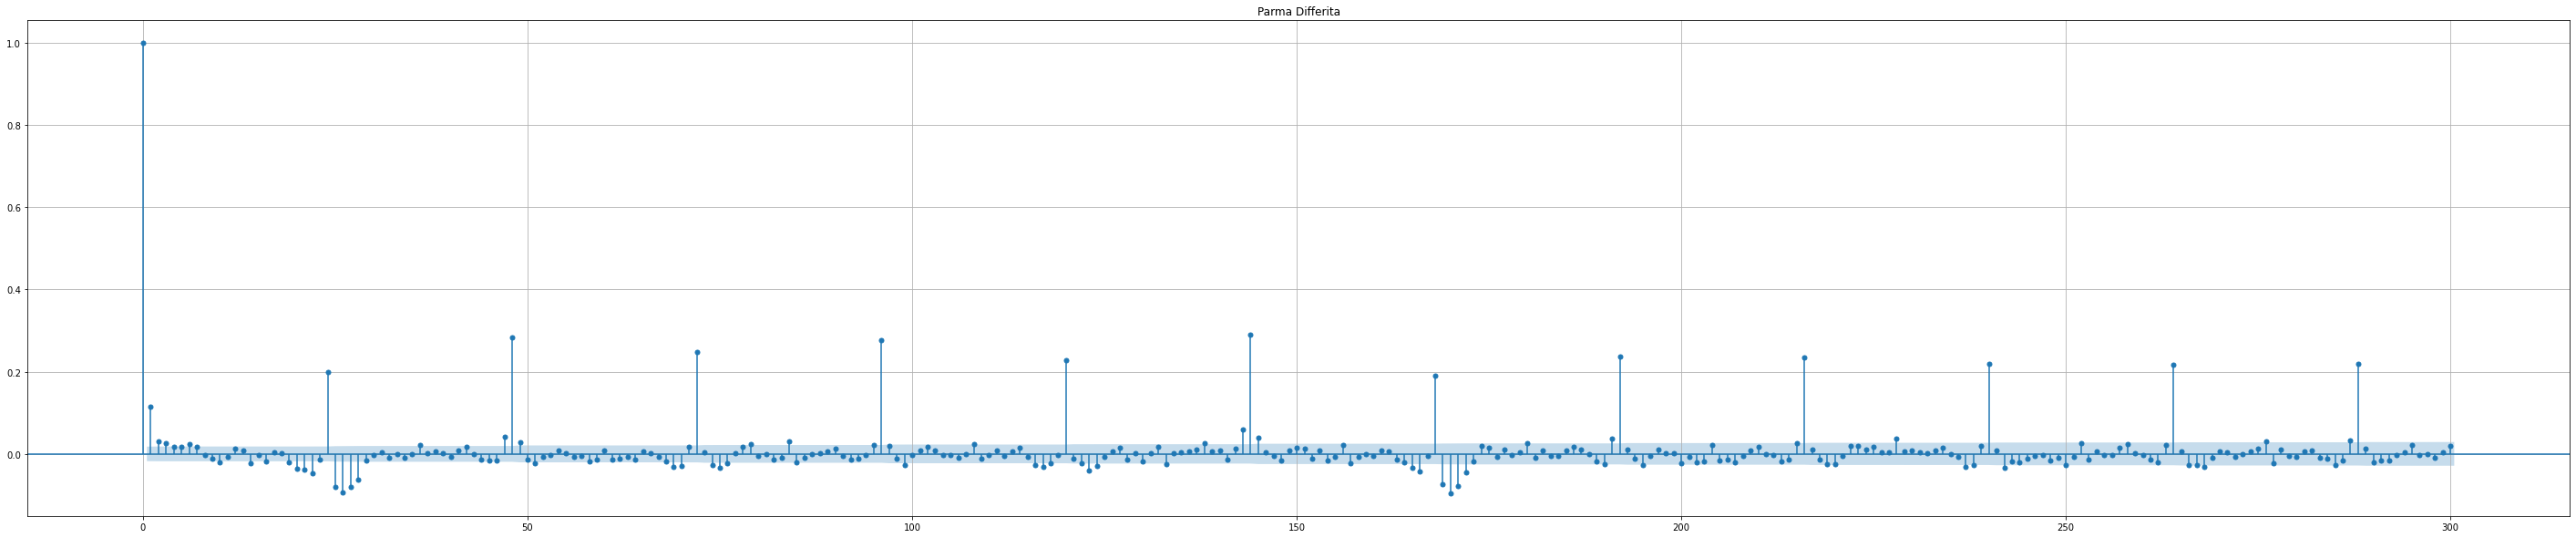

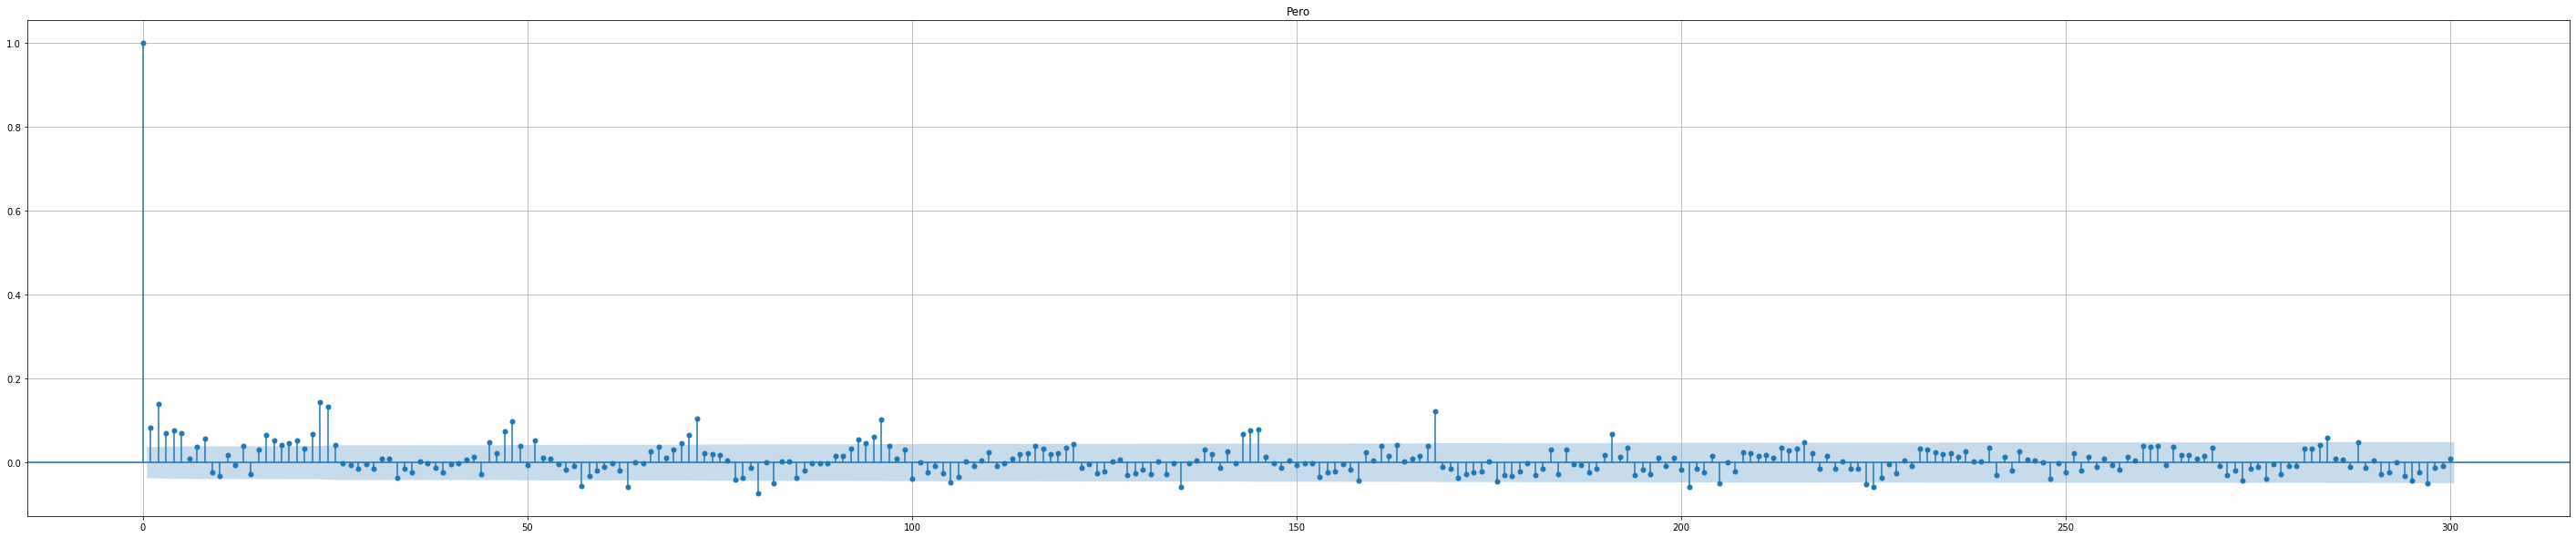

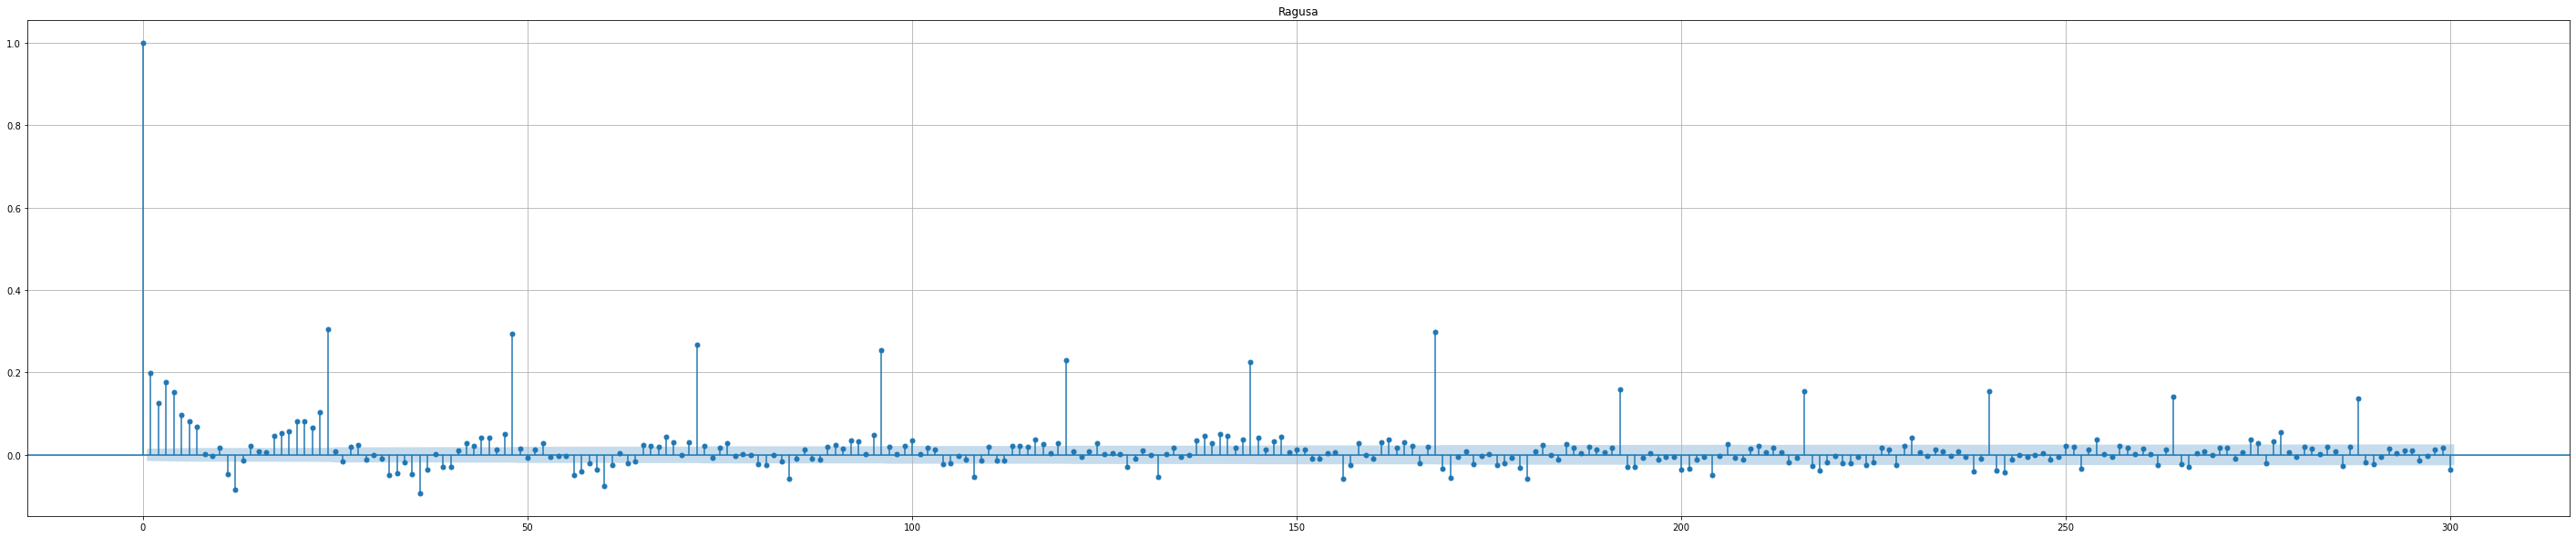

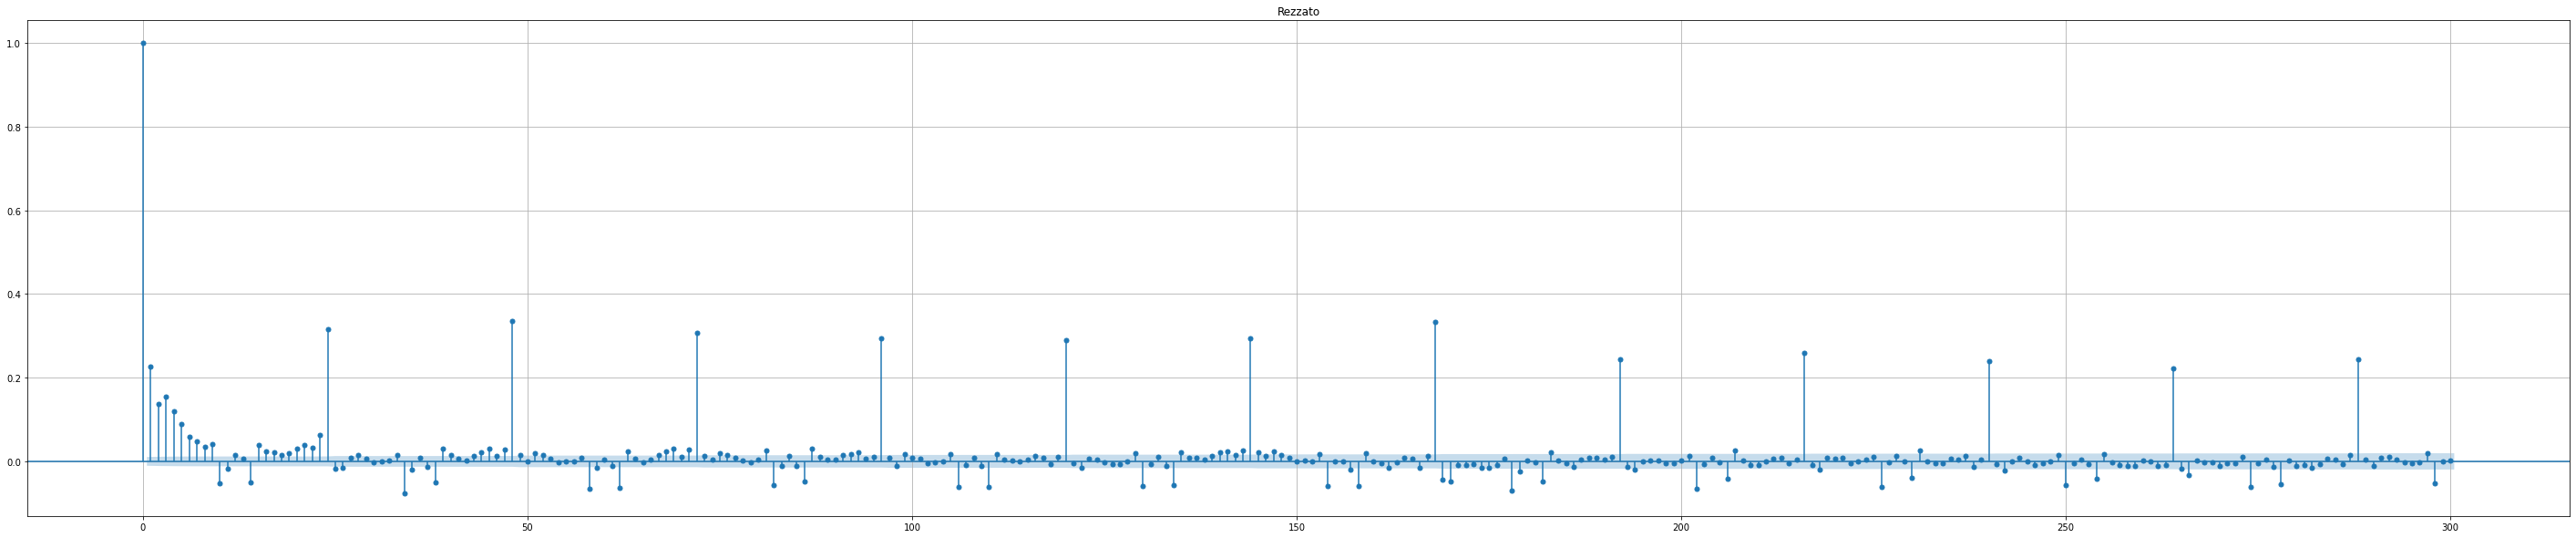

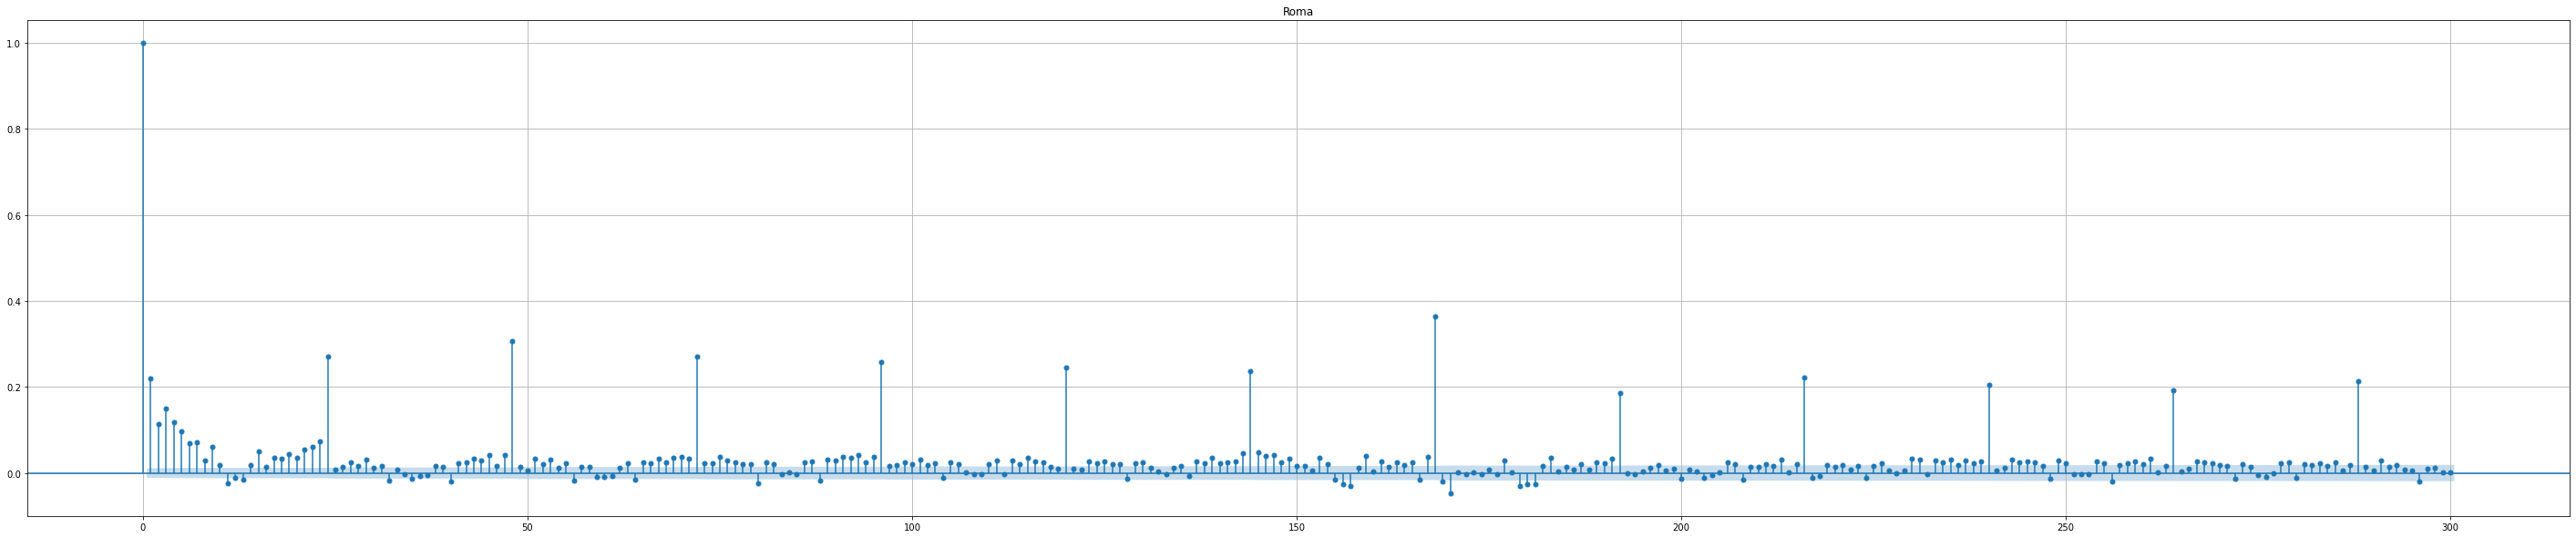

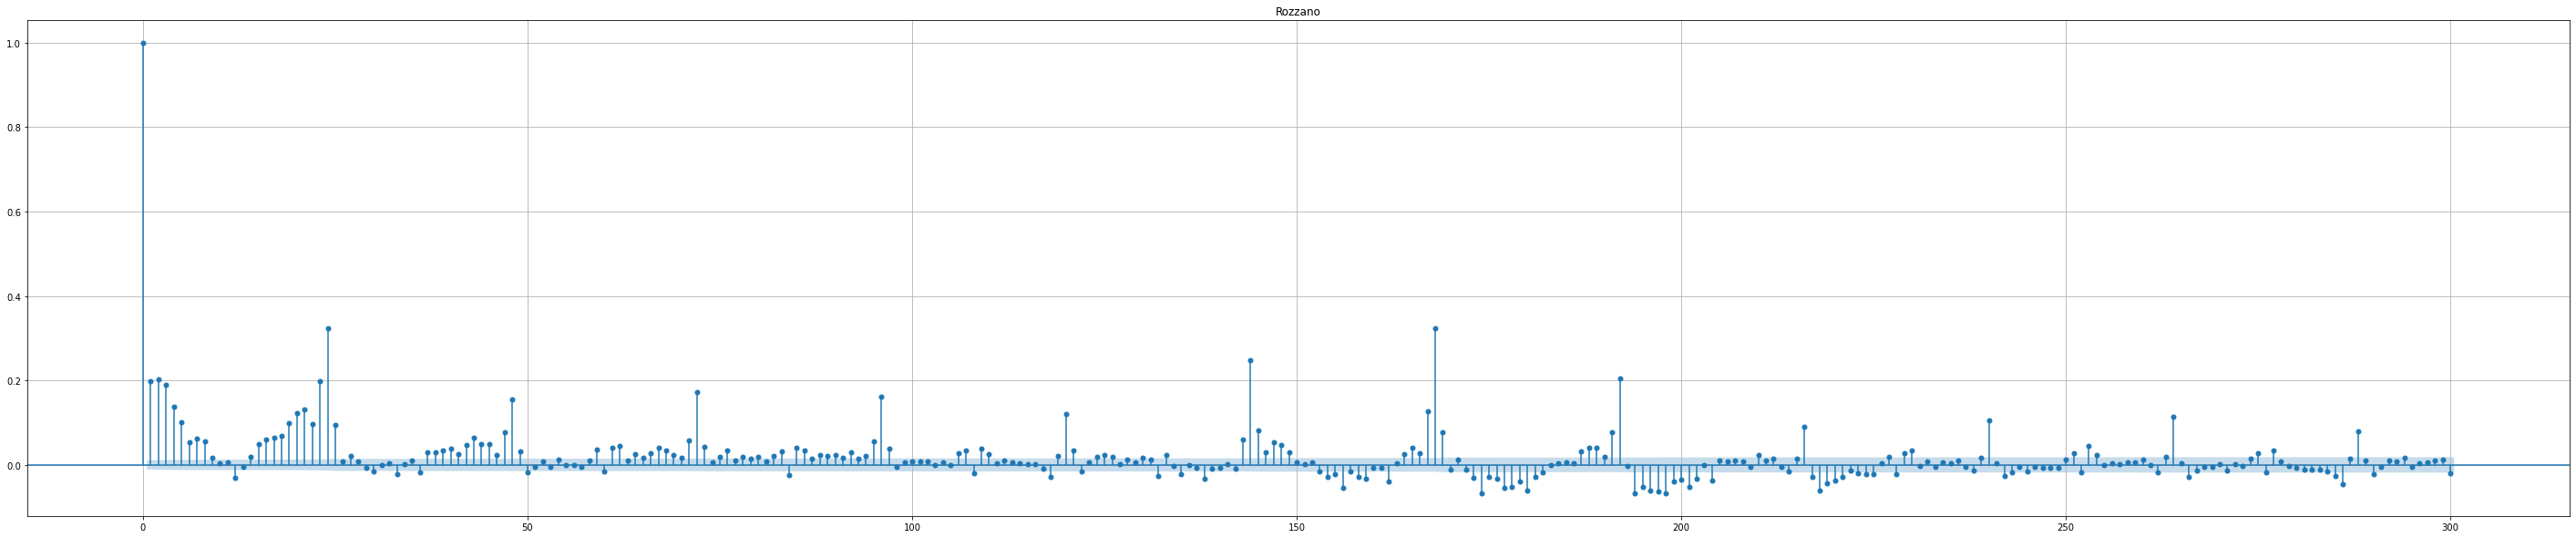

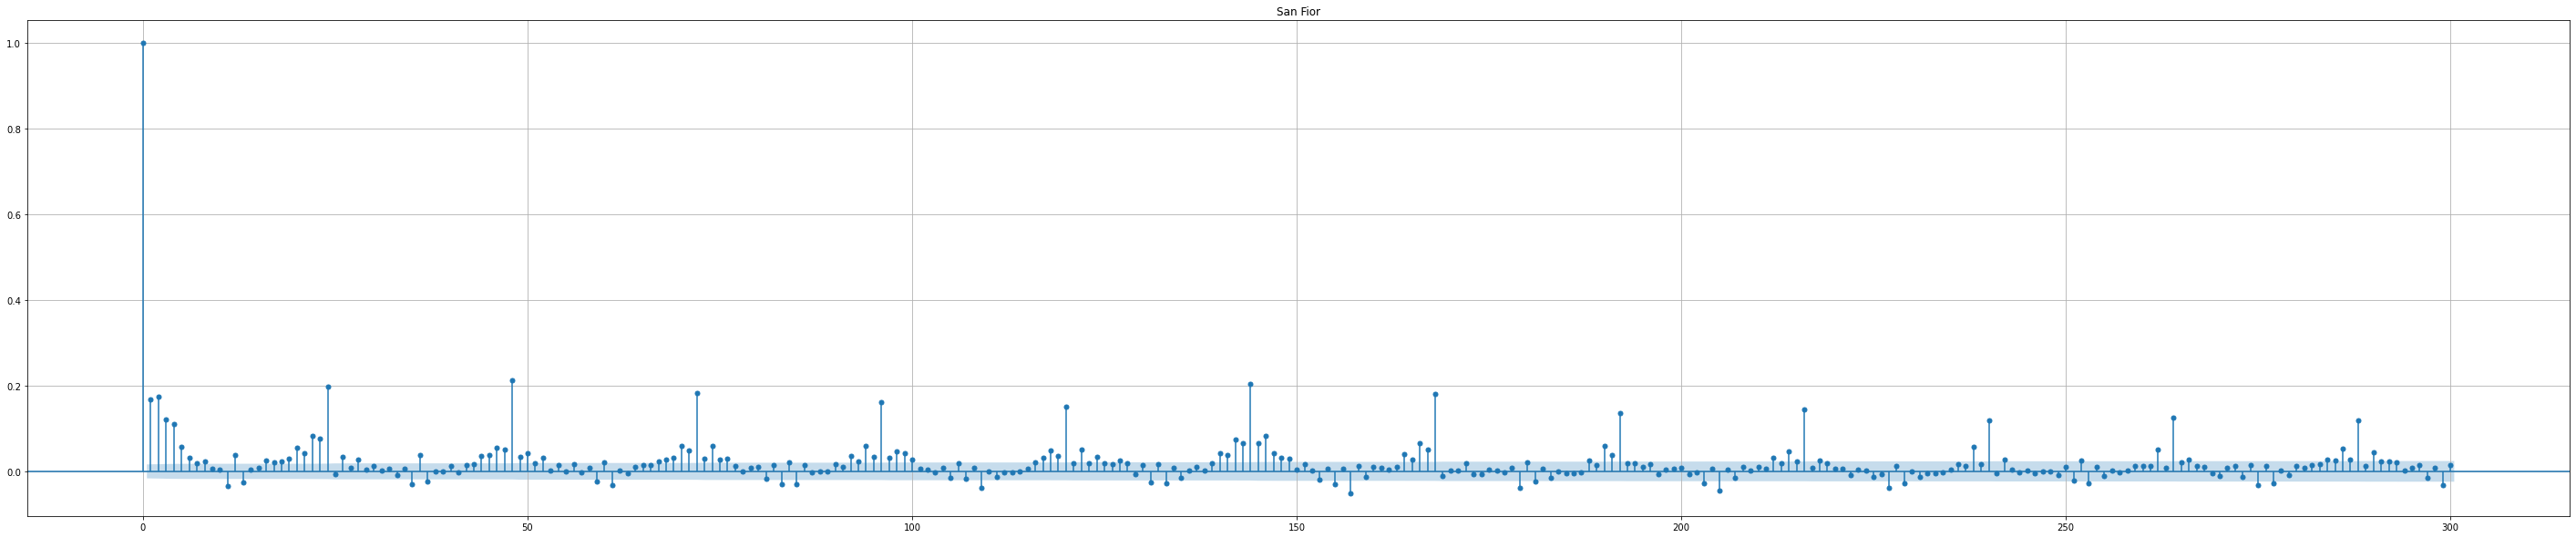

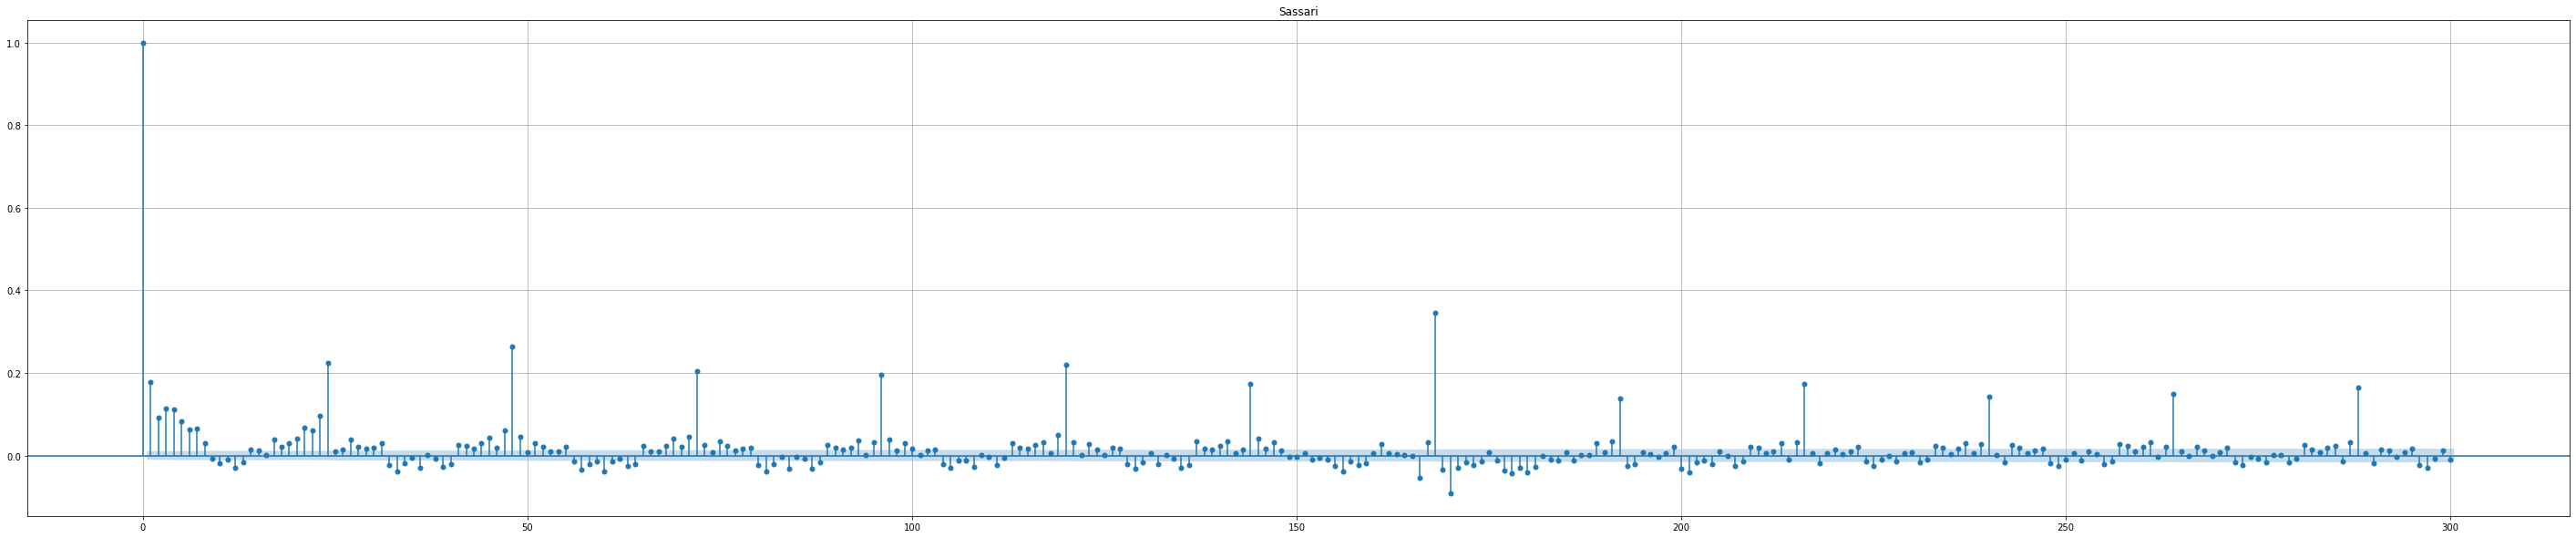

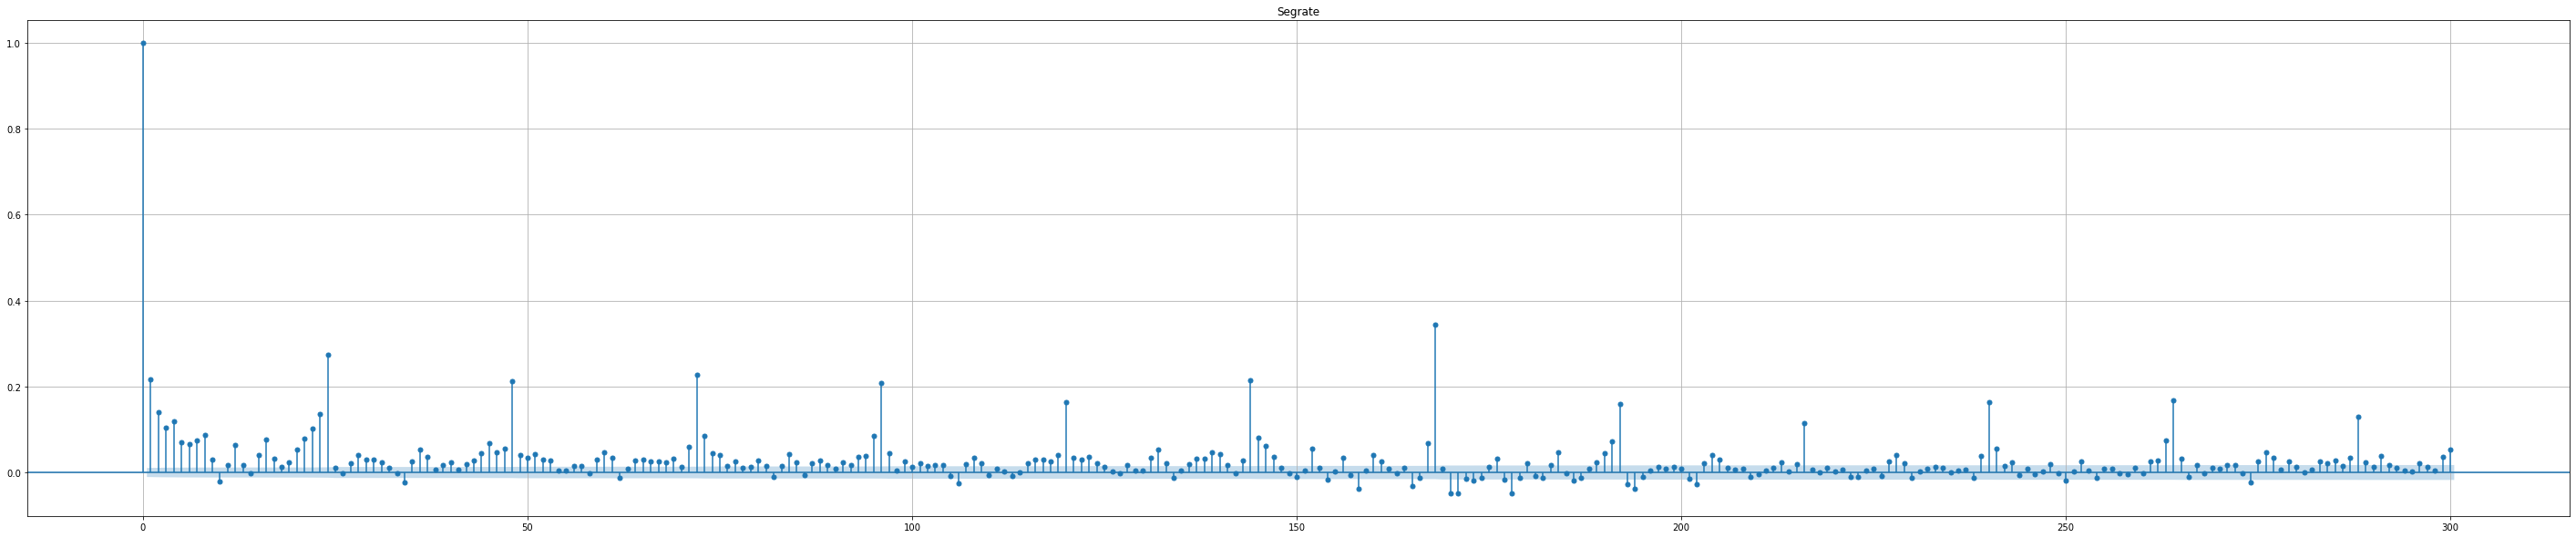

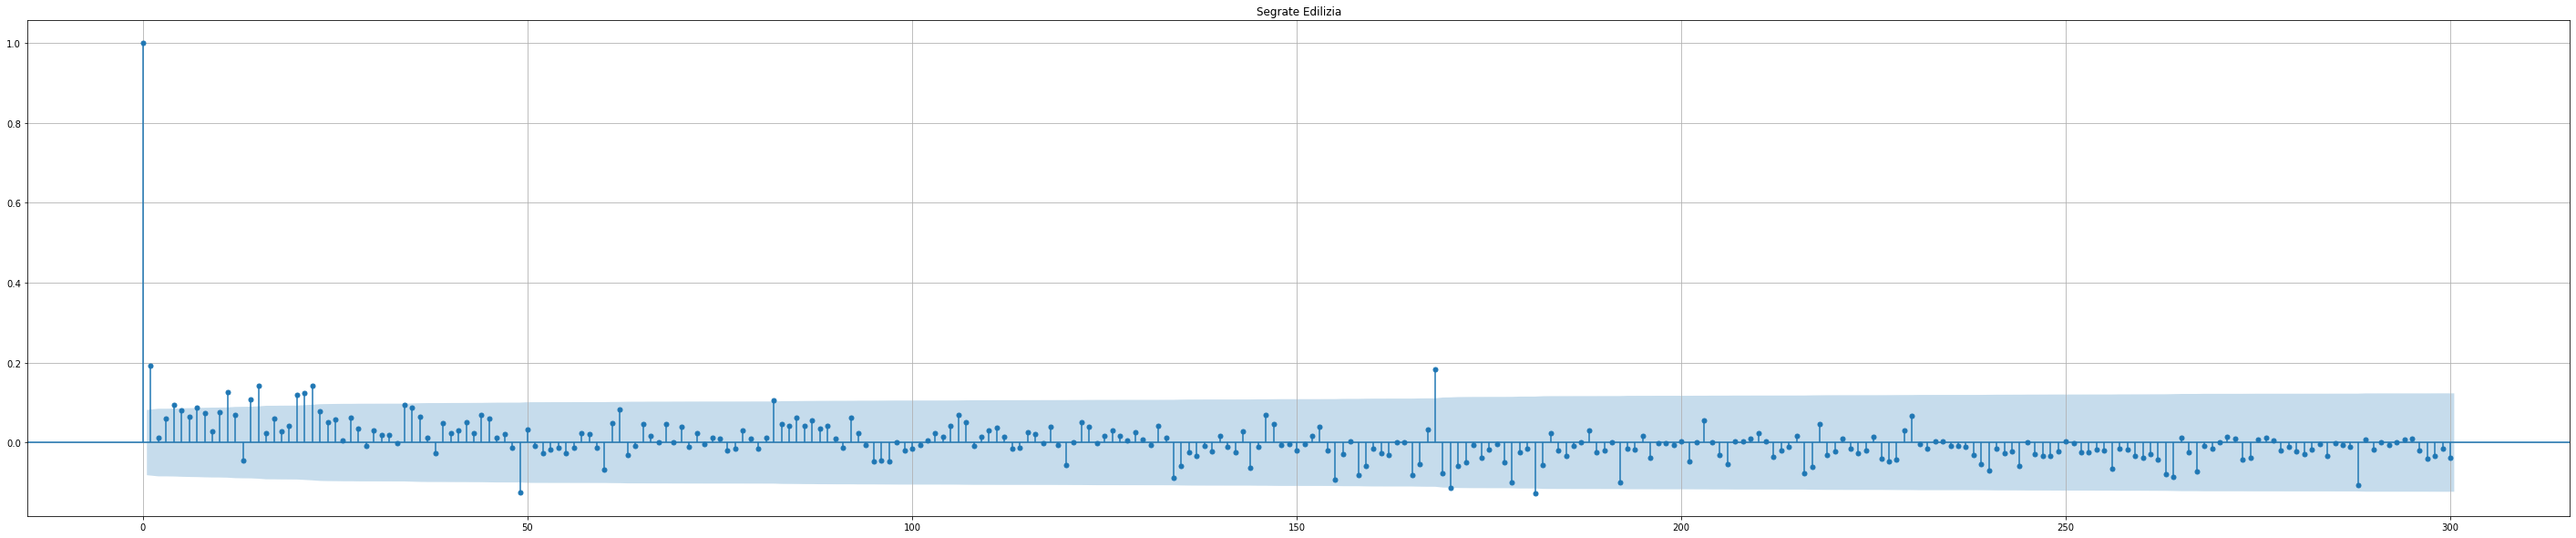

Segrate Edilizia 0.7360059386010387 



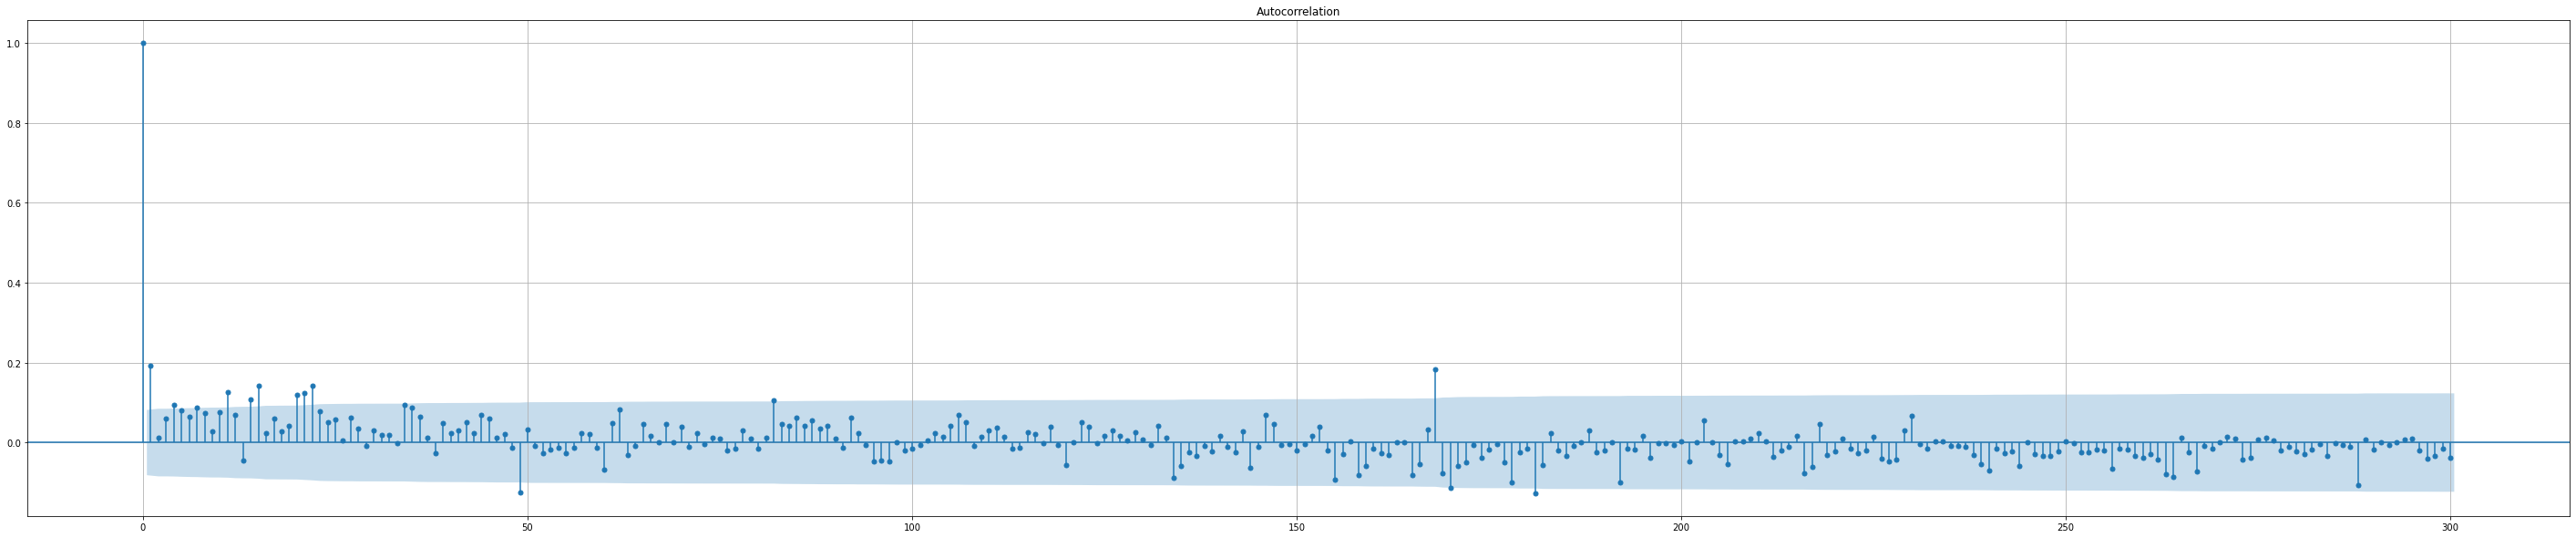

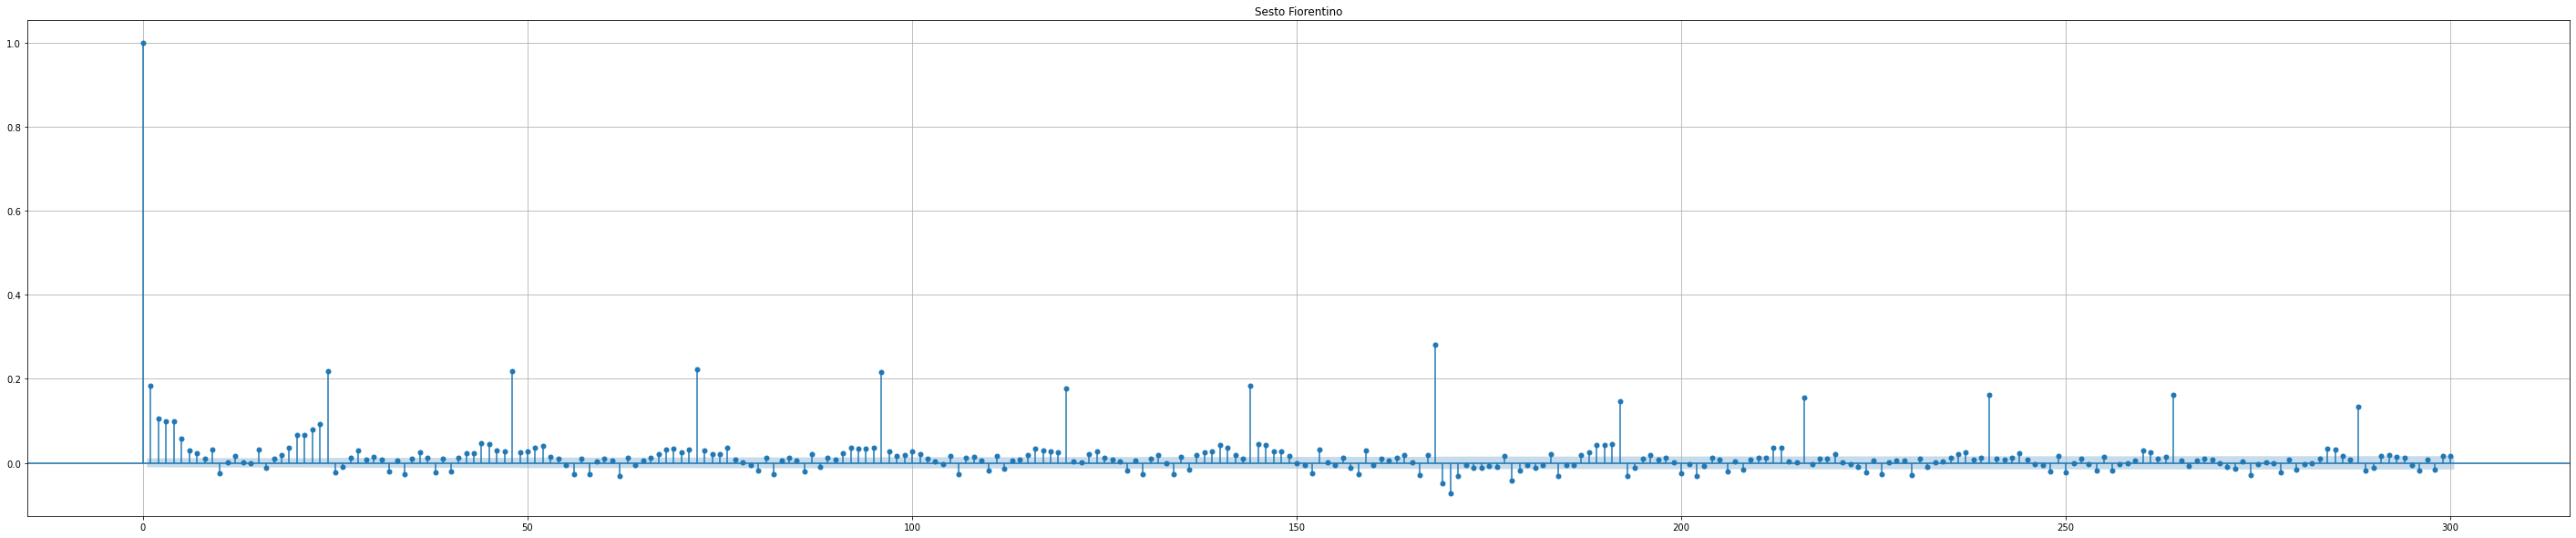

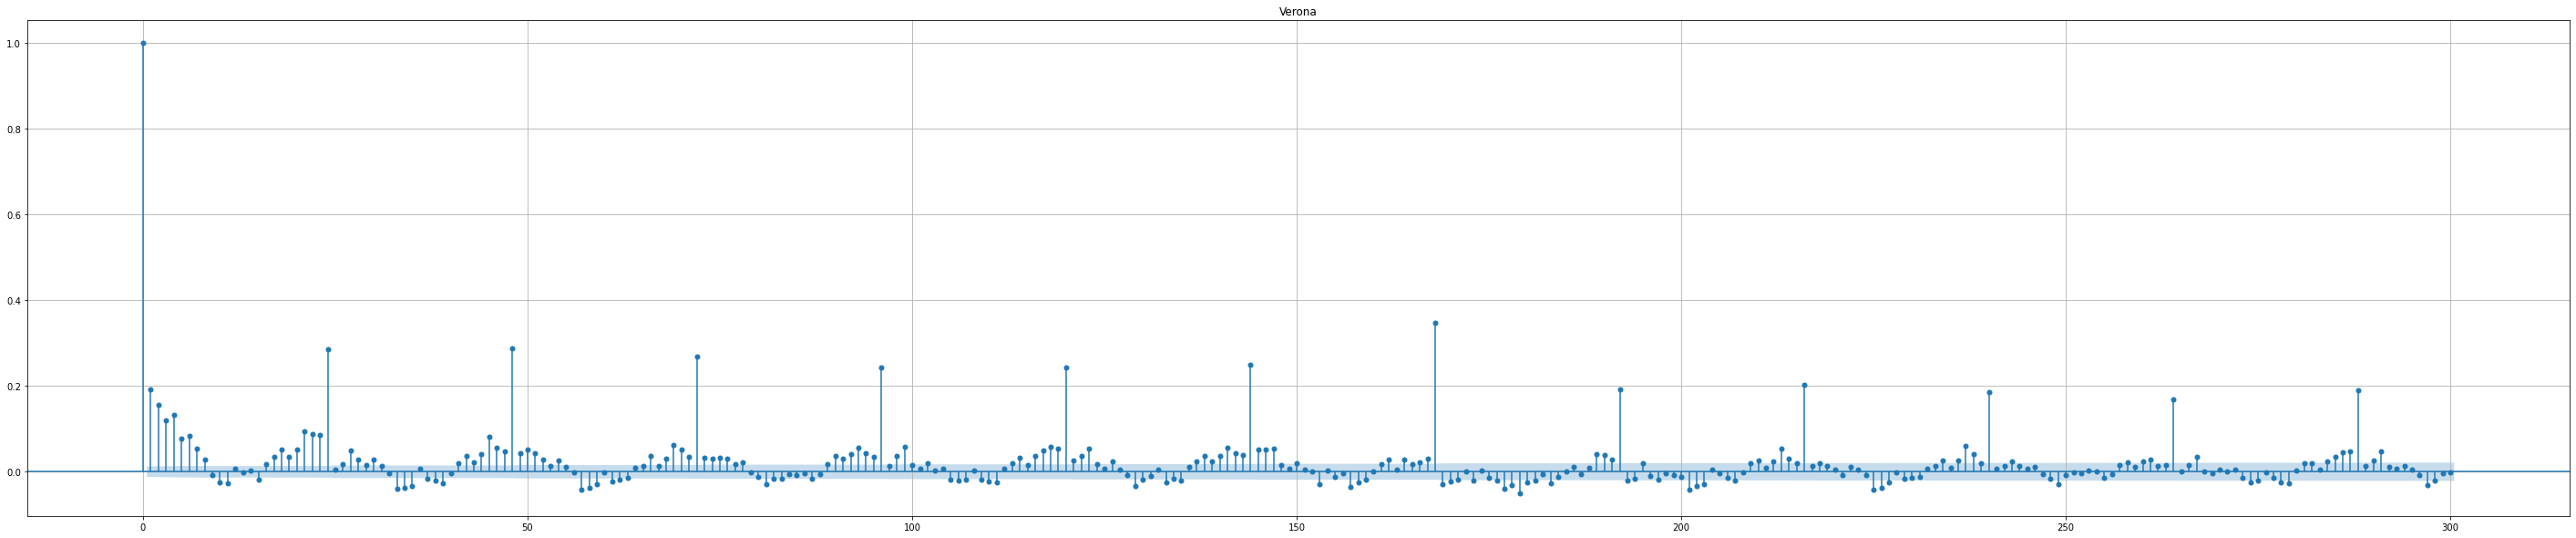





Media: 0.9167790392322813
Mediana: 0.9376878271837326


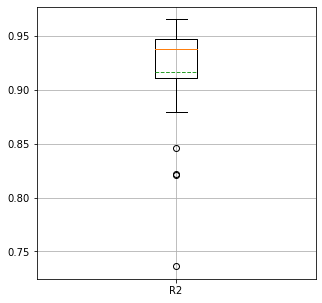

In [74]:
R2 = []
for città in data_edit:
    datacittà = copy.deepcopy(data_edit[città])#.dropna()
    # aggiungo i lag a 24 e 24*7 per le variabili pubblico e dipendenti
    
    """ 
    datacittà['pubb_24'] = datacittà['pubb'].shift(24)
    datacittà['dip_24'] = datacittà['dip'].shift(24)
    datacittà['pubb_168'] = datacittà['pubb'].shift(168)
    datacittà['dip_168'] = datacittà['dip'].shift(168)
    """
      
    X1 = X+['giorno della settimana', 'ora']# +['pubb_24','dip_24','pubb_168','dip_168']
    
    #datacittà = datacittà[(datacittà['anno']==2019) & (datacittà['mese'].isin([1,2]))]
    datacittà = datacittà[['Kw']+X1].dropna()
    
    x = datacittà[X1]#.values
    x = pd.get_dummies(x, prefix='WDay', columns=['giorno della settimana'])
    x = pd.get_dummies(x, prefix='Hour', columns=['ora'])
    y = datacittà['Kw'].values

    x = sm.add_constant(x, has_constant='add')

    model = AutoReg(y, [1, 2, 24, 7*24], exog=x)#
    results = model.fit()
    #print(città, '\n', results.summary(), '\n\n')
    
    sm.graphics.tsa.plot_acf(results.resid, lags=300)
    plt.title(città)
    plt.show()
    
    """
    yhat = results.fittedvalues
    print(yhat)
    pred = results.predict(start = len(y), end = len(y)+x1.shape[0]-1, exog_oos = x1)
    pred.index = y1.index
    """
    y = datacittà['Kw']
    #print(y)
    #print(results.fittedvalues)
    #results.rsquared = r_square(y, results.fittedvalues)
    #print(città, '\nR-sqared = ', results.rsquared, '\n\n')
    #pred = results.predict(x1)
    """
    plt.plot(datacittà2018['Kw'])
    plt.plot(yhat)
    plt.plot(datacittà2019['Kw'])
    plt.plot(pred)
    plt.title('{}'.format(città))
    plt.show()
    """
    
    R2.append(r_square(y, results.fittedvalues))
    if r_square(y, results.fittedvalues)<.75:
        print(città, r_square(y, results.fittedvalues), '\n')
        sm.graphics.tsa.plot_acf(results.resid.dropna(), lags=300)
        plt.show()
        

print('\n\n\n\nMedia:', np.mean(R2))
print('Mediana:', np.median(R2))


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.boxplot(R2, labels=['R2'], meanline=True, showmeans=True)
plt.show()